In [2]:
import logging
import numpy as np
import pandas as pd
from arch import arch_model
from random import gauss
from random import seed
from matplotlib import pyplot as plt
import scipy.stats as sts
import json
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.optimize import least_squares

In [3]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
files_folder = config['files_folders']['processed']

# Reading files

In [6]:
rtsi = pd.read_pickle(f'{files_folder}/rtsi.pkl')

In [7]:
rtsi

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,return,log return
<DATE>,,,,,,,
2001-02-18,180.10,180.10,180.10,180.10,0,0.000000,0.000000
2001-02-19,180.10,181.21,176.67,177.29,0,-0.015602,-0.015725
2001-02-20,177.29,179.90,175.28,176.45,0,-0.004738,-0.004749
2001-02-21,176.45,176.45,161.12,162.39,0,-0.079683,-0.083037
2001-02-22,162.39,168.35,162.39,168.31,0,0.036455,0.035807
...,...,...,...,...,...,...,...
2021-10-11,1871.73,1883.71,1867.58,1882.43,1769145502,0.011537,0.011471
2021-10-12,1867.15,1876.79,1860.64,1869.94,1386130631,-0.006635,-0.006657
2021-10-13,1869.05,1869.05,1835.80,1855.11,1830447018,-0.007931,-0.007962


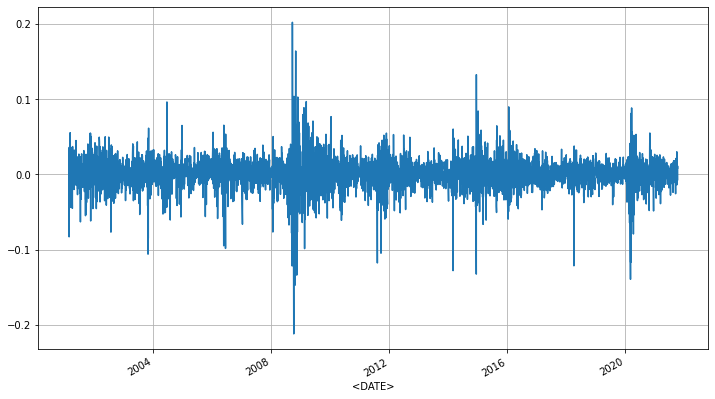

In [8]:
rtsi['log return'].plot(figsize=(12, 7))

plt.grid()
plt.show()

In [9]:
rtsi['log return'].describe()

count    5174.000000
mean        0.000455
std         0.020327
min        -0.211994
25%        -0.008822
50%         0.001318
75%         0.010414
max         0.202039
Name: log return, dtype: float64

# Setting data & parameters

In [10]:
rescale_factor = 100

In [11]:
start_date = '2010-01-01'

In [21]:
input_data = rtsi['log return'].loc[start_date:].copy() * rescale_factor

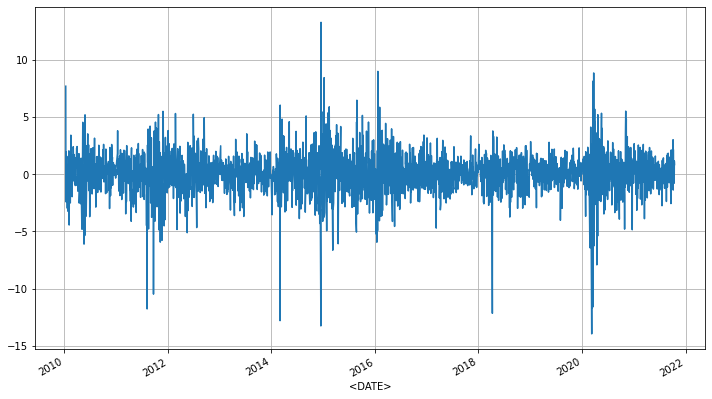

In [22]:
input_data.plot(figsize=(12, 7))

plt.grid()
plt.show()

In [31]:
input_data.describe()

count    2965.000000
mean        0.009091
std         1.772184
min       -13.948614
25%        -0.867805
50%         0.060068
75%         0.920911
max        13.246192
Name: log return, dtype: float64

In [17]:
n = input_data.shape[0]

In [18]:
n

2965

In [24]:
n_train = 2000
n_test = n - n_train

In [25]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:].copy()

In [32]:
# clusterization_method = 'gaussian'
# local_method = 'garch'

p = 1
q = 1

starting_index = max(p, q)

train_sample_std = train.std()
first_h = [train_sample_std ** 2] * starting_index
first_h = np.array(first_h)

local_method_parameters = {'p': p, 'q': q, 'mean': 'Zero', 'dist': 'normal', 'first_h': first_h}

In [35]:
train_sample_std

1.8108445295398075

In [34]:
first_h

array([3.27915791])

In [14]:
mu = 0
sigma = .02 * rescale_factor

centers = [mu]  # np.array([[mu] * n])
variances = [sigma ** 2]  # np.array([np.diag([sigma] * n, k=0)])

In [15]:
clusterization_parameters = {'centers': centers, 'variances': variances, 'n_clusters': 1}

## train & test split 

In [18]:
# centers_train = centers[:, :n_train].copy()
# cov_matrices_train = cov_matrices[:, :n_train, :n_train].copy()

In [19]:
# clusterization_parameters_train = {'centers': centers_train, 'cov_matrices': cov_matrices_train, 'n_clusters': 1}

## Same data fed to GARCH(1, 1)

In [20]:
model = arch_model(input_data,
                   mean=local_method_parameters['mean'],
                   vol='GARCH', p=local_method_parameters['p'],
                   q=local_method_parameters['q'],
                   dist=local_method_parameters['dist'])

In [21]:
model.volatility

GARCH(p: 1, q: 1), id: 0x7fdaf993ac10

In [22]:
fitted = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18208.402879687113
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179841745.16303405
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6259.643369009693
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5746.523881004245
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5518.704480234793
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5518.7020679092275
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5518.701967731444
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5518.7019340838815
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5518.701934085554
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5518.7019340838815
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


In [23]:
fitted.summary

<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:             log return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5518.70
Distribution:                  Normal   AIC:                           11043.4
Method:            Maximum Likelihood   BIC:                           11061.4
                                        No. Observations:                 2965
Date:                Thu, Nov 04 2021   Df Residuals:                     2965
Time:                        20:08:22   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.

In [24]:
fitted.params

omega       0.059160
alpha[1]    0.081849
beta[1]     0.900093
Name: params, dtype: float64

In [25]:
forecast = fitted.forecast(reindex=False, horizon=1)

In [26]:
forecast_variance = forecast.variance.iloc[0]

In [27]:
fitted.forecast(reindex=False, horizon=2).variance

,h.1,h.2
<DATE>,,
2021-10-15,1.817119,1.843465


In [28]:
forecast_variance

h.1    1.817119
Name: 2021-10-15 00:00:00, dtype: float64

In [182]:
least_squares

<function scipy.optimize._lsq.least_squares.least_squares(fun, x0, jac='2-point', bounds=(-inf, inf), method='trf', ftol=1e-08, xtol=1e-08, gtol=1e-08, x_scale=1.0, loss='linear', f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, jac_sparsity=None, max_nfev=None, verbose=0, args=(), kwargs={})>

In [183]:
train

<DATE>
2010-01-11    7.668616
2010-01-12   -2.421124
2010-01-13    1.932676
2010-01-14    0.874942
2010-01-15   -0.491052
                ...   
2017-12-15   -0.438828
2017-12-18   -0.031356
2017-12-19   -1.168036
2017-12-20   -0.463800
2017-12-21   -0.209192
Name: log return, Length: 2000, dtype: float64

# Testing `FuzzyVolatilityModel` class

In [128]:
logging.basicConfig(level=logging.DEBUG)

In [129]:
fvm = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_method,
                           clusterization_parameters=clusterization_parameters,
                           local_method=local_method,
                           local_method_parameters=local_method_parameters)

INFO:model.FuzzyVolatilityModel:Creating an instance of FuzzyVolatilityModel


## `fit`

In [130]:
fvm.fit()

DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4043.5895454901565, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4043.5895454901565, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.78705625e-1757]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed


Iteration:      1,   Func. Count:      5,   Neg. LLF: 11932.727543850217
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24066663.767517917
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3815.9104011498903
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5215.352095508891
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3957.8020446173223
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3807.8476247138947
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3807.730001725556
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3807.729043605945
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3807.7290429766836
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3807.7290429766836
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


In [131]:
# fvm.forecast()

In [132]:
fvm.current_output

In [133]:
fvm.membership_degrees_current

array([7.78705625e-1757], dtype=float128)

In [134]:
fvm.clusters_parameters_current

{'centers': [0], 'variances': [4.0], 'n_clusters': 1}

## `forecast`

In [135]:
# fvm.forecast()

In [136]:
fvm.current_output

## `feed_daily_data`

In [137]:
test_small = test.iloc[:11].copy()

In [138]:
%%time

fvm.feed_daily_data(test_small)

DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1640601558440875]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1640601558440875
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4045.276063319716, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4045.276063319716, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.44187604e-1757]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local mod

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11938.79698400292
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24687153.870436523
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3817.437383590056
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5179.656696955189
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4005.499174151879
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3809.18055778908
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3808.981025987488
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3808.979574857023
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3808.9795734129384
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3808.979573411462
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3808.9795734129384
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4046.953476478486, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4046.953476478486, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.69424227e-1758]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1384422878702163]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1384422878702163
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11944.836856202703
Iteration:      2,   Func. Count:     13,   Neg. LLF: 189936494.689183
Iteration:      3,   Func. Count:     18,   Neg. LLF: 16743.820486595738
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3819.893392109486
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5016.136776077809
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3815.7387946106073
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3810.197153033996
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3810.196363608463
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3810.1963595954794
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3810.1963595959137
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3810.1963595954794
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4048.5665746737104, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4048.5665746737104, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.36879722e-1759]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0814454072547575]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0814454072547575
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11950.808593684204
Iteration:      2,   Func. Count:     13,   Neg. LLF: 185662381.9794952
Iteration:      3,   Func. Count:     18,   Neg. LLF: 5062.362953575363
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3818.733941140039
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4994.856624000879
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3815.8339851653404
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3811.183327058603
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3811.1830834606803
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3811.1830820013865
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3811.1830820023006
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3811.1830820013865
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4050.193486246897, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4050.193486246897, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.05515991e-1759]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0385237315903229]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0385237315903229
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11956.785595225587
Iteration:      2,   Func. Count:     13,   Neg. LLF: 182080982.46528172
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4193.328173081277
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3817.1321183002883
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4041.967167662161
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3818.049139557475
Iteration:      7,   Func. Count:     38,   Neg. LLF: 3812.200079016845
Iteration:      8,   Func. Count:     42,   Neg. LLF: 3812.19545158859
Iteration:      9,   Func. Count:     46,   Neg. LLF: 3812.1954450246467
Iteration:     10,   Func. Count:     49,   Neg. LLF: 3812.1954450253543
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3812.1954450246467
            Iterations: 10
            Function evaluations: 49
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4051.8081776312056, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4051.8081776312056, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.09926239e-1760]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9910406428359273]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9910406428359273
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11962.759802448603
Iteration:      2,   Func. Count:     13,   Neg. LLF: 177133982.30101582
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3944.5815957434006
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3817.326059273135
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4926.084971875299
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3814.3514546862298
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3813.142596852469
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3813.1425840190054
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3813.142583489662
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3813.142583489662
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4053.4342124596055, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4053.4342124596055, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.12941728e-1761]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9550950391382107]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9550950391382107
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11968.74307007086
Iteration:      2,   Func. Count:     13,   Neg. LLF: 175378893.4091766
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3877.520164888751
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3817.641447901574
Iteration:      5,   Func. Count:     28,   Neg. LLF: 6534.119552744245
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3814.303711815931
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3814.118675961201
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3814.1126197107915
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3814.1126197109866
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3814.1126197107915
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4055.7964628572377, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4055.7964628572377, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.89024057e-1762]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.418776400525191]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.418776400525191
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11975.624993687112
Iteration:      2,   Func. Count:     14,   Neg. LLF: 25411590.59644759
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3825.486768218312
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5423.551814097434
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3866.630426066304
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3818.1283809168667
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3818.123499087722
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3818.123488119668
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3818.1234881197724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3818.123488119668
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4058.2507178271358, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4058.2507178271358, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.3427744e-1763]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8929836680543304]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8929836680543304
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11982.619293829863
Iteration:      2,   Func. Count:     14,   Neg. LLF: 17231660.698059242
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3827.1127290965715
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6315.26828918682
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3821.8600774106726
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3821.681175779466
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3821.584794975642
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3821.5847909015783
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3821.5847909012764
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3821.5847909015783
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4059.8904157467186, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4059.8904157467186, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.48627428e-1764]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7813052675421783]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7813052675421783
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11988.61938299462
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18056057.088690937
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3828.7611319038497
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5997.988875962443
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3825.2521500471544
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3822.9555755598076
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3822.8807881002317
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3822.8807088666395
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3822.880708865908
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3822.8807088666395
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4061.57398472208, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4061.57398472208, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.20456598e-1764]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7101075612149081]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7101075612149081
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11994.673093063426
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18647442.261568148
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3830.407373641846
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5822.84881674375
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3834.106648727806
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3824.2826109564785
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3824.248765654793
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3824.248621010631
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3824.2486210099933
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3824.248621010631
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4063.210896550367, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4063.210896550367, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.34384463e-1765]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6155671063861177]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6155671063861177


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12000.6698613
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19571755.16894725
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3832.017630158406
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5653.163363511379
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3840.8737246174264
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3825.5026329069024
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3825.493854129598
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3825.4936044109427
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3825.493583958752
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3825.49358395958
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3825.493583958752
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
CPU times: user 24.8 s, sys: 1.52 s, total: 26.3 s
Wall time: 15.6 s


In [139]:
len(fvm._hist_output)

12

In [140]:
test_small.shape

(11,)

In [144]:
fvm.hist_output.shape

(11,)

### Plots

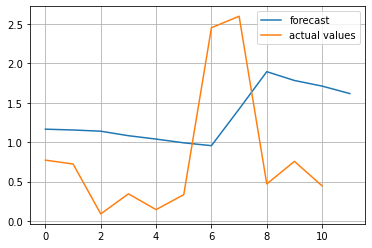

In [145]:
plt.plot(fvm._hist_output, label='forecast')
plt.plot(test_small.values, label='actual values')

plt.legend()
plt.grid()
plt.show()

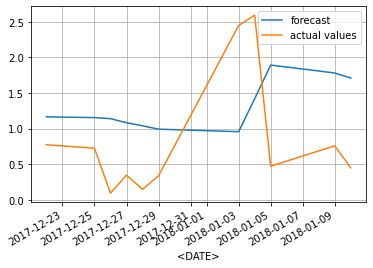

In [148]:
fvm.hist_output.plot(label='forecast')
test_small.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

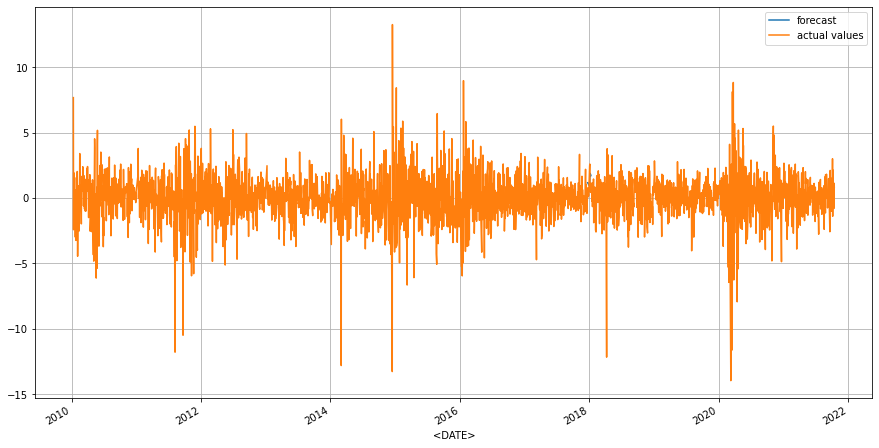

In [149]:
fvm.hist_output.plot(label='forecast', figsize=(15, 8))
input_data.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

### Errors

In [105]:
mean_squared_error(fvm.hist_output, test_small, squared=True)

1.0460753597481783189

In [106]:
mean_squared_error(fvm.hist_output, test_small, squared=False)

1.0227782554142311833

In [107]:
mean_absolute_percentage_error(fvm.hist_output, test_small)

0.75436019368052235223

## Big test

In [128]:
logging.basicConfig(level=logging.DEBUG)

In [158]:
fvm = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_method,
                           clusterization_parameters=clusterization_parameters,
                           local_method=local_method,
                           local_method_parameters=local_method_parameters)

INFO:model.FuzzyVolatilityModel:Creating an instance of FuzzyVolatilityModel


### fitting

In [159]:
fvm.fit()

DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4043.5895454901565, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4043.5895454901565, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.78705625e-1757]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed


Iteration:      1,   Func. Count:      5,   Neg. LLF: 11932.727543850217
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24066663.767517917
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3815.9104011498903
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5215.352095508891
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3957.8020446173223
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3807.8476247138947
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3807.730001725556
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3807.729043605945
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3807.7290429766836
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3807.7290429766836
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


### testing

In [160]:
%%time

fvm.feed_daily_data(test)

DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1640601558440875]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1640601558440875
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4045.276063319716, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4045.276063319716, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.44187604e-1757]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local mod

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11938.79698400292
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24687153.870436523
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3817.437383590056
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5179.656696955189
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4005.499174151879
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3809.18055778908
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3808.981025987488
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3808.979574857023
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3808.9795734129384
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3808.979573411462
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3808.9795734129384
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4046.953476478486, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4046.953476478486, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.69424227e-1758]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1384422878702163]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1384422878702163
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11944.836856202703
Iteration:      2,   Func. Count:     13,   Neg. LLF: 189936494.689183
Iteration:      3,   Func. Count:     18,   Neg. LLF: 16743.820486595738
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3819.893392109486
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5016.136776077809
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3815.7387946106073
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3810.197153033996
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3810.196363608463
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3810.1963595954794
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3810.1963595959137
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3810.1963595954794
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4048.5665746737104, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4048.5665746737104, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.36879722e-1759]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0814454072547575]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0814454072547575
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11950.808593684204
Iteration:      2,   Func. Count:     13,   Neg. LLF: 185662381.9794952
Iteration:      3,   Func. Count:     18,   Neg. LLF: 5062.362953575363
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3818.733941140039
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4994.856624000879
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3815.8339851653404
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3811.183327058603
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3811.1830834606803
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3811.1830820013865
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3811.1830820023006
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3811.1830820013865
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4050.193486246897, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4050.193486246897, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.05515991e-1759]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0385237315903229]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0385237315903229
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11956.785595225587
Iteration:      2,   Func. Count:     13,   Neg. LLF: 182080982.46528172
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4193.328173081277
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3817.1321183002883
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4041.967167662161
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3818.049139557475
Iteration:      7,   Func. Count:     38,   Neg. LLF: 3812.200079016845
Iteration:      8,   Func. Count:     42,   Neg. LLF: 3812.19545158859
Iteration:      9,   Func. Count:     46,   Neg. LLF: 3812.1954450246467
Iteration:     10,   Func. Count:     49,   Neg. LLF: 3812.1954450253543
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3812.1954450246467
            Iterations: 10
            Function evaluations: 49
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4051.8081776312056, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4051.8081776312056, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.09926239e-1760]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9910406428359273]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9910406428359273
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11962.759802448603
Iteration:      2,   Func. Count:     13,   Neg. LLF: 177133982.30101582
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3944.5815957434006
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3817.326059273135
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4926.084971875299
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3814.3514546862298
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3813.142596852469
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3813.1425840190054
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3813.142583489662
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3813.142583489662
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4053.4342124596055, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4053.4342124596055, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.12941728e-1761]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9550950391382107]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9550950391382107
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11968.74307007086
Iteration:      2,   Func. Count:     13,   Neg. LLF: 175378893.4091766
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3877.520164888751
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3817.641447901574
Iteration:      5,   Func. Count:     28,   Neg. LLF: 6534.119552744245
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3814.303711815931
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3814.118675961201
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3814.1126197107915
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3814.1126197109866
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3814.1126197107915
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4055.7964628572377, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4055.7964628572377, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.89024057e-1762]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.418776400525191]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.418776400525191
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11975.624993687112
Iteration:      2,   Func. Count:     14,   Neg. LLF: 25411590.59644759
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3825.486768218312
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5423.551814097434
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3866.630426066304
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3818.1283809168667
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3818.123499087722
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3818.123488119668
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3818.1234881197724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3818.123488119668
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4058.2507178271358, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4058.2507178271358, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.3427744e-1763]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8929836680543304]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8929836680543304
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11982.619293829863
Iteration:      2,   Func. Count:     14,   Neg. LLF: 17231660.698059242
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3827.1127290965715
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6315.26828918682
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3821.8600774106726
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3821.681175779466
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3821.584794975642
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3821.5847909015783
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3821.5847909012764
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3821.5847909015783
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4059.8904157467186, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4059.8904157467186, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.48627428e-1764]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7813052675421783]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7813052675421783
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11988.61938299462
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18056057.088690937
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3828.7611319038497
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5997.988875962443
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3825.2521500471544
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3822.9555755598076
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3822.8807881002317
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3822.8807088666395
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3822.880708865908
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3822.8807088666395
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4061.57398472208, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4061.57398472208, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.20456598e-1764]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7101075612149081]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7101075612149081
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11994.673093063426
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18647442.261568148
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3830.407373641846
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5822.84881674375
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3834.106648727806
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3824.2826109564785
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3824.248765654793
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3824.248621010631
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3824.2486210099933
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3824.248621010631
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4063.210896550367, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4063.210896550367, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.34384463e-1765]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6155671063861177]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6155671063861177
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12000.6698613
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19571755.16894725
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3832.017630158406
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5653.163363511379
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3840.8737246174264
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3825.5026329069024
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3825.493854129598
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3825.4936044109427
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3825.493583958752
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3825.49358395958
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3825.493583958752
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4064.9843971274377, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4064.9843971274377, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.97838954e-1766]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6196414159804065]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6196414159804065
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12006.825639874802
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19519114.10930615
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3833.661071783973
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5620.802994377162
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3844.0434796447153
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3827.0584514360507
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3827.0523141836966
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3827.052022259751
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3827.051999253922
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3827.0519992551644
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3827.051999253922
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4066.71696236574, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4066.71696236574, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.03499482e-1767]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5965962216413232]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5965962216413232
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12012.947560130355
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19771194.006409522
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3835.282903986158
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5564.3494588046
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3849.1778051178944
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3828.5124115238673
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3828.509902707268
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3828.5095487313574
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3828.50952857376
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3828.5095285761304
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3828.50952857376
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4068.337227555622, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4068.337227555622, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.39184717e-1767]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5026419092017889]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5026419092017889
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12018.924182771283
Iteration:      2,   Func. Count:     14,   Neg. LLF: 20937375.772204082
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3836.847273592925
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5453.380252477167
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3861.99268762079
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3829.682719722337
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3829.6826181641045
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3829.6825987260704
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3829.682590369276
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3829.6825903712215
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3829.682590369276
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4069.9573916372196, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4069.9573916372196, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.75399553e-1768]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4176765213386702]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4176765213386702
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12024.894261834108
Iteration:      2,   Func. Count:     14,   Neg. LLF: 22116687.93721524
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3838.3859941535457
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5367.646087273305
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3879.638956573708
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3830.8310376907
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3830.826374641724
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3830.826355391031
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3830.826355391106
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3830.826355391031
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4071.5796912255632, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4071.5796912255632, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.43760269e-1769]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3420964080880364]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3420964080880364
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12030.879820871889
Iteration:      2,   Func. Count:     14,   Neg. LLF: 23401614.169545293
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3839.9031803009048
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5300.05767828126
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3903.397111570418
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3831.9701801500937
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3831.9483514716276
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3831.948335320845
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3831.948335318184
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3831.948335320845
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4073.356012492289, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4073.356012492289, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.20366806e-1770]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3738457029564135]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3738457029564135
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12037.047682140408
Iteration:      2,   Func. Count:     14,   Neg. LLF: 23313785.856996644
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3841.455328310593
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5303.037086730879
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3903.5459897457395
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3833.5248883009153
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3833.5038941532202
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3833.503879896721
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3833.503879894065
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3833.503879896721
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4075.021830723432, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4075.021830723432, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.73982386e-1770]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3305995631949117]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3305995631949117
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12043.07440700709
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24176729.52485968
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3842.998236596633
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5258.562666034602
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3927.099980685837
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3834.786750942035
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3834.7379754061726
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3834.737913323401
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3834.737913322013
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3834.737913323401
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4076.7928078826744, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4076.7928078826744, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.96059958e-1771]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3598397896693433]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3598397896693433
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12049.236714581766
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24115177.071580313
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3844.54840266566
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5259.4595608109685
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3927.8016637968162
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3836.32628025728
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3836.2773769844266
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3836.2773198078858
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3836.277319806475
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3836.2773198078858
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4078.406784759739, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4078.406784759739, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.89438396e-1772]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.284058602034986]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.284058602034986
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12055.211034930533
Iteration:      2,   Func. Count:     14,   Neg. LLF: 25539711.67331545
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3846.120985050921
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5197.041418620087
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3982.445555143085
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3837.4954432284867
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3837.3554762131753
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3837.3551648975163
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3837.3551648986045
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3837.3551648975163
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4080.07420797319, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4080.07420797319, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.11246337e-1772]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2499586706244898]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2499586706244898
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12061.245802494319
Iteration:      2,   Func. Count:     14,   Neg. LLF: 26342067.783812128
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3847.66943028296
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5163.1592857975975
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4042.1099170879606
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3838.827051305978
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3838.57193879053
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3838.5713229184958
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3838.5713219979207
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3838.5713219979207
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4081.949516780868, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4081.949516780868, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.70549109e-1773]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.354862327043132]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.354862327043132
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12067.535822992937
Iteration:      2,   Func. Count:     14,   Neg. LLF: 25248193.81988435
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3849.159461398201
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5208.534745356075
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3970.5029474638013
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3840.564604304318
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3840.444166908882
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3840.4439529412284
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3840.4439529420197
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3840.4439529412284
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4084.0066785144018, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4084.0066785144018, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.17989445e-1774]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5680804116302405]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5680804116302405
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12074.049278406208
Iteration:      2,   Func. Count:     14,   Neg. LLF: 22177692.9610159
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3850.6662592020857
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5338.224963896586
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3900.696155128359
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3842.8398919299793
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3842.8278188274608
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3842.827808186447
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3842.827808186218
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3842.827808186447
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4085.7131086033487, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4085.7131086033487, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.95678355e-1775]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5325397848159756]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5325397848159756
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12080.132442847334
Iteration:      2,   Func. Count:     14,   Neg. LLF: 22665012.598604616
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3852.34089578484
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5288.103778666586
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3916.397232091491
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3844.239522599333
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3844.212256738947
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3844.2122442423906
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3844.212244239709
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3844.2122442423906
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4087.3254993853975, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4087.3254993853975, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.89023384e-1776]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4394479685958999]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4394479685958999
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12086.089044974531
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24061401.61000864
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3854.0365832911407
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5207.97581011697
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3956.67050518652
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3845.4374426826844
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3845.345223378874
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3845.34512789386
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3845.3451278938182
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3845.34512789386
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4088.979678779153, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4088.979678779153, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.50899879e-1776]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.382228044173819]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.382228044173819
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12092.119305244618
Iteration:      2,   Func. Count:     14,   Neg. LLF: 25089632.67294081
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3855.6888389408177
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5159.295236320964
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4008.2263974186785
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3846.7610786601645
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3846.5632633441382
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3846.5629765930307
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3846.562976200868
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3846.562976200868
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4090.6787153733194, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4090.6787153733194, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.75934926e-1777]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3594528185804644]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3594528185804644
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12098.184929433406
Iteration:      2,   Func. Count:     14,   Neg. LLF: 25676213.44155943
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3857.304539443344
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5132.694522730837
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4055.8689853446785
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3848.2026938433446
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3847.895771580813
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3847.89530983738
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3847.895308815723
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3847.895308813863
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3847.895308815723
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4092.6050141116193, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4092.6050141116193, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.0199973e-1778]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4864165170643182]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4864165170643182
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12104.547372114208
Iteration:      2,   Func. Count:     14,   Neg. LLF: 23969848.897093095
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3858.8092480014584
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5185.071054403413
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3975.500758703104
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3850.0214752795523
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3849.892190191651
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3849.89205837976
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3849.892058380703
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3849.89205837976
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4094.27990754396, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4094.27990754396, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.53058624e-1779]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4380862401134753]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4380862401134753
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12110.575610473152
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24778142.234502934
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3860.500090244839
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5142.096959981369
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4026.6928599250464
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3851.423896304076
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3851.178358695289
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3851.1780544806925
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3851.1780538894764
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3851.1780538894764
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4096.667039614232, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4096.667039614232, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.92007021e-1780]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8569331439770018]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8569331439770018
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12117.507162159214
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19109373.548896074
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3861.977484076652
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5388.163574568725
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3891.525275936026
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3854.4319326008613
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3854.4312508433977
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3854.430926909068
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3854.4309086676235
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3854.430908670851
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3854.4309086676235
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4098.35814535357, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4098.35814535357, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.27547694e-1780]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7836636765259766]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7836636765259766
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12123.572805920508
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19704975.168108877
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3863.732909644985
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5316.1448945217835
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3904.555297921084
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3855.8359397963914
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3855.829412612569
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3855.829363200158
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3855.829363199394
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3855.829363200158
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4100.812579756294, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4100.812579756294, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.09578485e-1781]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2150133015190914]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2150133015190914
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12130.575590436212
Iteration:      2,   Func. Count:     14,   Neg. LLF: 15523970.76809186
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3865.6097214486067
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5617.122223909017
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3874.5088629874854
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3858.934315989176
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3858.9245555406533
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3858.924218684003
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3858.924188635966
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3858.924188637124
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3858.924188635966
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4102.964489656543, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4102.964489656543, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.27398026e-1782]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4092435984988976]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4092435984988976
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12137.21051059521
Iteration:      2,   Func. Count:     14,   Neg. LLF: 14230196.045256102
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3867.546231594315
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5769.556886415694
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3872.4140760168657
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3861.240389272425
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3861.2154142860973
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3861.2152040005853
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3861.2152039995526
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3861.2152040005853
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4104.941330893602, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4104.941330893602, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.76453979e-1783]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.469582154395062]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.469582154395062
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12143.633082724133
Iteration:      2,   Func. Count:     14,   Neg. LLF: 13815309.253483552
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3869.4442823424133
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5802.185326656326
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3873.770658669757
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3863.2081580078516
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3863.179551149772
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3863.179372201461
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3863.179372200546
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3863.179372201461
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4106.915324000104, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4106.915324000104, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.45096519e-1784]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.5221595403637083]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.5221595403637083
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12150.031863753338
Iteration:      2,   Func. Count:     14,   Neg. LLF: 13489166.659148006
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3871.352664592845
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5827.213895537139
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3875.3147966354945
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3865.168073792823
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3865.136665047837
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3865.1365067933466
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3865.1365067925203
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3865.1365067933466
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4108.790515079458, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4108.790515079458, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.75795871e-1785]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.504624557107206]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.504624557107206
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12156.340353265507
Iteration:      2,   Func. Count:     14,   Neg. LLF: 13487057.317304064
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3873.1971935127303
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5799.277539331468
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3877.519967004566
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3866.9639714248897
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3866.935439605914
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3866.935261489518
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3866.9352614886166
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3866.935261489518
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4110.643996777416, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4110.643996777416, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.88837053e-1786]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4746342555660976]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4746342555660976
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12162.600711974457
Iteration:      2,   Func. Count:     14,   Neg. LLF: 13542901.74959638
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3875.014277266433
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5768.570143403474
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3879.7628755470137
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3868.724616424419
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3868.698973349418
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3868.6987707641156
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3868.6987707631297
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3868.6987707641156
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4112.256866392774, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4112.256866392774, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.17363961e-1786]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.290818591507175]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.290818591507175
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12168.5776351365
Iteration:      2,   Func. Count:     14,   Neg. LLF: 14353650.048227847
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3876.595846630674
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5666.45094698892
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3883.2149301581303
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3870.0886891666605
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3870.072025596489
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3870.071713262396
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3870.071713261096
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3870.071713262396
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4113.883214861993, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4113.883214861993, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.30791915e-1787]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1344791733465445]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1344791733465445
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12174.564974829507
Iteration:      2,   Func. Count:     14,   Neg. LLF: 15185317.199550414
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3878.1044382787404
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5605.820127445832
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3886.4816308103264
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3871.441439466087
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3871.430140830682
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3871.429835173174
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3871.4298080677427
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3871.4298080686895
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3871.4298080677427
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4115.520539193728, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4115.520539193728, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.48889729e-1788]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0007648930804325]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0007648930804325
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12180.565847634307
Iteration:      2,   Func. Count:     14,   Neg. LLF: 16033150.389097232
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3879.5502631469776
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5572.673199946326
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3889.5110279662094
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3872.783235049881
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3872.7754128988017
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3872.7750438799876
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3872.7750122495754
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3872.775012251046
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3872.7750122495754
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4117.670576365366, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4117.670576365366, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.22865984e-1789]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2108349278740747]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2108349278740747
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12187.198255578536
Iteration:      2,   Func. Count:     14,   Neg. LLF: 14923353.461360766
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3881.7799931159952
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5602.293523446312
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3889.379742118377
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3875.1304173462004
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3875.1163347737047
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3875.1160446032695
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3875.116018674595
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3875.116018675382
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3875.116018674595
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4119.3544183932645, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4119.3544183932645, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.70749304e-1790]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.099791658709237]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.099791658709237
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12193.25292421761
Iteration:      2,   Func. Count:     14,   Neg. LLF: 15586073.998238467
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3883.3186405549004
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5570.260655059876
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3892.1539640573537
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3876.5723782662208
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3876.5617511758674
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3876.56139950348
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3876.561367642941
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3876.5613676441153
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3876.561367642941
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4121.370817696164, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4121.370817696164, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.29239717e-1790]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.214065772227797]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.214065772227797
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12199.718792190524
Iteration:      2,   Func. Count:     14,   Neg. LLF: 14960047.237210084
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3885.3120919989897
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5590.111990075482
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3892.9674617561277
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3878.6358753172217
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3878.621709887004
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3878.6214068612226
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3878.6213794322894
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3878.621379433119
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3878.6213794322894
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4123.119601830586, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4123.119601830586, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.24858183e-1791]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.14467382730099]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.14467382730099
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12205.861731770792
Iteration:      2,   Func. Count:     14,   Neg. LLF: 15429995.744778994
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3886.93121717275
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5571.431786001023
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3895.2912640988616
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3880.1970875738925
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3880.185022367913
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3880.1846826960355
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3880.184651577207
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3880.184651578256
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3880.184651577207
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4125.209134900764, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4125.209134900764, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.7825054e-1792]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3018656898822862]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3018656898822862
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12212.422920831135
Iteration:      2,   Func. Count:     14,   Neg. LLF: 14577980.9985241
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3889.030560987133
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5599.483179778115
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3895.9554893727986
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3882.3928935803788
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3882.3758607957034
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3882.3754719917865
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3882.3754719902827
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3882.3754719917865
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4126.918495863462, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4126.918495863462, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.03581749e-1793]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1985855861495764]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1985855861495764
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12218.513612286879
Iteration:      2,   Func. Count:     14,   Neg. LLF: 15170168.270493345
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3890.6160781393573
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5570.965396150137
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3898.4400829111896
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3883.894557464663
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3883.880582102698
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3883.880257099182
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3883.8802271597897
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3883.8802271607065
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3883.8802271597897
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4128.653051974715, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4128.653051974715, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.88713617e-1794]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.121604318883711]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.121604318883711
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12224.63547425698
Iteration:      2,   Func. Count:     14,   Neg. LLF: 15612112.25895349
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3892.1981088599655
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5557.005087854297
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3900.6321309061386
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3885.428357135243
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3885.4162284119675
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3885.4158735248175
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3885.4158407092696
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3885.4158407103782
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3885.4158407092696
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4130.512687262166, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4130.512687262166, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.38398853e-1794]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1325386814960585]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1325386814960585
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12230.911722926474
Iteration:      2,   Func. Count:     14,   Neg. LLF: 15663732.345343167
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3893.954566525401
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5559.030113590524
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3902.2260525145543
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3887.1906091219544
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3887.1779677072354
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3887.1776185261424
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3887.1775861864817
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3887.177586187544
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3887.1775861864817
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4132.127583412691, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4132.127583412691, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.75290994e-1795]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9850175712954004]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9850175712954004
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12236.872990705882
Iteration:      2,   Func. Count:     14,   Neg. LLF: 16654374.35311922
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3895.326484096333
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5541.741092243923
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3904.8014128154555
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3888.4901853482925
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3888.480739593122
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3888.4803474227692
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3888.4803122561343
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3888.4803122575777
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3888.4803122561343
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4133.837039589818, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4133.837039589818, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.98178085e-1796]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9124042100566483]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9124042100566483
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12242.977517704927
Iteration:      2,   Func. Count:     14,   Neg. LLF: 17281702.28370374
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3896.7963697362675
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5544.112805278497
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3906.7692202022463
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3889.9469204821226
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3889.9386544311474
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3889.9382589850857
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3889.938224685544
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3889.93822468711
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3889.938224685544
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4135.629735867298, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4135.629735867298, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.29519344e-1797]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.900166714980853]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.900166714980853
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12249.171655169566
Iteration:      2,   Func. Count:     14,   Neg. LLF: 17546102.566361453
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3898.41097495735
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5549.367838748369
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3908.341456924444
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3891.5678304959315
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3891.559524205385
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3891.5591347393492
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3891.5591010206313
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3891.559101022165
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3891.5591010206313
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4137.2460063917715, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4137.2460063917715, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.64774176e-1797]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7757126164558872]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7757126164558872
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12255.148060967378
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18590652.367034342
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3899.6830303177685
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5554.89196026431
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3910.9476776013744
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3892.8139450598956
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3892.808104289147
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3892.807714613935
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3892.80768429162
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3892.8076842934634
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3892.80768429162
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4138.863292681468, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4138.863292681468, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.26972055e-1798]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6635510802597053]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6635510802597053
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12261.110903734658
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19711254.607264526
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3900.89365719553
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5575.120075877793
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3913.5444997126797
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3894.029639700372
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3894.025664685878
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3894.0253059070988
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3894.0252816885563
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3894.0252816905736
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3894.0252816885563
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4141.406035249758, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4141.406035249758, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.57164828e-1799]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1567868049913894]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1567868049913894
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12268.23335248291
Iteration:      2,   Func. Count:     14,   Neg. LLF: 17207414.482213877
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3904.2313568554746
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5512.548826245728
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3909.2765995108757
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3897.4692494292126
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3897.434525572483
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3897.434120497088
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3897.43412049545
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3897.434120497088
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4143.030366447378, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4143.030366447378, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.06726357e-1800]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.013429598035221]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.013429598035221
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12274.213518141009
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18161143.436700497
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3905.7149705649017
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5471.535626473951
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3912.5522045046687
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3898.782271655775
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3898.760488455231
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3898.759927071424
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3898.7599270695537
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3898.759927071424
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4144.681715117186, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4144.681715117186, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.71855908e-1801]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.901246927551861]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.901246927551861
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12280.254272594
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19034668.378213435
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3907.163591014211
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5451.682442152522
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3915.6691601038665
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3900.121640982471
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3900.107229011505
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3900.106737233912
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3900.1066875186525
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3900.106687520207
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3900.1066875186525
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4146.429692537915, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4146.429692537915, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.69225159e-1801]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.861472081448058]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.861472081448058
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12286.366363042853
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19464772.79722762
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3908.720764933634
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5448.874961343521
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3917.92480018804
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3901.645398575364
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3901.633330114027
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3901.632805442532
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3901.632753927753
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3901.6327539296003
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3901.632753927753
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4148.215502805862, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4148.215502805862, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.83724857e-1802]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8496259735021778]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8496259735021778
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12292.580063190819
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19705771.526333425
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3910.3346249142373
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5449.491629209033
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3919.8073909997047
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3903.2475219904672
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3903.236257935409
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3903.2357231291453
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3903.235671446744
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3903.2356714487028
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3903.235671446744
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4149.982930954596, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4149.982930954596, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.84521545e-1803]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8271335205628512]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8271335205628512
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12298.739815914967
Iteration:      2,   Func. Count:     14,   Neg. LLF: 20089681.233259104
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3911.918022553187
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5448.646755056535
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3921.9244825462038
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3904.8084776367677
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3904.798633558622
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3904.798079441509
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3904.7980277793176
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3904.798027781507
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3904.7980277793176
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4151.692908958976, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4151.692908958976, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.76353009e-1804]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7700296967368263]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7700296967368263
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12304.801696777893
Iteration:      2,   Func. Count:     14,   Neg. LLF: 20715227.92861124
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3913.4019618586626
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5444.4521647626125
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3924.8156681164146
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3906.24013888674
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3906.2332368758703
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3906.2326458847806
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3906.232597271741
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3906.2325972745293
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3906.232597271741
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4153.310113091844, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4153.310113091844, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.73914684e-1804]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6589565096547096]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6589565096547096
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12310.814603738341
Iteration:      2,   Func. Count:     14,   Neg. LLF: 21893939.95170369
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3914.70427752679
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5438.9049507747895
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3929.3563602106356
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3907.451964191303
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3907.449060359864
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3907.448478168325
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3907.4484464056677
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3907.448446409464
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3907.4484464056677
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4155.670037181038, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4155.670037181038, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.64223098e-1805]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0332373509658574]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0332373509658574
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12317.69893592934
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19282980.915521782
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3917.393064921966
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5453.818508321453
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3922.431001327607
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3910.4614028470646
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3910.4229257042625
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3910.422443992669
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3910.422443990844
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3910.422443992669
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4157.420713567199, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4157.420713567199, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.85183994e-1806]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9826144550249976]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9826144550249976
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12323.840552317528
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19670482.96243042
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3919.025460382719
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5435.274887649479
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3925.052226069299
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3911.998890320311
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3911.9693988340287
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3911.968813050882
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3911.9688130489076
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3911.968813050882
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4159.274826439695, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4159.274826439695, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.46574744e-1807]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.002811738908111]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.002811738908111
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12330.112637881177
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19531281.245335516
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3920.767594311633
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5436.993777802643
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3926.6421499372163
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3913.7495963959223
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3913.718831640168
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3913.7182586657764
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3913.7182586638155
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3913.7182586657764
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4161.219655551669, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4161.219655551669, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.38653956e-1808]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0790074739213846]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0790074739213846
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12336.480608181359
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18956115.348771386
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3922.623455353967
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5452.640404312409
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3927.5275717692057
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3915.6897744460766
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3915.649483996577
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3915.6490094248884
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3915.6490094230635
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3915.6490094248884
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4162.836478860714, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4162.836478860714, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.26790924e-1808]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9386797234793818]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9386797234793818
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12342.495941001693
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19995951.789768916
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3924.1054604488686
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5412.491182427649
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3931.2486331754153
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3916.965961828596
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3916.943554016849
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3916.942848836029
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3916.9428488339163
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3916.942848836029
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4164.639585079448, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4164.639585079448, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.08933983e-1809]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9304768499860747]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9304768499860747
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12348.684565597276
Iteration:      2,   Func. Count:     14,   Neg. LLF: 20160746.50249989
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3925.770695387385
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5409.622291633616
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3933.200998359899
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3918.6084844165407
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3918.5874731528897
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3918.5869639538423
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3918.586909109946
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3918.5869091113145
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3918.586909109946
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4166.259040076793, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4166.259040076793, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.13703043e-1810]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8061253187820872]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8061253187820872
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12354.682709783221
Iteration:      2,   Func. Count:     14,   Neg. LLF: 21271288.90740978
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3927.1780946609915
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5387.166650434798
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3937.284511962992
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3919.8614692466167
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3919.8506275701075
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3919.849930507631
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3919.8498626443275
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3919.849862647107
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3919.8498626443275
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4167.880159148055, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4167.880159148055, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.17797254e-1811]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6945567224678568]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6945567224678568
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12360.672469615376
Iteration:      2,   Func. Count:     14,   Neg. LLF: 22434343.240090773
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3928.521362507601
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5377.17854199911
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3941.769265174446
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3921.0898959773604
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3921.0850817720707
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3921.084308243173
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3921.084255868306
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3921.0842558726267
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3921.084255868306
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4169.6297912903265, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4169.6297912903265, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.4216414e-1811]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.675180552378528]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.675180552378528
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12366.789942023912
Iteration:      2,   Func. Count:     14,   Neg. LLF: 22895349.541249886
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3930.046051473988
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5379.777172765108
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3944.1366361478727
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3922.5961635314006
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3922.592361884188
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3922.5916023178256
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3922.591556780384
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3922.5915563095405
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3922.5915563095405
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4171.474680227957, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4171.474680227957, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.24680291e-1812]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7184400139078522]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7184400139078522
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12373.076574707211
Iteration:      2,   Func. Count:     14,   Neg. LLF: 22797324.14799048
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3931.743620930272
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5385.295154775019
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3944.5479493576086
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3924.330562519222
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3924.325163060731
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3924.3243965848387
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3924.32434152773
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3924.324341531848
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3924.32434152773
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4191.549462240877, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4191.549462240877, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.29732227e-1821]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [13.306715759880081]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 13.306715759880081
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12401.730025961797
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2479832.55463916
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1082625477.1800778
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3974.385494000322
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5090.807356978876
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3974.5433197882885
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3967.3715532551378
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3967.3642717889215
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3967.364202952053
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3967.3641960224572
Iteration:     11,   Func. Count:     54,   Neg. LLF: 3967.3641960225887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3967.3641960224572
            Iterations: 11
            Function evaluations: 54
            Gradient evaluati

DEBUG:pdf:log_pdf = -4193.179921382665, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4193.179921382665, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.41586027e-1822]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [12.03815850017827]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 12.03815850017827
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12407.516712461776
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2503982.275841862
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1080648305.024085
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3977.0598219024123
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4189.516812332494
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3975.6465990507013
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3969.5923801441413
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3969.5817071525603
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3969.5810039298694
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3969.580935883393
Iteration:     11,   Func. Count:     54,   Neg. LLF: 3969.580935882571
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3969.580935883393
            Iterations: 11
            Function evaluations: 54
            Gradient evaluatio

DEBUG:pdf:log_pdf = -4194.847751279129, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4194.847751279129, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.58770274e-1822]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [10.942787315360436]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 10.942787315360436
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12413.788839887387
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2555018.2141013187
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1079035504.9334607
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3979.738735337706
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4248.021312328231
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3977.6526256818543
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3971.7748589280727
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3971.762744386928
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3971.761119228725
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3971.760982140317
Iteration:     11,   Func. Count:     55,   Neg. LLF: 3971.7609815985693
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3971.7609815985693
            Iterations: 11
            Function evaluations: 55
            Gradient evaluati

DEBUG:pdf:log_pdf = -4198.230686337938, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4198.230686337938, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.38988087e-1824]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [11.091846745728924]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 11.091846745728924
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12421.899641788284
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2551984.360536502
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1080940889.2351034
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3982.156491213137
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4201.160983561498
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3980.798976923669
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3974.5337837511183
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3974.524802468918
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3974.52354973864
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3974.523463346015
Iteration:     11,   Func. Count:     54,   Neg. LLF: 3974.523463343622
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3974.523463346015
            Iterations: 11
            Function evaluations: 54
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4200.268793537273, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4200.268793537273, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.02167067e-1825]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [10.348969367330108]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 10.348969367330108
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12428.428245365743
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2626232.9684163257
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1080398823.7866557
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3984.7008542394715
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4224.9976462025525
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3983.0802754556075
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3976.8086557514503
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3976.8005055395965
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3976.798691918244
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3976.7985870665534
Iteration:     11,   Func. Count:     55,   Neg. LLF: 3976.7985863127797
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3976.7985863127797
            Iterations: 11
            Function evaluations: 55
            Gradient eval

DEBUG:pdf:log_pdf = -4202.271357832655, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4202.271357832655, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.47846112e-1826]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [9.662807227995057]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 9.662807227995057
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12434.888108295156
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2720244.6646625493
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1079742063.4686606
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3987.2158818523358
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4242.77792666443
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3985.373542630557
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3979.0461429227485
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3979.0389041446024
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3979.036563061296
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3979.0364470133845
Iteration:     11,   Func. Count:     55,   Neg. LLF: 3979.0364458208833
Iteration:     12,   Func. Count:     58,   Neg. LLF: 3979.036445821028
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3979.0364458208833
            Iteratio

DEBUG:pdf:log_pdf = -4205.23824969062, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4205.23824969062, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.877902e-1827]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [9.660372421347539]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 9.660372421347539
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gau

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12442.450690221878
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2725723.533087742
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1080233468.7261982
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3989.6295820544924
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4224.797615942865
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3988.2017521946036
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3981.6579786162015
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3981.6523668467453
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3981.650433143208
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3981.650349243469
Iteration:     11,   Func. Count:     55,   Neg. LLF: 3981.650348347418
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3981.650348347418
            Iterations: 11
            Function evaluations: 55
            Gradient evaluatio

DEBUG:pdf:log_pdf = -4207.906042787008, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4207.906042787008, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.38551896e-1828]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [9.467986861043498]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 9.467986861043498
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12449.785214455209
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2766629.427437473
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1081223466.2613509
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3992.0605376309813
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4218.190432649398
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3990.86795608825
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3984.146839648148
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3984.142236814928
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3984.1404903492603
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3984.1404219501946
Iteration:     11,   Func. Count:     55,   Neg. LLF: 3984.1404211652207
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3984.1404211652207
            Iterations: 11
            Function evaluations: 55
            Gradient evaluatio

DEBUG:pdf:log_pdf = -4209.518993445241, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4209.518993445241, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.74729471e-1829]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [8.629351853580308]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 8.629351853580308
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12455.637139631855
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2947028.882645571
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1079782782.4098608
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3994.480824489636
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4239.623312072145
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3992.986874785375
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3986.1889522910533
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3986.185209765004
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3986.1831275142035
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3986.183054647876
Iteration:     11,   Func. Count:     55,   Neg. LLF: 3986.1830535582862
Iteration:     12,   Func. Count:     58,   Neg. LLF: 3986.1830535584077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3986.1830535582862
            Iteration

DEBUG:pdf:log_pdf = -4211.188467406979, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4211.188467406979, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.27082676e-1829]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [7.91083867533546]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 7.91083867533546
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218177880.770893
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5033.684527548632
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3996.4830182896153
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4310.275860929045
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3988.421657026061
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3988.2295994998303
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3988.2079758698665
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3988.2057959435833
Iteration:      9,   Func. Count:     44,   Neg. LLF: 3988.2057136948356
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3988.2057136954063
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3988.2057136948356
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4212.801791730096, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4212.801791730096, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.53179478e-1830]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [7.228243902353401]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 7.228243902353401
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218178512.8879523
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5036.391270609036
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3998.5776096678255
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4312.498644795181
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3990.369793678258
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3990.181417311808
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3990.160997340609
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3990.1590303445887
Iteration:      9,   Func. Count:     44,   Neg. LLF: 3990.1589500152477
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3990.158950015867
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3990.1589500152477
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4214.493461862266, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4214.493461862266, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.6638599e-1831]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [6.659882216098679]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 6.659882216098679
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218222051.5304708
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5039.460107161729
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4000.6528291270915
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4314.135863740573
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3992.3192951124593
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3992.1323491993016
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3992.112539914531
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3992.1106711105253
Iteration:      9,   Func. Count:     44,   Neg. LLF: 3992.1105915735466
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3992.1105915742673
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3992.1105915735466
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4216.355772031485, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4216.355772031485, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.2436001e-1832]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [6.250466075218637]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 6.250466075218637
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218366887.3682795
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5042.90700991861
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4002.7649121382083
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4315.661263553357
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3994.335671562985
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3994.1491187320844
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3994.1295853979454
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3994.127754928528
Iteration:      9,   Func. Count:     44,   Neg. LLF: 3994.127675532267
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3994.1276755330805
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3994.127675532267
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4218.0494797419, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4218.0494797419, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.33163914e-1832]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.774991805473]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.774991805473
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218416231.9423096
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5046.514803368902
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4004.76319396895
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4316.226671468271
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3996.222637094318
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3996.0361394366823
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3996.016753714396
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3996.014929540491
Iteration:      9,   Func. Count:     44,   Neg. LLF: 3996.0148502070315
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3996.0148502079574
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3996.0148502070315
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4220.045258804689, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4220.045258804689, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.80980056e-1833]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.530107550166436]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.530107550166436
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218661474.9119163
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5050.080307306196
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4006.891147572308
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4317.559870882823
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3998.2825404197274
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3998.097220385639
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3998.078091970277
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3998.076300814162
Iteration:      9,   Func. Count:     44,   Neg. LLF: 3998.0762221526657
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3998.0762221536206
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3998.0762221526657
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4221.665791332933, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4221.665791332933, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.57966499e-1834]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.075328689654388]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.075328689654388
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218667039.089499
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5054.160786826595
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4008.7824056420513
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4316.950408234643
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4000.0624781584133
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3999.8770417930773
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3999.85783662506
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3999.855998383895
Iteration:      9,   Func. Count:     44,   Neg. LLF: 3999.8559199122465
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3999.855919913241
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3999.8559199122465
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4223.37336505295, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4223.37336505295, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.49011721e-1835]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.715524469683952]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.715524469683952
DEBUG:model.FuzzyVolatilityModel:Starting clusteriza

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218733963.4187164
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5057.8128762748
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4010.679689703054
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4316.151255719047
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4001.86984239508
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4001.6834572185403
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4001.6639275668686
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4001.6619950549766
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4001.6619164679832
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4001.6619164689587
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4001.6619164679832
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4225.273998078632, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4225.273998078632, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.70103575e-1836]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.508939404741847]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.508939404741847
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218947293.5441737
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5061.238248219029
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4012.681239364858
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4316.291596157827
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4003.8065736209373
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4003.6221982190114
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4003.6028825682197
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4003.600962905882
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4003.6008858169403
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4003.600885817854
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4003.6008858169403
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4226.953887585421, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4226.953887585421, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.80822039e-1836]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.182940613713254]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.182940613713254
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218999204.5055313
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5065.299503437651
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4014.500708833867
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4314.73768172627
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4005.5380802390932
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4005.3541731625537
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4005.334590029192
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4005.332570434104
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4005.332494441776
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4005.332494442605
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4005.332494441776
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4228.892752563702, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4228.892752563702, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.60143513e-1837]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.049742769096289]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.049742769096289
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1219263626.4847236
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5068.590812336104
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4016.497865307546
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4315.0133619707885
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4007.4802033937112
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4007.3003747782923
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4007.2813372213927
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4007.279394958802
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4007.2793216007703
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4007.279321601526
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4007.2793216007703
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4230.554362838183, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4230.554362838183, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.93838367e-1838]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.753861943905462]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.753861943905462
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1219304861.9819255
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5072.793968237753
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4018.2493616046145
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4312.912182501928
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4009.1447456086385
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4008.967140388537
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4008.947979645754
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4008.9459550299807
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4008.945883917554
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4008.9458839182844
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4008.945883917554
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4232.296734197936, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4232.296734197936, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.64734051e-1839]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.535996288628171]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.535996288628171
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12535.768325184008
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4374.995027473452
Iteration:      3,   Func. Count:     21,   Neg. LLF: 6061.790621350247
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4096.456469041907
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4014.154727385474
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4680.253537295561
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4010.667254574538
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4010.664719873116
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4010.6645873969837
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4010.664583270499
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4010.664583271606
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4010.664583270499
            Iterations: 11
            Function evaluations: 56
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4235.213408060769, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4235.213408060769, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.67936795e-1840]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.084733332961199]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.084733332961199
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1220625043.5256515
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5074.181370597304
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4022.9741740137415
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4322.226505826575
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4013.8674828836265
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4013.704568023455
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4013.688664058009
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4013.6872749156437
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4013.687212372836
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4013.6872123734593
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4013.687212372836
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4237.008247257627, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4237.008247257627, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.77496491e-1841]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.873199061909082]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.873199061909082
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1220780716.5237904
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5077.814798606535
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4024.8520458807616
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4322.100436474486
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4015.664074361714
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4015.5053427811226
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4015.48993881587
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4015.4886032862614
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4015.4885436316335
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4015.4885436321574
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4015.4885436316335
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4238.6844212972555, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4238.6844212972555, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.45460575e-1841]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.6071582958157005]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.6071582958157005
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1220837657.7572596
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5081.224516007138
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4026.604686806603
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4320.87229052338
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4017.321599213842
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4017.1667532256624
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4017.1516897707156
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4017.1503738471292
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4017.1503169594916
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4017.150316959921
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4017.1503169594916
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4240.795986112272, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4240.795986112272, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.76077699e-1842]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.6380473243144493]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.6380473243144493
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1221306391.9938726
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5083.662523882168
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4028.7289298685046
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4323.4529226150535
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4019.4340099147803
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4019.2806665500602
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4019.2659041741526
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4019.26463954294
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4019.2645835564713
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4019.264583556899
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4019.2645835564713
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4242.516113951359, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4242.516113951359, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.15255248e-1843]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.4217337243393398]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.4217337243393398
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1221408161.365744
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5087.106875394234
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4030.4915025135715
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4322.726904886876
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4021.1133354574813
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4020.963497449334
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4020.949039787493
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4020.9477942559083
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4020.947740658965
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4020.9477406593446
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4020.947740658965
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4244.1874037189245, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4244.1874037189245, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.92693824e-1844]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.194627976631423]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.194627976631423
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1221466724.5353942
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5090.329467876834
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4032.1751908530464
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4321.407652048187
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4022.713126397828
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4022.5661812078642
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4022.551849537489
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4022.5505920833575
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4022.5505404757723
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4022.550540476184
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4022.5505404757723
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4245.864181489595, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4245.864181489595, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.10819215e-1844]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.9915135319368913]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.9915135319368913
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12580.530898142004
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4387.981208570062
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5694.1406425555
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4111.247956940652
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4025.101344467094
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4052.457510430324
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4024.132525432443
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4024.130768301926
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4024.130759969989
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4024.130759965895
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4024.130759969989
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4247.789550718953, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4247.789550718953, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.6159869e-1845]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.964704555452279]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.964704555452279
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12586.834536268765
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4389.771432851008
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5674.33756183428
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4113.198992619988
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4026.9779929145866
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4054.8434332910656
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4026.018151526899
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4026.016476556979
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4026.0164686754024
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4026.0164686713906
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4026.0164686754024
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4249.492055242641, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4249.492055242641, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.94475736e-1846]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.799865036250875]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.799865036250875
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12592.95669351311
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4391.681307337218
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5557.812432890447
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4115.0313889003855
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4028.5977649416836
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4070.5860069858018
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4027.601835426519
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4027.600442411779
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4027.6004356384487
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4027.6004356346816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4027.6004356384487
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4251.765322234553, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4251.765322234553, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.0323701e-1847]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.0113578444784532]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.0113578444784532
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12599.762955110844
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4393.149655165413
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5735.97031727662
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4117.123163625741
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4030.8900426074415
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4046.820536150347
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4029.980024721799
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4029.9781915057365
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4029.9781834939718
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4029.978183489896
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4029.9781834939718
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4253.37846548545, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4253.37846548545, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.04230987e-1848]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.7880393333831095]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.7880393333831095
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12605.789965305345
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4395.03655694374
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5588.567658567552
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4118.968084643146
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4032.2803433973613
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4045.6697001476577
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4031.4507186194564
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4031.4493132209186
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4031.4493075569603
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4031.449307553286
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4031.4493075569603
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4255.0030141827265, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4255.0030141827265, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.19033844e-1848]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.592112313672364]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.592112313672364
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12611.795469062801
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4396.982004855183
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5463.2568362999755
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4120.721090691885
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4033.683518013326
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4048.8234239446056
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4032.899375422924
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4032.8983306073746
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4032.8983265589436
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4032.8983265556976
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4032.8983265589436
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4256.621872236403, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4256.621872236403, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.35835587e-1849]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4103368447746494]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4103368447746494
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12617.79406429705
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4398.989263756961
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5351.065287064118
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4122.375661381694
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4035.0597320498614
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4052.4692049882096
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4034.30415191384
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4034.3033834864596
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4034.3033806312137
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4034.3033806284116
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4034.3033806312137
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4258.374474885556, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4258.374474885556, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.08755566e-1850]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3304830080130827]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3304830080130827
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12623.936597657204
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4400.843388630992
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5302.044736054586
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4124.057734285569
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4036.6483843651113
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4055.53386548471
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4035.895855325539
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4035.8952006415575
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4035.895198250836
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4035.8951982482613
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4035.895198250836
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4260.047020744731, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4260.047020744731, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.67513887e-1851]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2073546600622462]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2073546600622462
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12630.00055983708
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4402.827446331034
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5230.584465231923
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4125.625341805102
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4038.0584256089687
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4055.076549085263
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4037.340751729999
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4037.340538572419
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4037.3405268626893
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4037.340526860544
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4037.3405268626893
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4261.659106828181, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4261.659106828181, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.53096814e-1851]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0569440911126664]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0569440911126664
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12635.972360424123
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4404.953014256672
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5147.807658421594
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4127.037769518562
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4039.306582921771
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4052.074536738663
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4038.6548152186983
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4038.654650254577
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4038.6546441394466
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4038.6546441376922
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4038.6546441394466
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4263.272976055066, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4263.272976055066, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.04839789e-1852]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9213848131279296]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9213848131279296
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12641.92916683603
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4407.133988427233
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5075.139601869513
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4128.327858984501
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4040.5170835878466
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4049.3705992920673
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4039.9369862329722
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4039.9368532473236
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4039.9368508437547
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4039.936850842396
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4039.9368508437547
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4265.101142975957, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4265.101142975957, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.89901587e-1853]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9381609105687152]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9381609105687152
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12648.257863325607
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4408.6327460818375
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5086.546510383192
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4129.96172634538
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4042.2498714926364
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4052.4663089364362
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4041.632286975464
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4041.6321510109765
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4041.632148459489
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4041.6321484580444
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4041.632148459489
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4266.7576233652335, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4266.7576233652335, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.34778153e-1854]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8423906679750317]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8423906679750317
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12654.212896200836
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4410.68776716749
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5038.713876815824
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4131.241958855715
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4043.502029122229
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4050.292610476357
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4042.973214971321
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4042.9731022989395
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4042.973101470606
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4042.973101470606
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4268.391973639954, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4268.391973639954, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.8235566e-1854]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7413578769732097]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7413578769732097
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12660.291565004683
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4412.825855443385
Iteration:      3,   Func. Count:     21,   Neg. LLF: 4990.209813892217
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4132.371301122612
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4044.6777256848245
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4048.7839091653836
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4044.2453866419355
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4044.2452974954613
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4044.2452974971247
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4044.2452974954613
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4270.04246425565, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4270.04246425565, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.500421e-1855]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6604645232601911]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6604645232601911
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12666.308921995675
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4414.929088582197
Iteration:      3,   Func. Count:     21,   Neg. LLF: 4952.041583620616
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4133.439024852776
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4045.886623998387
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4048.4540245715143
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4045.529310805066
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4045.529240365372
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4045.5292403658386
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4045.529240365372
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4272.403457358321, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4272.403457358321, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.30182465e-1856]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.048453087348353]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.048453087348353
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12673.261671560875
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4414.205308628184
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5215.092015389269
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4136.654132859689
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4049.7169215246995
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4083.101956379821
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4048.5004611586064
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4048.500157309941
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4048.5001507299653
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4048.500150726929
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4048.5001507299653
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4274.05319698751, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4274.05319698751, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.34280248e-1857]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9406204594120446]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9406204594120446
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12679.200427356216
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4416.15828320653
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5167.88792371602
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4138.086130867468
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4050.711848118539
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4070.8234283692605
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4049.851188157305
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4049.851002654268
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4049.8509982098376
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4049.850998207724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4049.8509982098376
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4275.665282701275, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4275.665282701275, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.26520604e-1857]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8191067062996298]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8191067062996298
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12685.220666465397
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4418.193476641302
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5115.713655461365
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4139.344204527253
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4051.6881835665663
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4061.403780912852
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4051.1012935816893
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4051.1011757201622
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4051.1011734043013
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4051.1011734030344
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4051.1011734043013
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4277.326332918952, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4277.326332918952, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.40312474e-1858]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.740088726548807]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.740088726548807
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12691.344905638382
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4420.184269654267
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5079.385450943208
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4140.592543387147
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4052.8828930626664
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4058.2605846413835
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4052.4268403833275
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4052.4267455239938
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4052.426744389168
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4052.426744388339
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4052.426744389168
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4278.967797986068, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4278.967797986068, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.65475785e-1859]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6560073209793194]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6560073209793194
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12697.271940519995
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4422.231688844086
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5041.777798795691
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4141.693928083645
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4054.0396289587225
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4056.5665829079235
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4053.689984177
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4053.6899059116604
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4053.689905913079
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4053.6899059116604
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4280.621469328213, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4280.621469328213, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.90669856e-1860]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.587707273652631]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.587707273652631
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12703.402259789902
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4424.267166548335
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5010.737124135092
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4142.734306613997
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4055.2422556494744
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4056.3854145984596
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4054.9612970310086
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4054.9612311059213
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4054.9612311062056
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4054.9612311059213
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4282.795166810058, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4282.795166810058, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.01319242e-1860]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8589628154869218]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8589628154869218
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12710.079208684932
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4424.78265542681
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5150.648979802951
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4145.7659825625315
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4058.2662932389567
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4073.2511324987286
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4057.524790739393
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4057.524646929076
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4057.524644164482
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4057.524644162845
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4057.524644164482
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4284.681037225291, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4284.681037225291, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.53698213e-1861]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9187610554552232]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9187610554552232
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12716.421375790644
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4426.470127431765
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5165.911576860673
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4147.591908682985
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4060.2098149262315
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4079.1492753148214
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4059.34287682482
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4059.342701381729
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4059.3426982342535
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4059.342698232311
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4059.3426982342535
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4286.307373800525, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4286.307373800525, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.02245482e-1862]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8090071392228726]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8090071392228726
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12722.288325308953
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4428.4213197735435
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5131.931834659227
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4148.879005020646
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4061.1810069698836
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4070.4712256883427
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4060.617167051797
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4060.61705977661
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4060.6170575978567
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4060.6170575967167
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4060.6170575978567
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4288.4253179154775, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4288.4253179154775, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.63536796e-1863]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.020032148316326]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.020032148316326
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12729.029438928004
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4429.779514452848
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5200.609950091657
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4151.253013963068
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4064.0835161332016
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4091.971431731019
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4062.9508822788043
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4062.9506329589894
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4062.9506288419034
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4062.950628839398
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4062.9506288419034
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4290.108687059266, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4290.108687059266, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.75259099e-1864]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9364485203878186]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9364485203878186
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12735.062870957754
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4431.664337331132
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5177.392773198164
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4152.741928368216
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4065.166494218879
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4084.011842433878
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4064.3623729759356
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4064.3622176834965
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4064.3622139723684
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4064.362213970541
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4064.3622139723684
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4291.934498025679, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4291.934498025679, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.08775432e-1864]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9506523280589165]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9506523280589165
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12741.332629154413
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4433.456022737732
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5177.205000639829
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4154.446239980693
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4066.844570842084
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4085.362701464981
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4066.053212830309
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4066.053061516933
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4066.0530578482267
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4066.053057846441
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4066.0530578482267
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4293.5731879755485, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4293.5731879755485, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.11279234e-1865]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8456933441691585]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8456933441691585
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12747.40138986842
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4435.383134386311
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5149.707280959554
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4155.799040389723
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4067.8967660706253
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4076.505500799765
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4067.3606377790284
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4067.36052977733
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4067.3605270505054
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4067.3605270494136
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4067.3605270505054
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4295.2293189691245, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4295.2293189691245, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.03281466e-1866]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7618493943029474]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7618493943029474
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12753.330460734462
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4437.32487992799
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5125.202546482216
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4157.090138879757
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4069.0843086719296
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4072.5000498399136
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4068.681356631978
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4068.681248544778
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4068.681246933603
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4068.681246932795
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4068.681246933603
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4296.9674767899505, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4296.9674767899505, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.09146416e-1867]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.737816253880464]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.737816253880464
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12759.594690289116
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4439.170429861566
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5115.739948517956
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4158.541295365418
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4070.534705908945
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4072.667811019148
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4070.169673437299
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4070.169562393212
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4070.169561377986
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4070.1695613772777
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4070.169561377986
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4298.579645567659, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4298.579645567659, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.41442495e-1867]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6364893643013747]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6364893643013747
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12765.586995119302
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4441.198730291128
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5086.00801411135
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4159.56967779519
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4071.6550095156463
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4071.695031967026
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4071.3649970978604
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4071.36481675604
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4071.3648167566917
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4071.36481675604
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4301.002901272164, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4301.002901272164, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.25364141e-1868]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0567900019372436]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0567900019372436
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12772.57651756358
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4441.6593259285
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5255.6230688012365
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4163.162564620201
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4075.5562038573803
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4111.723186662141
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4074.510841514838
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4074.5106198039925
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4074.5106134654216
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4074.5106134627954
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4074.5106134654216
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4302.620864579589, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4302.620864579589, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.48599809e-1869]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.928587495102291]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.928587495102291
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12778.576428301276
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4443.544668513921
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5227.505716019528
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4164.618116757685
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4076.436944932144
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4090.709582388349
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4075.8015461288255
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4075.801416534691
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4075.8014114299385
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4075.801411428519
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4075.8014114299385
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4304.249556558016, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4304.249556558016, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.87718077e-1870]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8197461917266173]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8197461917266173
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12784.568097353318
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4445.473180397575
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5199.473363160954
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4165.9764203195955
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4077.5267453651654
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4081.078981081408
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4077.0832256804547
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4077.0830635113584
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4077.0830596701244
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4077.0830596689048
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4077.0830596701244
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4305.86164568927, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4305.86164568927, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.72853483e-1871]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7110639357708013]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7110639357708013
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12790.41789551299
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4447.459234412772
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5168.371900600758
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4167.1785695353265
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4078.657421680222
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4078.5757728888157
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4078.3017222338767
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4078.301196179051
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4078.3011961811003
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4078.301196179051
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4308.014150327461, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4308.014150327461, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.13038543e-1871]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.952113486281823]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.952113486281823
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12797.116944837144
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4448.652481023644
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5251.056275415265
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4169.728075507575
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4081.353895426065
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4093.7144470075923
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4080.751748411368
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4080.751610585209
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4080.751604478023
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4080.751604476636
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4080.751604478023
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4309.62928075115, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4309.62928075115, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.24793796e-1872]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8325399825700832]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8325399825700832
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12803.208792071979
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4450.574817947744
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5222.08641591841
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4171.100214062293
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4082.4363744148986
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4084.0841185938334
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4082.011327633104
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4082.0110906881678
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4082.0110876049184
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4082.0110876034237
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4082.0110876049184
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4311.587830466933, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4311.587830466933, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.17100544e-1873]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9397368295683184]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9397368295683184
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12809.656427893922
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4452.211245643744
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5248.506649621861
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4173.069674960768
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4084.5084066984887
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4091.3848827847805
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4083.9892504541012
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4083.989087958058
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4083.989081475364
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4083.9890814740083
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4083.989081475364
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4313.274463632603, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4313.274463632603, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.87085711e-1874]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8661311329004664]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8661311329004664
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12815.630025324837
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4454.0975372129
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5229.369146225119
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4174.554339518434
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4085.8172902572696
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4087.1341269351756
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4085.3932174204006
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4085.39295209499
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4085.392949292523
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4085.3929492909615
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4085.392949292523
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4315.112556332909, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4315.112556332909, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.34174468e-1875]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.894513469708605]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.894513469708605
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12821.998051236335
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4455.866027959739
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5233.399832083721
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4176.285577733036
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4087.53897438138
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4089.150124996716
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4087.1085163437037
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4087.1082644987173
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4087.108261167091
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4087.1082611655224
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4087.108261167091
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4316.794884231569, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4316.794884231569, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.73700981e-1875]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8226564493704798]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8226564493704798
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12828.09309114184
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4457.762271742704
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5214.399124799314
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4177.72605034003
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4088.8826426834394
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4088.5559858770607
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4088.500900974358
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4088.4949114546944
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4088.494911457091
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4088.4949114546944
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4318.532304981931, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4318.532304981931, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.05668035e-1876]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7922022885965254]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7922022885965254
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12834.240998455733
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4459.613714663699
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5204.2288107344475
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4179.234502211491
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4090.3698022556455
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4090.0877295832775
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4089.9916731832673
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4089.9890202405268
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4089.9890202424986
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4089.9890202405268
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4320.21192387532, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4320.21192387532, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.69902823e-1877]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7284530464411958]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7284530464411958
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12840.317767625525
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4461.527836640896
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5185.791478704647
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4180.5792366180885
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4091.738502563309
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4092.7401884447117
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4091.3505335920677
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4091.3503205097168
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4091.3503194238915
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4091.3503194233003
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4091.3503194238915
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4322.042318510294, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4322.042318510294, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.13840747e-1878]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7653223634707924]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7653223634707924
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12846.516619438156
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4463.242160669692
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5194.068814113871
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4182.304803786506
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4093.432703193377
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4093.966413736627
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4093.048353545443
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4093.048084348671
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4093.048083583022
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4093.048083583022
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4324.045184640612, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4324.045184640612, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.23320935e-1878]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.906581610695387]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.906581610695387
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12853.015935368356
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4464.77793451752
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5229.880301432373
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4184.457901872327
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4095.5331627364585
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4095.3564060923663
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4095.137707079055
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4095.136541312541
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4095.1365406824993
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4095.1365406824993
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4326.0570593513075, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4326.0570593513075, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.64926607e-1879]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.039711061152462]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.039711061152462
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12859.48155423726
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4466.464008994228
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5254.906067187464
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4186.503933278245
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4097.683870933929
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4101.200139606495
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4097.21702000966
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4097.216815349324
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4097.216809621155
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4097.2168096196665
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4097.216809621155
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4327.765716758585, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4327.765716758585, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.98696574e-1880]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9698649035247748]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9698649035247748
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12865.656742855806
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4468.32500795335
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5240.643479903978
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4188.0764544560025
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4099.088837670555
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4099.092103825083
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4098.682148303724
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4098.681467250605
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4098.68146651622
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4098.68146651622
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4329.611054125917, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4329.611054125917, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.71857004e-1881]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.992420458976654]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.992420458976654
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12871.938807795661
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4470.127845931366
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5242.106208564719
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4189.830542918232
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4100.820675414212
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4100.80011057977
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4100.413752977819
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4100.413027912626
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4100.413027189682
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4100.413027189682
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4331.409738068402, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4331.409738068402, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.81001548e-1882]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9836104369542402]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9836104369542402
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12878.145711693376
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4471.955595774158
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5237.943266515305
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4191.514182257035
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4102.4515432079625
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4102.092079604259
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4102.064699209042
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4102.051247518965
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4102.051247521595
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4102.051247518965
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4333.0260853451355, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4333.0260853451355, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.55124785e-1882]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.861622770751138]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.861622770751138
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12884.120670729684
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4473.866399377566
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5214.315795429778
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4192.892504721714
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4103.742998392234
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4105.754393579699
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4103.321277453333
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4103.321071965358
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4103.321069569197
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4103.32106956857
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4103.321069569197
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4334.686079103895, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4334.686079103895, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.94954524e-1883]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.778876009497925]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.778876009497925
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12890.21674675665
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4475.787247854274
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5194.670346425929
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4194.235953401278
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4105.123725863998
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4110.9016444391455
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4104.653721864076
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4104.653574360453
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4104.653571870407
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4104.653571870119
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4104.653571870407
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4336.3063864624655, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4336.3063864624655, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.83531786e-1884]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.679330550027616]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.679330550027616
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12896.128054755365
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4477.776240180339
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5169.359221333212
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4195.378203317618
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4106.417447025579
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4112.759103266007
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4105.878988562552
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4105.878832763151
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4105.878832763186
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4105.878832763151
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4338.0249678366845, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4338.0249678366845, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.04639128e-1884]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6507284734089929]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6507284734089929
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12902.330844257904
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4479.640379246378
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5159.97138614249
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4196.73329006657
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4107.867087223877
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4114.388561901187
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4107.310736570335
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4107.310580053567
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4107.310580054073
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4107.310580053567
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4339.740831948978, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4339.740831948978, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.88149814e-1885]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6231317128911322]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6231317128911322
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12908.393927331395
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4481.507265043206
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5150.790440986847
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4198.058105610003
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4109.306238836074
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4116.010104134769
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4108.73170339478
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4108.731545543602
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4108.731545544425
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4108.731545543602
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4341.507433707318, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4341.507433707318, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.21572128e-1886]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6299515755621978]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6299515755621978
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12914.656110733971
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4483.2823395062505
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5151.3435284067
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4199.57355759174
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4110.845952047147
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4117.5568821751085
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4110.273589727497
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4110.273434144194
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4110.273434144971
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4110.273434144194
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4343.465114734794, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4343.465114734794, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.54013045e-1887]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7557564206295444]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7557564206295444
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12921.078484027395
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4484.746513194739
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5186.006964276703
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4201.838872773731
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4112.78008084418
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4118.843485418115
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4112.284802197599
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4112.28465913563
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4112.284657971352
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4112.284657971078
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4112.284657971352
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4345.09344088613, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4345.09344088613, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.91036037e-1888]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6632090178077248]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6632090178077248
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12927.093420665275
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4486.698327159858
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5165.2782659213235
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4202.952548153975
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4114.124864928792
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4120.934254168503
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4113.522060355438
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4113.521888148568
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4113.521888149889
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4113.521888148568
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4346.74615925931, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4346.74615925931, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.70658844e-1888]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5947383267250606]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5947383267250606
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12933.138615275278
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4488.650843514
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5147.561527287651
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4204.03021487409
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4115.475654360143
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4122.846970381309
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4114.792984443137
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4114.792784260395
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4114.792784262572
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4114.792784260395
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4348.428862184572, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4348.428862184572, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.17205132e-1889]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5515403943697668]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5515403943697668
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12939.220977836136
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4490.569848550353
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5134.964887460046
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4205.155653222352
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4116.851253498758
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4124.57090541299
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4116.122321865176
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4116.122104366345
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4116.12210436889
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4116.122104366345
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4351.130950937259, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4351.130950937259, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.12734521e-1890]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1503162169867407]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1503162169867407
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12946.566079385673
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4490.55253939881
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5377.1622416339005
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4210.231876645175
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4120.585917256795
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4121.824776689011
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4120.066076323603
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4120.065416992825
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4120.065415962913
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4120.065415960991
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4120.065415962913
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4353.019792709655, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4353.019792709655, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.21754338e-1891]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1820486640412162]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1820486640412162
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12952.904331594658
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4492.4309362795875
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5376.357701770528
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4212.04960398649
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4122.400140297946
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4123.568789028477
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4121.882647752183
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4121.881981875054
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4121.8819808576745
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4121.881980855766
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4121.8819808576745
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4356.390767051708, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4356.390767051708, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.10542391e-1892]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.1495647948291925]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.1495647948291925
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12961.076535105345
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4494.565780117129
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5533.037352422223
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4214.821609195009
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4133.625406089217
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4170.742535817801
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4126.410985070539
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4126.407885132295
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4126.40785143116
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4126.407850598195
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4126.407850598195
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4358.011790529346, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4358.011790529346, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.18538171e-1893]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.910728373275937]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.910728373275937
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12966.99517210578
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4496.221164694145
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5518.091614623445
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4216.837729393589
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4132.113667136311
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4273.2953534308035
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4127.912320701566
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4127.911234699949
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4127.911223716899
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4127.911223712053
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4127.911223716899
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4360.139318621025, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4360.139318621025, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.60347609e-1894]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.019279233880229]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.019279233880229
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12973.718584461893
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4498.423331332097
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5517.58725323651
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4218.816684017975
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4134.896610470888
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4232.268194421213
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4130.074031610886
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4130.072635400928
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4130.072624666134
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4130.0726246623135
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4130.072624666134
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4362.506670136581, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4362.506670136581, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.44020265e-1895]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.270354095472978]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.270354095472978
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12980.564471135443
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4500.882211522289
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5526.295365470955
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4220.827566369888
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4139.478355127467
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4176.704201040942
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4132.547197859405
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4132.544290887177
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4132.544260287617
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4132.544259513802
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4132.544259513802
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4364.259826797924, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4364.259826797924, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.22707185e-1896]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.104673827418077]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.104673827418077
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12986.821456418422
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4502.706535769794
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5510.619309913865
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4222.872213183884
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4139.237208151244
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4218.345367858871
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4134.229563317753
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4134.228015657362
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4134.228003882235
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4134.228003878801
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4134.228003882235
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4366.083011292436, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4366.083011292436, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.82716917e-1897]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.000659257627494]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.000659257627494
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12992.938390888645
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4504.610859253125
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5496.618148144597
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4224.888110472985
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4139.992280084197
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4257.807521320625
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4135.986349453988
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4135.98530677386
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4135.98529726684
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4135.985297262438
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4135.98529726684
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4367.872041324435, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4367.872041324435, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.14097149e-1897]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.8859005685513246]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.8859005685513246
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12999.28360574925
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4506.4844228264665
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5480.20430748434
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4226.8845784551495
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4140.861999717694
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4300.215641844448
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4137.690264154035
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4137.6894636594125
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4137.689449925504
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4137.689449385646
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4137.689449385646
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4369.534434952548, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4369.534434952548, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.16424496e-1898]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.7034103573143797]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.7034103573143797
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13005.312936713013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4508.27314134859
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5453.850533726439
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4228.854392548655
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4141.478782320892
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4323.317489182758
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4139.208592072674
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4139.207886690536
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4139.2078706871725
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4139.207869926178
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4139.207869926178
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4371.196828580661, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4371.196828580661, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.10523511e-1899]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.539577559634813]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.539577559634813
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13011.3699454737
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4510.096201478174
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5424.790913377992
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4230.769211289571
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4142.409101316634
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4282.028687621062
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4140.698997573381
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4140.698395266486
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4140.69838162029
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4140.698380921365
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4140.698380921365
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4373.321193075402, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4373.321193075402, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.90612102e-1900]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.680563718331448]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.680563718331448
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13018.034015389014
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4511.968537717481
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5451.953133759736
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4232.698523641235
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4144.940055940286
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4326.646403212799
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4142.89085806478
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4142.890157577806
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4142.890142088353
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4142.8901412698215
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4142.8901412698215
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4375.404588477778, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4375.404588477778, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.1084515e-1901]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.7823013876304126]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.7823013876304126
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13024.610811593531
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4513.93308242779
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5467.142033408892
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4234.640683848913
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4147.336643661603
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4345.0036752739525
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4145.006121998327
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4145.005384592192
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4145.0053679757875
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4145.005367157679
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4145.005367157679
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4377.435753183558, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4377.435753183558, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.01322812e-1902]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.8414277363063056]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.8414277363063056
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13031.1477106416
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4515.922582817815
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5473.0621605495135
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4236.597434976236
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4149.512466042557
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4346.921213545729
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4147.039193377184
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4147.038447925213
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4147.038431054014
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4147.038430268248
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4147.038430268248
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4379.084432719499, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4379.084432719499, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.54097319e-1902]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.655320497459455]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.655320497459455
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13037.164363831816
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4517.716171696549
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5440.91028039589
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4238.5556962967585
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4150.296988293437
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4307.619928578801
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4148.531550597884
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4148.530906004445
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4148.530892090671
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4148.53089131452
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4148.53089131452
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4380.744910419672, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4380.744910419672, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.92859137e-1903]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4953602230159206]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4953602230159206
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13043.250204512842
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4519.552409947594
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5407.869917928669
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4240.451563020968
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4151.3672167763425
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4249.048499390099
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4150.011390605756
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4150.010921004891
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4150.010909480978
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4150.010908958993
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4150.010908958993
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4382.452853427447, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4382.452853427447, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.30772673e-1904]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.38077497483701]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.38077497483701
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13049.312032891354
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4521.415778867268
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5380.003292471089
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4242.2914533138455
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4152.687784843343
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4217.697296123868
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4151.541023248259
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4151.540673785876
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4151.540663110537
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4151.540663106882
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4151.540663110537
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4384.363095259417, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4384.363095259417, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.85780177e-1905]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4034341077989887]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4034341077989887
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13055.73596028774
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4523.209452276902
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5384.238122593888
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4244.150598547556
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4154.569128268837
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4223.125321270274
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4153.394629823052
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4153.394265139489
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4153.3942542775185
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4153.39425427375
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4153.3942542775185
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4386.028340539658, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4386.028340539658, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.48625809e-1905]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2713727592062405]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2713727592062405
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13061.708490314551
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4525.089935243248
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5350.431382736624
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4245.929291563962
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4155.804036507014
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4196.760479594632
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4154.840314144136
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4154.840055444667
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4154.8400452259575
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4154.840045223081
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4154.8400452259575
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4387.649878280166, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4387.649878280166, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.93676597e-1906]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1249723456829557]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1249723456829557
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13067.811381354672
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4527.0255158881055
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5309.439876900723
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4247.606491945392
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4156.981239512473
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4180.166017883826
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4156.185932698989
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4156.185725272078
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4156.185715689079
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4156.185715686906
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4156.185715689079
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4389.453974175785, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4389.453974175785, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.83459888e-1907]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1064917654613686]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1064917654613686
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13074.048558336613
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4528.803557830017
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5302.5357215067015
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4249.336575691468
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4158.628288444803
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4180.598135555073
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4157.8431740540245
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4157.842969171023
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4157.8429599075735
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4157.842959905445
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4157.8429599075735
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4391.2998997822, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4391.2998997822, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.63282214e-1908]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.115884412517855]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.115884412517855
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gau

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13080.337793250785
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4530.536081135378
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5304.306453413799
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4251.095729996185
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4160.378021327633
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4183.323847864534
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4159.57866226763
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4159.578455173003
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4159.578445976855
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4159.578445974679
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4159.578445976855
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4392.9287134133665, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4392.9287134133665, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.49727085e-1908]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9890421745586524]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9890421745586524
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13086.248809528654
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4532.4946796589165
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5266.065208387667
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4252.64604906608
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4161.55767526803
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4173.951551578005
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4160.903833221917
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4160.903641593909
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4160.903633861933
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4160.903633860194
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4160.903633861933
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4394.597476617218, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4394.597476617218, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.8220566e-1909]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8992861774340646]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8992861774340646
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13092.427291834367
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4534.439388991748
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5235.830427554103
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4254.137853270525
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4162.8537444938975
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4170.794495358448
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4162.280478846632
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4162.280290923904
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4162.280285124403
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4162.2802851228735
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4162.280285124403
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4396.38513103168, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4396.38513103168, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.72277517e-1910]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8925332210995423]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8925332210995423
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13098.507818495065
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4536.183299124728
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5232.370452569259
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4255.763751301545
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4164.461337766721
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4172.377112833861
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4163.889896852246
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4163.889713591899
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4163.889708189373
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4163.889708187875
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4163.889708189373
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4398.259958533292, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4398.259958533292, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.24385975e-1911]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9409468719902625]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9409468719902625
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13104.970430258938
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4537.789875892384
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5247.681937250221
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4257.543537697451
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4166.308353251753
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4176.959056822944
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4165.68311330572
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4165.682931262278
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4165.682925094332
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4165.682925092717
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4165.682925094332
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4400.0600636601375, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4400.0600636601375, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.19727609e-1911]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9379133116937342]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9379133116937342
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13111.112838777626
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4539.552153941214
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5244.865429885642
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4259.205587853081
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4167.935086366942
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4178.013736409145
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4167.32111096117
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4167.32093071433
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4167.320924843281
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4167.320924841703
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4167.320924843281
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4401.781470128782, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4401.781470128782, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.14090294e-1912]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8860186845253155]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8860186845253155
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13117.339047969032
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4541.414805764106
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5227.962852754628
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4260.727762411041
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4169.338239294532
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4175.97081746575
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4168.796459492798
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4168.7962789291905
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4168.796274304196
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4168.796274302792
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4168.796274304196
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4403.417184760462, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4403.417184760462, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.17075943e-1913]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7855513323310648]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7855513323310648
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13123.34441598896
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4543.391764602733
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5197.460149132929
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4262.028973925368
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4170.521353622119
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4173.11805657
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4170.082630964127
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4170.0824393407
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4170.08243737265
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4170.082437371543
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4170.08243737265
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4405.589738767244, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4405.589738767244, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.74992688e-1914]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.030515534777826]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.030515534777826
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13129.977425471914
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4544.430716502586
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5285.508368967479
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4264.497042335037
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4173.301035492457
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4191.495460880804
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4172.546561268906
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4172.54636395675
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4172.546356311572
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4172.546356309576
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4172.546356311572
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4407.32209496654, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4407.32209496654, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.40106192e-1915]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9764576242299097]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9764576242299097
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13136.170359109376
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4546.282382053756
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5269.931292132818
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4266.093357437597
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4174.688704593513
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4185.709726604907
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4174.056530437187
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4174.056340615531
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4174.0563336711875
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4174.056333669521
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4174.0563336711875
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4408.975636705297, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4408.975636705297, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.60771896e-1915]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.878546736069676]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.878546736069676
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13142.266038171249
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4548.193884673801
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5243.974618854256
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4267.527057092857
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4175.89346442225
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4179.81623292967
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4175.399963237164
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4175.399742952074
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4175.399738560346
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4175.399738558863
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4175.399738560346
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4410.662895275582, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4410.662895275582, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.97469913e-1916]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.811130995919239]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.811130995919239
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13148.35967005924
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4550.0918453964205
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5223.903914807946
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4268.939604841282
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4177.2219988809375
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4178.567103207133
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4176.794194134673
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4176.793929213121
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4176.793927634624
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4176.793927633356
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4176.793927634624
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4412.444125196438, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4412.444125196438, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.01031142e-1917]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8088928087624072]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8088928087624072
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13154.570405722938
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4551.865184110731
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5221.233369954008
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4270.53174759188
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4178.802258711728
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4179.901476164628
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4178.383671066282
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4178.383399610185
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4178.383398377353
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4178.383398376162
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4178.383398377353
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4414.089974814946, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4414.089974814946, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.66231771e-1918]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7223052464989936]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7223052464989936
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13160.612644787194
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4553.821084960517
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5196.43124356047
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4271.7647902713325
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4180.041370667508
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4179.835517396405
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4179.674347787072
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4179.673243323604
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4179.673243324266
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4179.673243323604
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4415.764908172469, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4415.764908172469, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.80995175e-1918]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6621555488676782]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6621555488676782
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13166.66112583324
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4555.751497982474
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5177.420521618551
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4272.986362050837
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4181.354674588499
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4181.016006463681
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4181.061953571897
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4181.00987749627
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4181.0098774969965
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4181.00987749627
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4418.042737229445, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4418.042737229445, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.85531822e-1919]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9848021790366597]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9848021790366597
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13173.521135818572
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4556.51514626454
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5294.5249778876005
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4276.1085669504355
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4184.397394078947
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4194.095559096779
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4183.784158749115
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4183.783952071771
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4183.783944255876
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4183.783944254175
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4183.783944255876
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4419.670099758683, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4419.670099758683, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.64471725e-1920]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8697341874046147]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8697341874046147
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13179.540790562609
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4558.408196390252
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5269.0117545857665
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4277.5126305731765
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4185.5346974301665
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4186.84396854288
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4185.076654013924
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4185.076307962232
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4185.0763054982035
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4185.076305496525
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4185.0763054982035
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4421.282693904011, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4421.282693904011, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.26646361e-1921]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7567573270345405]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7567573270345405
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13185.494361311847
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4560.355338669423
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5240.874401742503
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4278.760824287771
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4186.713102540414
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4186.322690787917
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4186.365779178783
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4186.309087237485
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4186.309087239413
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4186.309087237485
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4422.977816789516, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4422.977816789516, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.33395318e-1921]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7060279730367631]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7060279730367631
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13191.646247311692
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4562.244279232156
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5225.136121228645
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4280.100495682074
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4188.095992404915
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4188.186576664849
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4187.699263584036
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4187.69875986572
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4187.698759866604
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4187.69875986572
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4424.773818276739, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4424.773818276739, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.21384419e-1922]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7231085652961244]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7231085652961244
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13197.876426157125
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4563.984943968428
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5227.946802615441
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4281.721879932014
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4189.711735946028
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4189.730153074239
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4189.316566877932
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4189.3159920269345
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4189.315992028007
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4189.3159920269345
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4427.505867826283, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4427.505867826283, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.44089724e-1923]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3213553621712224]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3213553621712224
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13205.274367218242
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4564.439831120364
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5439.549368007366
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4285.460641338534
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4194.630436071514
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4307.168895019384
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4193.104325138072
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4193.103753700433
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4193.103738538682
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4193.103737887886
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4193.103737887886
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4429.119853010425, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4429.119853010425, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.86871992e-1924]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1647198997865558]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1647198997865558
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13211.233444545469
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4566.22760427274
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5414.2986580933575
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4287.1835016633795
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4195.302333697791
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4223.9678485414
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4194.447500756196
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4194.446791850541
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4194.446789232264
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4194.446789229391
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4194.446789232264
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4430.733024519869, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4430.733024519869, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.7160585e-1925]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0236157507888417]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0236157507888417
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13217.28090337877
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4568.069471791321
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5386.110348995273
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4288.809931376902
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4196.340758895552
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4199.143866800292
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4195.754413838044
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4195.753708180854
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4195.753706796566
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4195.753706794254
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4195.753706796566
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4432.346495610111, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4432.346495610111, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.13861021e-1925]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8968015171349055]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8968015171349055
DEBUG:model.FuzzyVolatilityModel:Starting cluste

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13223.284036134848
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4569.965086181124
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5355.641287194095
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4290.323068558979
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4197.555698782982
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4197.261958121404
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4197.032833445929
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4197.027684833503
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4197.027684359589
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4197.027684359589
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4434.2035972314425, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4434.2035972314425, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.7776493e-1926]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9331100354253594]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9331100354253594
DEBUG:model.FuzzyVolatilityModel:Starting clusterization


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13229.528596017573
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4571.706507962601
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5362.788439554606
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4292.07846201975
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4199.313937975936
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4198.83587916953
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4198.832714338743
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4198.783400324452
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4198.783400329197
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4198.783400324452
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4436.176832071998, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4436.176832071998, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.47104744e-1927]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0375741758686767]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13236.044038406746
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4573.3864552612995
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5387.045145962291
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4293.981632013712
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4201.339050194107
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4201.813022269402
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4200.780446275171
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4200.779168616655
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4200.779166979761
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4200.779166977372
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4200.779166979761
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4438.079500791016, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4438.079500791016, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.68606134e-1928]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0882753074187663]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0882753074187663
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13242.408738228842
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4575.174796777082
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5394.76973112855
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4295.796872709894
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4203.202273685625
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4204.787332772525
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4202.625287208628
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4202.624431880058
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4202.624430413713
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4202.624430411349
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4202.624430413713
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4439.719127622194, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4439.719127622194, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.15289209e-1929]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9712771668339921]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9712771668339921
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13248.40907662168
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4577.042409202466
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5369.106113233518
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4297.388688964459
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4204.507334979039
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4204.563453629378
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4203.96601470579
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4203.964174406123
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4203.964171777247
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4203.964171774764
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4203.964171777247
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4441.6740838418, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4441.6740838418, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.01263976e-1929]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.060686229777068]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.060686229777068
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gau

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13254.87547603179
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4578.753727773315
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5388.249628988462
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4299.261557638143
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4206.468476094752
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4205.968644727725
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4205.984132812428
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4205.918159020919
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4205.918158474031
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4205.918158474031
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4443.294916568672, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4443.294916568672, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.00233282e-1930]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9348547833324146]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9348547833324146
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13260.817559218423
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4580.636515499649
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5360.124172076277
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4300.813751772844
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4207.791773691911
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4211.642613130385
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4207.216008424351
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4207.215458086835
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4207.215457292376
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4207.215457292376
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4445.3894056705, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4445.3894056705, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.46553519e-1931]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1139718797506353]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1139718797506353
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1273056783.4610937
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5315.409464729495
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4220.3957654261685
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4497.207293149051
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4209.644154865946
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4209.499505210766
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4209.4671618204675
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4209.461627653964
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4209.461560380758
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4209.461557103939
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4209.461557107976
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4209.461557103939
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4447.170991891783, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4447.170991891783, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.15124286e-1932]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.082227044367622]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.082227044367622
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1273452223.115726
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5317.779318424062
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4222.0275764777325
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4499.51165834099
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4211.256797891338
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4211.112736418092
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4211.080951330867
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4211.075549672181
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4211.075483114378
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4211.0754799586175
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4211.0754799626
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4211.0754799586175
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4448.890727580844, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4448.890727580844, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.43543568e-1933]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.015408018109778]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.015408018109778
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1273706556.2977777
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5319.891724848438
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4223.550035393706
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4502.176664288545
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4212.748350336207
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4212.604293206325
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4212.573191499212
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4212.567946231455
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4212.567880644761
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4212.567877666588
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4212.567877670496
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4212.567877666588
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4450.59876795771, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4450.59876795771, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.34745388e-1933]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9479173163698427]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9479173163698427
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1273940143.7395713
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5321.94776057579
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4225.037607973323
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4504.82035684394
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4214.207578951815
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4214.063306028043
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4214.032789526209
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4214.027676669796
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4214.027611862559
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4214.027609037839
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4214.027609041681
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4214.027609037839
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4452.545542692746, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4452.545542692746, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.92327057e-1934]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0342311366508516]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0342311366508516
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1274781816.4136631
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5324.070335832361
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4226.953053556758
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4505.819864919838
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4216.146710229142
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4216.003339471846
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4215.972450861308
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4215.967255751548
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4215.967190490518
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4215.96718755049
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4215.967187554383
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4215.96718755049
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4454.176734398841, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4454.176734398841, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.76376785e-1935]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9175323979087378]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9175323979087378
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1274827966.1293786
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5326.4515904892405
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4228.31211624368
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4509.04136995742
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4217.456635183571
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4217.313423357993
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4217.283631626392
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4217.278689071014
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4217.278625188532
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4217.278622504047
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4217.278622507817
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4217.278622504047
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4456.297453678013, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4456.297453678013, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.51446352e-1936]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1139845014704193]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1139845014704193
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1276127468.9157665
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5329.80905463766
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4230.563461490554
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4508.9855969036635
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4219.7593075855875
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4219.619492666212
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4219.5890702062
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4219.583999058455
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4219.583934084725
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4219.583931125582
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4219.583931129473
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4219.583931125582
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4458.118713600556, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4458.118713600556, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.3053834e-1937]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1066587966951453]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1066587966951453
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1276615098.4277656
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5332.19623620389
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4232.260822860797
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4510.995049326975
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4221.4471563810175
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4221.308078784429
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4221.277997211348
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4221.273006917045
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4221.272942360485
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4221.272939457305
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4221.272939461171
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4221.272939457305
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4459.784667989582, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4459.784667989582, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.38079185e-1937]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0043485312486395]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0043485312486395
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1276740860.1155756
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5334.359559699208
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4233.699701449717
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4514.040580721704
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4222.839480693141
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4222.7005922810895
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4222.671454408532
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4222.6666753453865
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4222.666612185933
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4222.6666095110295
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4222.666609514787
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4222.6666095110295
            Iterations: 11
            Function evaluations: 51
            Gradient evaluation

DEBUG:pdf:log_pdf = -4461.834524705079, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4461.834524705079, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.77781577e-1938]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.148503729305502]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.148503729305502
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1277810977.020534
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5337.055875884178
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4235.794791541987
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4514.459432519705
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4224.978572883529
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4224.841455754752
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4224.811744629053
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4224.806847266833
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4224.806783123637
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4224.806780244748
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4224.806780248597
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4224.806780244748
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4463.472832216604, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4463.472832216604, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.45444946e-1939]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.025115667350564]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.025115667350564
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1277870965.497247
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5339.481324995106
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4237.200757324739
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4517.74127823699
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4226.326493185243
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4226.190025562004
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4226.161489871938
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4226.156853918988
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4226.156791495777
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4226.156788882316
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4226.156788886037
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4226.156788882316
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4465.096305579332, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4465.096305579332, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.81260675e-1940]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9047531888253257]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9047531888253257
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1277898466.518511
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5341.229540731357
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4238.541741032664
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4520.874459154005
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4227.620337033293
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4227.483258705897
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4227.455444815854
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4227.45096410038
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4227.450902728754
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4227.450900309768
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4227.450900313392
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4227.450900309768
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4466.963872670078, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4466.963872670078, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.05254152e-1940]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9461318012094626]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9461318012094626
DEBUG

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1278552666.5286393
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5343.895111038349
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4240.311091322666
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4522.370511171777
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4229.396676710148
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4229.260786355006
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4229.233051559829
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4229.228592032171
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4229.228530724712
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4229.228528279773
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4229.2285282834055
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4229.228528279773
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4468.736746133784, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4468.736746133784, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.78768121e-1941]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9252507444482134]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9252507444482134
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1278956906.137102
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5346.088482716178
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4241.903902070322
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4524.481728592649
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4230.9783680541805
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4230.842751518195
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4230.815305058434
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4230.810909935157
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4230.8108490011355
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4230.81084660964
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4230.8108466132435
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4230.81084660964
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4470.424107694334, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4470.424107694334, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.30733557e-1942]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8538043310374581]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8538043310374581
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1279148355.4652982
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5348.299029121535
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4243.332989862038
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4527.12867938333
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4232.380381694828
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4232.244802886361
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4232.217961634346
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4232.213701569757
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4232.213641424112
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4232.213639158426
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4232.21363916196
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4232.213639158426
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4473.14430823485, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4473.14430823485, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.17826231e-1943]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4244478962544473]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4244478962544473
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1282075069.8336203
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5349.882893130791
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4246.796916781894
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4523.340157268404
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4235.997602619151
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4235.865655744445
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4235.835254075626
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4235.830220549053
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4235.83015568275
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4235.830152599364
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4235.830152603296
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4235.830152599364
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4474.800348667824, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4474.800348667824, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.15815769e-1944]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2849298752070304]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2849298752070304
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1282164973.8215747
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5352.51343152675
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4248.303482173465
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4526.876397089194
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4237.4278925341905
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4237.297621285596
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4237.268950114516
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4237.264297825803
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4237.264235758231
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4237.264233050268
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4237.264233054018
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4237.264233050268
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4476.632700855103, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4476.632700855103, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.65457786e-1945]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.267697545086831]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.267697545086831
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1282638844.3831577
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5355.039698113809
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4250.0347266131685
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4528.954512243659
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4239.144213195858
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4239.014837899772
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4238.986554232002
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4238.98199033526
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4238.981928844892
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4238.981926198478
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4238.981926202197
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4238.981926198478
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4478.546015274988, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4478.546015274988, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.82151799e-1946]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.301857428047546]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.301857428047546
DEBUG:model.FuzzyVolatilityModel:Starting clusteri

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1283288933.183341
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5357.452706737917
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4251.884863870681
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4530.464094943464
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4241.003324052983
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4240.874564607114
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4240.846220983775
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4240.841650012264
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4240.841588359706
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4240.841585678607
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4240.841585682343
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4240.841585678607
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4480.348379898596, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4480.348379898596, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.61965161e-1946]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.264577938757841]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.264577938757841
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1283692311.0419822
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5359.823198303738
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4253.5731753794735
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4532.70788989405
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4242.668556042354
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4242.540509243944
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4242.51256157545
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4242.508076139278
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4242.508015111251
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4242.508012505489
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4242.50801250919
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4242.508012505489
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4481.974525932272, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4481.974525932272, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.18563018e-1947]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.123043640039325]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.123043640039325
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1283722462.3085608
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5361.965528519367
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4254.9921359535765
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4535.969637950473
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4244.019087946583
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4243.891758165961
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4243.864698969212
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4243.860395223059
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4243.860335570938
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4243.860333160882
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4243.8603331644845
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4243.860333160882
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4483.5872016605235, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4483.5872016605235, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.35066475e-1948]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9872231024307174]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9872231024307174
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1283723797.6931953
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5363.656254989134
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4256.345398535707
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4539.03821873736
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4245.315164520505
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4245.187553588388
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4245.160951742859
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4245.156732527734
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4245.156673561477
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4245.15667127344
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4245.156671276984
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4245.15667127344
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4485.549813943913, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4485.549813943913, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.92210853e-1949]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.078410533357726]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.078410533357726
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1284571242.3129625
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5367.158469729879
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4258.289519511198
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4540.1553435154765
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4247.280424899169
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4247.155132295222
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4247.128741595921
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4247.124582723185
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4247.124523944551
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4247.124521615797
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4247.12452161935
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4247.124521615797
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4487.272811059161, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4487.272811059161, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.59286644e-1949]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0143268959838396]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0143268959838396
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1284828648.9210072
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5369.5954308524215
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4259.817233013831
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4542.601776035086
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4248.77735057549
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4248.652746281898
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4248.626797077232
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4248.622729652421
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4248.622671458653
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4248.622669199529
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4248.622669203044
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4248.622669199529
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4489.001888389539, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4489.001888389539, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.8265106e-1950]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9601396374236169]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9601396374236169
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1285108308.172202
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5371.792109508213
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4261.341996197578
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4544.917062151738
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4250.278034856983
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4250.153747394694
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4250.128095754055
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4250.1240885136085
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4250.124030709936
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4250.124028500815
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4250.124028504308
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4250.124028500815
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4491.223383769515, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4491.223383769515, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.06526082e-1951]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.212087113919217]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.212087113919217
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1286604641.6342742
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5373.488104276952
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4263.7607689588785
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4544.524310424988
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4252.777533719689
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4252.653754421231
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4252.627078671423
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4252.622867220194
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4252.622808200731
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4252.622805793747
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4252.6228057973385
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4252.622805793747
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4493.7273465446615, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4493.7273465446615, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.50616822e-1952]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.6138468767431746]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.6138468767431746
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1288560677.4439268
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5375.529790240082
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4266.52253464804
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4542.466165068154
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4255.709488523586
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4255.584953725158
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4255.555572363199
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4255.550810112681
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4255.5507464758175
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4255.550743472375
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4255.55074347626
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4255.550743472375
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4495.557655593271, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4495.557655593271, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.01899159e-1953]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.563145114549624]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.563145114549624
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1288968087.8115969
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5378.29199176958
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4268.2857801174705
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4544.824871397531
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4257.440598388648
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4257.317415501382
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4257.288693099987
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4257.28407733175
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4257.284014728035
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4257.284011843263
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4257.284011847093
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4257.284011843263
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4497.39569276426, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4497.39569276426, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.39539977e-1954]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.522234090064856]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.522234090064856
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1289394665.708778
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5380.734714424538
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4270.052166586698
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4547.034753566972
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4259.181455988824
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4259.059113830164
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4259.030761962309
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4259.026226660804
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4259.026164665413
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4259.026161852876
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4259.026161856673
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4259.026161852876
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4499.770124196494, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4499.770124196494, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.9520316e-1955]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.8153933221926177]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.8153933221926177
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1290846718.0839334
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5383.956399525593
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4272.512709766166
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4546.252274055466
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4261.774642937129
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4261.651153010696
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4261.621221138699
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4261.616383386856
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4261.616318803939
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4261.616315621886
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4261.616315625839
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4261.616315621886
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4501.605726489459, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4501.605726489459, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.49452586e-1956]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.748227679178675]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.748227679178675
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1291228797.7775269
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5386.710414098523
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4274.302857495601
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4548.6525510095125
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4263.5266623788775
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4263.404524362789
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4263.3751187299085
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4263.370395878834
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4263.370332042244
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4263.370328958589
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4263.370328962503
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4263.370328958589
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations

DEBUG:pdf:log_pdf = -4503.973910415616, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4503.973910415616, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.89168503e-1957]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.016516397813341]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.016516397813341
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1292539837.8373547
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5390.18726387686
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4276.707251617074
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4548.2799860966725
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4266.055183279803
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4265.93083563771
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4265.900002148921
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4265.895002103487
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4265.8949363619
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4265.894932981043
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4265.894932985063
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4265.894932981043
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4505.58870395993, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4505.58870395993, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.76883835e-1957]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.793293595197668]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.793293595197668
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1292544111.14869
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5392.696656309608
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4278.290076361192
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4551.861156172722
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4267.524148008529
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4267.403435718948
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4267.373993501093
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4267.369285783908
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4267.369221730976
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4267.369218599738
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4267.369218603668
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4267.369218599738
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4507.208569191995, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4507.208569191995, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.50097986e-1958]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.5961839885858007]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.5961839885858007
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1292557176.082277
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5394.170261008024
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4279.827496082698
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4554.995350622734
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4268.965332232058
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4268.8464654955515
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4268.8174131530595
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4268.812772003052
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4268.8127081476905
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4268.812705095659
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4268.812705099581
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4268.812705095659
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4509.163211359181, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4509.163211359181, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.95791761e-1959]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.623635369081715]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.623635369081715
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1293168421.1987743
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5398.029503558266
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4281.746382752697
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4556.665591520035
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4270.886977258313
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4270.7698177184375
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4270.741075306174
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4270.73651654604
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4270.736452834408
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4270.736449771999
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4270.736449775917
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4270.736449771999
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4511.3176390627095, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4511.3176390627095, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.74967428e-1960]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.770928135858358]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.770928135858358
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1294123410.2717
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5400.573132811208
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4283.912914744526
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4557.552327360432
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4273.116757980616
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4272.998223583818
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4272.969153255275
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4272.964536756168
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4272.964473119433
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4272.964470035327
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4272.964470039236
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4272.964470035327
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4513.366332523512, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4513.366332523512, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.41151475e-1961]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.839253231324033]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.839253231324033
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1294852411.6281087
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5403.280282820978
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4285.94463450958
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4558.910507018552
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4275.176430161568
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4275.057339306648
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4275.027995178176
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4275.0233276290055
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4275.023263777901
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4275.02326065683
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4275.023260660751
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4275.02326065683
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4514.981523952728, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4514.981523952728, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.47379898e-1961]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.6350218746988325]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.6350218746988325
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1294857453.0296712
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5405.841325819782
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4287.488521508727
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4561.922701719078
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4276.616946229746
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4276.5015224884355
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4276.472761382316
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4276.468218158593
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4276.468154165201
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4276.468151063834
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4276.468151067773
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4276.468151063834
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4516.671641580624, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4516.671641580624, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.719127e-1962]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4969818624260967]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4969818624260967
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1294992260.271574
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5408.071931915012
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4289.076548031831
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4564.349137516695
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4278.136621138441
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4278.023375434069
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4277.994528022
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4277.989968192132
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4277.989903039869
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4277.989899846354
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4277.989899850361
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4277.989899846354
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4518.296257667336, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4518.296257667336, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.3563345e-1963]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3325343528967517]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3325343528967517
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1295014895.0941207
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5410.34138134786
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4290.54888017677
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4566.752129919791
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4279.530933238821
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4279.420235820282
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4279.391031727377
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4279.386402627477
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4279.386335296398
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4279.386331912317
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4279.386331916447
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4279.386331912317
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4520.072034171373, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4520.072034171373, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.07105404e-1964]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2761902609878097]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2761902609878097
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1295328624.741797
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5413.023960360306
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4292.200813494615
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4568.627983868761
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4281.1524864363355
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4281.04354669485
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4281.01415637442
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4281.009502153888
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4281.009433436721
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4281.009429916148
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4281.00942992035
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4281.009429916148
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4521.693535030875, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4521.693535030875, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.79245755e-1964]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1311868595296506]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1311868595296506
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1295347077.0620742
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5415.720723716032
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4293.610241660364
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4570.742035328908
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4282.496949345239
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4282.390768504894
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4282.360862278871
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4282.356121150244
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4282.356049311369
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4282.356045495026
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4282.356045499393
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4282.356045495026
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4523.361052126539, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4523.361052126539, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.38263708e-1965]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.028084941218805]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.028084941218805
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1295462406.684451
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5418.116874017513
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4295.05233444763
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4572.56298756561
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4283.89698626702
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4283.792778579956
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4283.762203842633
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4283.757347130508
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4283.757271981267
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4283.757267842058
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4283.7572678465895
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4283.757267842058
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4525.015497991629, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4525.015497991629, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.46753363e-1966]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9267470016601176]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9267470016601176
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1295554804.4837143
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5420.670269419712
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4296.444342990412
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4574.29684575581
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4285.25157383293
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4285.149471148177
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4285.118227155284
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4285.113263042513
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4285.113184175583
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4285.113179659834
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4285.113179664544
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4285.113179659834
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4526.901565258297, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4526.901565258297, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.80912094e-1967]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.976946082285185]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.976946082285185
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1296183191.6845222
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5422.684678038212
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4298.250708553934
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4575.764820433632
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4287.066655712331
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4286.964892108759
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4286.933824038572
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4286.928911207106
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4286.928833126247
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4286.928828671715
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4286.928828676384
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4286.928828671715
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4528.556160740663, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4528.556160740663, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.87520348e-1967]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.880605400360063]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.880605400360063
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1296279205.2688446
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5425.575316418082
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4299.631578929028
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4577.626479334064
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4288.410044635056
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4288.310511221254
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4288.279411785952
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4288.274524599605
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4288.274444448749
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4288.274439752417
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4288.274439757188
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4288.274439752417
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4530.22260532184, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4530.22260532184, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.54258856e-1968]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8006027252317849]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8006027252317849
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1296408238.5916615
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5428.032224607453
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4301.005831240666
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4579.358345341847
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4289.758960120803
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4289.660918529367
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4289.629658027812
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4289.624764472641
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4289.624682238992
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4289.6246772885315
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4289.624677293405
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4289.6246772885315
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4532.343828386949, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4532.343828386949, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.24702916e-1969]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0072092624386046]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0072092624386046
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1297673149.720985
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5428.76321645063
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4303.305818843571
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4580.491211312056
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4292.105114778348
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4292.0050288230805
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4291.973436673921
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4291.968466806646
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4291.9683870672025
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4291.968382450736
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4291.968382455472
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4291.968382450736
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4533.978426676603, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4533.978426676603, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.28301077e-1970]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.895929872904615]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.895929872904615
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1297724372.6860743
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5431.7400124230935
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4304.6639369887225
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4582.7849809147465
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4293.414411007885
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4293.316084468912
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4293.285314403467
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4293.2805260976165
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4293.28044718055
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4293.280442592501
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4293.28044259722
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4293.280442592501
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4535.60380509385, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4535.60380509385, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.63040444e-1970]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7895452679508355]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7895452679508355
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1297756336.9345949
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5433.95545635125
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4305.965678825885
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4584.913580861707
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4294.679914764041
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4294.5822796050825
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4294.55192117888
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4294.5472206006
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4294.547141851246
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4294.547137225786
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4294.547137230514
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4294.547137225786
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4537.3164579517115, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4537.3164579517115, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.94103141e-1971]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.74667505693254]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.74667505693254
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1298012595.692314
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5436.197284481607
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4307.411564030197
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4586.731911369665
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4296.114009148785
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4296.01672143804
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4295.986527629813
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4295.981866115008
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4295.981787247869
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4295.981782569737
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4295.981782574479
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4295.981782569737
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4538.935902943784, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4538.935902943784, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.82349409e-1972]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6505860925712241]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6505860925712241
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1298031907.791925
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5438.848569254178
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4308.646411658551
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4588.811477416136
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4297.32725335708
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4297.230422350982
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4297.200854679835
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4297.196318701344
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4297.196240562822
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4297.196235867146
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4297.196235871873
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4297.196235867146
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4540.89977835245, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4540.89977835245, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.17115382e-1973]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7755015784985633]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7755015784985633
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1299011865.1388206
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5440.640292756846
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4310.652401981342
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4589.969483692465
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4299.3500035449015
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4299.253282940662
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4299.2229010648125
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4299.218224929331
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4299.21814561498
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4299.218140885327
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4299.218140890083
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4299.218140885327
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4543.515143354864, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4543.515143354864, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.97647073e-1974]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.285792423966962]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.285792423966962
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1301654443.681636
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5438.286599784362
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4313.988366923948
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4588.538553674098
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4302.821827334361
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4302.724774057142
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4302.688278696122
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4302.682464683814
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4302.682371008752
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4302.68236529328
Iteration:     11,   Func. Count:     52,   Neg. LLF: 4302.6823647231595
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4302.6823647231595
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4545.150843240118, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4545.150843240118, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.16431197e-1974]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1481706677867836]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1481706677867836
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1301703915.3623877
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5440.942975739762
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4315.43284870211
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4591.79854713665
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4304.192763798193
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4304.0957425368615
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4304.061368249132
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4304.055931099921
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4304.055843619672
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4304.055838486927
Iteration:     11,   Func. Count:     52,   Neg. LLF: 4304.055837969756
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4304.055837969756
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4546.918813702789, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4546.918813702789, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.98723646e-1975]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1046934691659773]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1046934691659773
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1302049192.4895477
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5443.1945815901145
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4317.0488460194265
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4594.081036892214
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4305.783244801114
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4305.686389027147
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4305.652723458543
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4305.647416396074
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4305.647330845699
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4305.647325891059
Iteration:     11,   Func. Count:     52,   Neg. LLF: 4305.647325390293
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4305.647325390293
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4548.575590841199, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4548.575590841199, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.7907084e-1976]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9978487203741961]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9978487203741961
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1302150050.388048
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5445.298487979188
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4318.47358457357
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4596.889744508712
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4307.158424398602
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4307.061031774557
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4307.0284171589565
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4307.023281828259
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4307.023199544046
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4307.023194891255
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4307.023194896091
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4307.023194891255
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4550.227060345558, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4550.227060345558, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.26936181e-1977]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8980800104815048]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8980800104815048
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1302243400.946122
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5447.2342953904845
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4319.8574092986555
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4599.554608365692
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4308.502179595945
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4308.403911804042
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4308.37203069641
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4308.367005418925
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4308.366925530172
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4308.366921096162
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4308.3669211009055
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4308.366921096162
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4551.841544089657, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4551.841544089657, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.44655484e-1977]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.785358226976934]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.785358226976934
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1302249371.1530838
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5449.206287181055
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4321.139120503029
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4602.263561064045
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4309.746956652804
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4309.647404828929
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4309.616203339849
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4309.611273328987
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4309.61119566798
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4309.611191428045
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4309.611191432704
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4309.611191428045
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4553.454348211596, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4553.454348211596, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.88338725e-1978]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6822255214371724]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6822255214371724
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1302251268.4859097
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5451.090019246716
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4322.3731742068885
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4604.81999268799
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4310.958285505757
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4310.857041996316
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4310.8263306023455
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4310.821459344055
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4310.8213833806985
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4310.821379276237
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4310.821379280835
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4310.821379276237
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4555.089666316757, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4555.089666316757, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.61944395e-1979]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6024269784312732]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6024269784312732
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1302316719.426618
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5453.12824798226
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4323.6157717982915
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4607.170527790884
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4312.193526738725
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4312.09063196106
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4312.0603466710545
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4312.0555292018635
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4312.055454579695
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4312.055450570699
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4312.055450575248
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4312.055450570699
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4556.717272932684, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4556.717272932684, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.10365357e-1979]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5252469476475405]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5252469476475405
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1302362849.1353588
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5455.358740390184
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4324.807936347944
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4609.519160999827
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4313.387840952591
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4313.283168307635
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4313.253479197639
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4313.248752515142
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4313.248679529001
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4313.248675633227
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4313.248675637714
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4313.248675633227
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4558.673544070541, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4558.673544070541, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.56039666e-1980]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.657175015415729]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.657175015415729
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1303444857.6063907
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5456.556687109776
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4326.839254862905
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4610.25985878155
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4315.42072012002
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4315.317228613443
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4315.286181587644
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4315.281219015921
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4315.281143371573
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4315.281139282776
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4315.28113928737
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4315.281139282776
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4560.311405516629, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4560.311405516629, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.03333813e-1981]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5812510027754276]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5812510027754276
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1303520592.9444335
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5459.207482892776
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4328.083005457985
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4612.958982850635
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4316.6540431738595
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4316.549164087228
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4316.519483512961
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4316.514768571029
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4316.514696758314
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4316.51469298638
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4316.51469299081
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4316.51469298638
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4561.925033280537, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4561.925033280537, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.04131095e-1982]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.497484479724402]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.497484479724402
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1303525361.4154625
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5461.2989863502125
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4329.2341614190245
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4615.720291855239
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4317.806622994687
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4317.699313448382
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4317.670953138866
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4317.66647403238
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4317.666406062817
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4317.666402623192
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4317.666402627443
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4317.666402623192
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4563.788884346528, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4563.788884346528, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.36851932e-1983]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.575311499174182]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.575311499174182
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1304354094.1687484
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5463.119100265003
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4331.024462014882
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4616.833813541808
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4319.600561564028
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4319.4937442703895
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4319.4644375399575
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4319.459777716733
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4319.459707756849
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4319.459704147761
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4319.459704152106
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4319.459704147761
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4565.403354876777, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4565.403354876777, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.86429792e-1983]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.49256284985538]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.49256284985538
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1304361640.498046
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5465.727591903492
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4332.177941670046
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4619.879261544389
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4320.752511240482
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4320.643553147562
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4320.616074700815
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4320.611762485707
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4320.611697510982
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4320.611694352716
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4320.611694356816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4320.611694352716
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4567.028658925284, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4567.028658925284, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.66990426e-1984]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.424047386443707]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.424047386443707
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1304406123.2202098
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5467.639538182453
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4333.318586396332
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4622.744362311939
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4321.907961966592
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4321.79618915888
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4321.770154033103
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4321.766120965904
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4321.766059883036
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4321.766057102196
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4321.766057106082
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4321.766057102196
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4568.7936232669945, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4568.7936232669945, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.2826152e-1985]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4480542376467496]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4480542376467496
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1304950408.8533585
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5469.276249611237
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4334.83498135936
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4624.452380539906
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4323.434480867132
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4323.321494661555
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4323.295294826804
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4323.291223591586
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4323.291162614665
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4323.291159857409
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4323.291159861283
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4323.291159857409
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4570.544100015441, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4570.544100015441, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.09123445e-1985]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4607785199817527]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4607785199817527
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1305440509.6098237
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5470.865822643863
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4336.311665250421
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4626.3686748322
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4324.922126071162
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4324.807682926657
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4324.781590153039
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4324.7775349442245
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4324.777474650855
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4324.77747197656
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4324.777471980387
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4324.77747197656
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4572.206862857064, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4572.206862857064, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.06913745e-1986]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4181327823897731]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4181327823897731
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1305620188.1592999
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5472.951974933667
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4337.54473695538
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4629.223225282242
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4326.169659005178
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4326.053041705606
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4326.028333454257
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4326.024565960961
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4326.024508991333
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4326.02450667314
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4326.0245066767475
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4326.02450667314
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4574.024125181574, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4574.024125181574, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.36172622e-1987]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4748781514770721]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4748781514770721
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1306376752.1244576
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5474.192337045224
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4339.214637695162
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4630.465771073489
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4327.843835002956
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4327.726408808846
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4327.700846311382
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4327.696892487351
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4327.696834149658
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4327.696831708356
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4327.696831712044
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4327.696831708356
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4575.64502169331, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4575.64502169331, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.6468508e-1988]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4049567181719873]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4049567181719873
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1306408264.7930346
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5476.514018051881
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4340.33864105754
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4634.006560781245
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4328.980671975677
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4328.860744880958
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4328.837257800738
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4328.833749840941
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4328.833695961992
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4328.833694024656
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4328.833694028006
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4328.833694024656
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4577.25711286045, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4577.25711286045, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.32584768e-1988]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3359444209411846]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3359444209411846
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13723.839630265491
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4713.381827706764
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5275.948377652732
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4425.072898234514
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4332.820019097362
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4346.575767324552
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4329.92477632845
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4329.922339036082
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4329.922317162827
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4329.922316615905
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4329.922316615905
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4578.997442748375, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4578.997442748375, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.32636559e-1989]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3528431825783804]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3528431825783804
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13730.013012140857
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4715.179582089586
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5279.9356431991855
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4426.418042259355
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4334.217697559369
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4347.889789064855
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4331.372427393448
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4331.370054592925
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4331.370033653886
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4331.37003312619
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4331.37003312619
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4580.6587054279935, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4580.6587054279935, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.41774608e-1990]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3189567067472792]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3189567067472792
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13736.08598766176
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4717.106701381062
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5270.1719017600735
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4426.99978000923
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4335.45913194729
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4347.074646120567
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4332.587761293905
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4332.585312573077
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4332.585289887328
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4332.585289360484
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4332.585289360484
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4582.481675820549, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4582.481675820549, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.13665608e-1991]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3887385874093823]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3887385874093823
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13742.364701366607
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4718.786492974727
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5288.815782899134
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4429.208050416144
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4337.074426775604
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4350.666223985101
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4334.284489353113
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4334.2821876356975
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4334.282167702243
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4334.282167195597
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4334.282167195597
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4584.093969990936, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4584.093969990936, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.42326021e-1991]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3209597169389327]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3209597169389327
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13748.375524707304
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4720.74817562767
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5274.785444300926
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4429.399634081326
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4338.353791949378
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4348.0517990155
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4335.3682851528465
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4335.365586327959
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4335.365558905787
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4335.3655583368
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4335.3655583368
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4585.708503705891, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4585.708503705891, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.832052e-1992]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2606637180975853]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2606637180975853
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13754.332531500419
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4722.726570890902
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5261.153096294754
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4429.392574290292
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4339.485315225813
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4344.876737438301
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4336.4337201130875
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4336.430729826535
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4336.430695201543
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4336.430694609704
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4336.430694609704
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4587.491747461688, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4587.491747461688, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.76045321e-1993]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3112194426568524]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3112194426568524
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13760.617770293456
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4724.488532119943
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5274.220579249665
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4431.336440186797
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4341.012718595556
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4348.054838195338
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4338.011446454033
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4338.008554541608
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4338.008522411039
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4338.008521828373
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4338.008521828373
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4589.62985731037, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4589.62985731037, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.61150032e-1994]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.577453552012886]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.577453552012886
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13767.232745051126
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4725.840368670988
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5339.802422758579
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4436.6994033593
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4343.123991267243
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4356.36188699775
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4340.667736361665
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4340.665629561194
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4340.665611960831
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4340.665611439141
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4340.665611439141
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4592.321147706526, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4592.321147706526, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.804227e-1995]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.161274023552568]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.161274023552568
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1314964700.3943536
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5488.507430401111
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4355.977304154564
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4637.383672408112
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4344.693881269077
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4344.589007514214
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4344.549649726219
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4344.54312350519
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4344.54302203961
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4344.543015138945
Iteration:     11,   Func. Count:     52,   Neg. LLF: 4344.543014462333
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4344.543014462333
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4594.345449372382, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4594.345449372382, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.02485322e-1996]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.274657629283881]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.274657629283881
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1316018828.584444
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5491.970049585979
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4358.0030823376255
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4637.238649070091
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4346.756970165079
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4346.657510009217
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4346.616795029315
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4346.610216178036
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4346.610105766657
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4346.610097938275
Iteration:     11,   Func. Count:     52,   Neg. LLF: 4346.610097179935
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4346.610097179935
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4595.957725927959, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4595.957725927959, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.00212194e-1996]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1197805532035896]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1197805532035896
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1316019280.450725
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5493.562824787153
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4359.4094714565035
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4642.097081728616
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4348.087489952106
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4347.9830634233
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4347.946038351543
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4347.939967051498
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4347.939872514319
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4347.939866360871
Iteration:     11,   Func. Count:     52,   Neg. LLF: 4347.9398657487145
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4347.9398657487145
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4597.580271876194, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4597.580271876194, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.97814361e-1997]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9875956601659224]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9875956601659224
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1316045955.5542321
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5494.435156751479
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4360.7827910941605
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4646.505510478748
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4349.403692514018
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4349.2943003075225
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4349.259734115907
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4349.253996863539
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4349.253913104921
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4349.2539081036175
Iteration:     11,   Func. Count:     52,   Neg. LLF: 4349.253907591121
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4349.253907591121
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations

DEBUG:pdf:log_pdf = -4599.576656265211, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4599.576656265211, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.68682322e-1998]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0993320343498887]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0993320343498887
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1317085206.465561
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5498.589290687161
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4362.785087314038
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4646.703756672863
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4351.434958461512
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4351.330631790517
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4351.295452661356
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4351.289724449523
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4351.289635558422
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4351.289630010556
Iteration:     11,   Func. Count:     52,   Neg. LLF: 4351.28962945127
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4351.28962945127
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4601.218361608484, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4601.218361608484, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.20302031e-1999]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9814749684913717]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9814749684913717
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1317160432.5826924
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5500.622766238395
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4364.184852717485
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4650.734301813623
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4352.781142278662
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4352.67411052982
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4352.641091173122
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4352.635693847727
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4352.6356130147105
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4352.635608323397
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4352.635608328292
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4352.635608323397
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4602.914726870287, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4602.914726870287, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.53967214e-2000]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9090156296573206]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9090156296573206
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1317385988.5877843
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5502.437737242466
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4365.645615571271
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4653.964963890197
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4354.212725484932
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4354.10362731462
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4354.071799654548
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4354.066582723994
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4354.066506376937
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4354.066502169208
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4354.0665021739005
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4354.066502169208
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4604.5355358157485, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4604.5355358157485, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.88636212e-2000]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.797445674020436]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.797445674020436
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1317410124.269077
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5504.183545457983
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4366.945269408572
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4657.831302270228
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4355.474315156732
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4355.362192510847
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4355.331881494598
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4355.326901280895
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4355.326830351896
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4355.326826731697
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4355.3268267361245
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4355.326826731697
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4606.210620149828, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4606.210620149828, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.53301259e-2001]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7299983570936641]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7299983570936641
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1317595025.448618
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5506.0252038162735
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4368.315424609522
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4660.975636765418
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4356.827660347651
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4356.713336690875
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4356.683949157577
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4356.679118041921
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4356.679050226585
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4356.679046950769
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4356.679046955029
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4356.679046950769
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4607.8264389067635, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4607.8264389067635, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.02108151e-2002]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6327732092917584]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6327732092917584
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1317606407.0075243
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5507.96519655717
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4369.5357681969535
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4664.629899328647
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4358.030592515905
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4357.913330945993
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4357.885179759775
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4357.8805642765365
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4357.880500171291
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4357.880497313319
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4357.880497317357
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4357.880497313319
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4609.445107272904, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4609.445107272904, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.39131439e-2002]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5465047170457469]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5465047170457469
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1317627731.7802286
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5509.736144505365
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4370.720292950966
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4668.118578979328
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4359.212563761797
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4359.092097310727
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4359.06499693358
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4359.060574747122
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4359.060513499117
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4359.060510985991
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4359.060510989829
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4359.060510985991
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4611.05795925053, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4611.05795925053, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.77314489e-2003]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4646931006086716]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4646931006086716
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1317630360.212924
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5511.65338862224
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4371.85041341152
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4671.597443283412
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4360.353103461496
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4360.229447456398
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4360.203453917153
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4360.199255681497
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4360.199196871768
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4360.1991946760945
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4360.199194679726
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4360.1991946760945
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4612.672096107297, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4612.672096107297, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.52028921e-2004]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3911501426856439]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3911501426856439
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13848.030406131293
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4749.960259880848
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5296.278148597543
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4458.128393629379
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4363.786801062017
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4376.554665302694
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4361.316334889116
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4361.314294011865
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4361.314277939848
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4361.3142774709795
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4361.3142774709795
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4614.312998651171, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4614.312998651171, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.0698599e-2004]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3407761100836941]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3407761100836941
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13854.032920250193
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4751.965548939821
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5281.813639194934
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4458.557100166934
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4364.7962966304485
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4377.011495244806
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4362.482697462639
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4362.480912050769
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4362.480899182754
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4362.480899177795
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4362.480899182754
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4616.039801542158, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4616.039801542158, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.90276846e-2005]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3483575021630054]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3483575021630054
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13860.315212850252
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4753.751097009017
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5284.566757563229
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4459.749632107772
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4366.110704188664
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4377.763951752136
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4363.890373737496
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4363.888680505429
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4363.888668637841
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4363.888668633065
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4363.888668637841
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4617.778466396747, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4617.778466396747, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.34420885e-2006]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3625294482546693]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3625294482546693
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13866.489271664475
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4755.521654685092
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5288.765960910518
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4461.067033630419
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4367.4928680508065
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4379.028745743824
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4365.334167340349
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4365.332547964268
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4365.332536921426
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4365.332536916791
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4365.332536921426
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4619.397969938309, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4619.397969938309, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.62143226e-2007]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3013120224849568]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3013120224849568
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13872.41941934446
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4757.530322035222
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5274.276582670205
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4461.156008501394
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4368.5637332720835
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4375.767007478606
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4366.429452231702
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4366.427625327904
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4366.427610661805
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4366.427610657021
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4366.427610661805
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4621.049515639093, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4621.049515639093, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.2696814e-2007]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.265543530325897]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.265543530325897
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13878.57379469857
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4759.4873139326355
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5265.251990836301
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4461.437091510352
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4369.667518594245
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4374.659183212577
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4367.601107459327
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4367.59931308408
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4367.599298318813
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4367.5992983142205
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4367.599298318813
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4622.691484243248, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4622.691484243248, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.45808475e-2008]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2269591137602698]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2269591137602698
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13884.548571867443
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4761.460363315032
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5255.8082437760295
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4461.496862442772
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4370.722413841642
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4373.942933136559
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4368.7315021540435
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4368.730154487702
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4368.730145914993
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4368.730145911271
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4368.730145914993
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4624.3494181059905, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4624.3494181059905, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.68344392e-2009]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2017978346388891]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2017978346388891
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13890.695381911057
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4763.403336636719
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5249.9601556217485
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4461.693887406496
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4371.814478778016
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4373.982616823036
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4369.901634776359
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4369.900584141707
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4369.90057881509
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4369.900578812061
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4369.90057881509
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4626.154805019198, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4626.154805019198, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.70008909e-2010]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2716086679456824]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2716086679456824
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13896.875566131306
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4765.109399008199
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5269.553367772753
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4464.218735160308
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4373.437666443411
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4376.9948874818565
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4371.556067860876
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4371.554762006218
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4371.55475368362
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4371.554753679991
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4371.55475368362
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4628.004098983542, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4628.004098983542, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.21159532e-2010]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.361897771732656]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.361897771732656
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13903.225639476641
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4766.79851107965
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5287.537989121811
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4467.065781997496
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4375.134422518353
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4380.971420393023
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4373.341352478174
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4373.33990089553
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4373.339890454099
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4373.339890450099
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4373.339890454099
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4629.651103821703, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4629.651103821703, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.33384749e-2011]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3171645379651535]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3171645379651535
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13909.316370175531
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4768.694284479073
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5282.693101416696
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4467.407332191991
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4376.447468735698
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4380.49264511402
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4374.517056681872
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4374.515614109878
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4374.5156040866605
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4374.515604082739
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4374.5156040866605
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4631.298280470335, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4631.298280470335, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.49482454e-2012]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2766191831068874]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2766191831068874
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13915.33049186256
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4770.598095092473
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5278.366402071413
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4467.650192472543
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4377.704897283974
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4380.34798018871
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4375.679849768494
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4375.678614565044
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4375.678607345679
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4375.678607342193
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4375.678607345679
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4633.017777039646, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4633.017777039646, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.05276215e-2013]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2850105988407443]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2850105988407443
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13921.537084671747
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4772.443855957897
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5280.603354707161
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4468.787592902692
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4379.090761196696
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4381.486148738427
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4377.057346495138
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4377.056163601279
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4377.05615698269
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4377.056156979317
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4377.05615698269
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4635.120522926907, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4635.120522926907, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.83408451e-2014]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5320259419512592]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5320259419512592
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13928.179200791637
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4773.94380647919
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5319.598237968137
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4474.671833321556
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4381.270347358009
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4391.726566719497
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4379.627020836108
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4379.625991511266
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4379.625986300598
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4379.625986297309
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4379.625986300598
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4636.919798881527, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4636.919798881527, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.62674064e-2014]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5654841340728247]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5654841340728247
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13934.417457469253
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4775.7507280738
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5321.097671096793
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4476.414266523726
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4382.895651735684
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4393.732103234994
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4381.24798292834
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4381.246964432409
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4381.246959369413
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4381.246959366146
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4381.246959369413
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4638.53405594811, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4638.53405594811, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.23783998e-2015]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4808164198948204]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4808164198948204
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13940.448128348315
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4777.599455856791
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5317.919294673065
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4476.93598451847
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4384.439545609047
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4392.204546518204
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4382.396897605697
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4382.395249922514
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4382.395237676688
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4382.395237672203
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4382.395237676688
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4640.581067576109, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4640.581067576109, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.18070503e-2016]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6729964055805682]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6729964055805682
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13947.019454053674
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4779.240200072027
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5333.123565701617
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4480.59136506859
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4386.271600339164
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4397.090653682406
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4384.685695123855
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4384.684713719935
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4384.684708893279
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4384.684708890073
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4384.684708893279
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4642.19315877872, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4642.19315877872, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.33925422e-2017]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5766546784658102]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5766546784658102
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13953.032739154263
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4781.066762708612
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5330.295862405561
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4481.329966194432
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4387.907628964386
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4398.942585895942
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4385.862150729952
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4385.860673014149
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4385.860663454889
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4385.860663450578
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4385.860663454889
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4643.878386699234, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4643.878386699234, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.54611583e-2017]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5349939816687677]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5349939816687677
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13959.062366767446
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4782.903223527814
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5328.523898326041
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4482.330444627358
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4389.480142901472
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4398.339452239579
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4387.194615563091
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4387.192721900845
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4387.192706800586
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4387.192706795609
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4387.192706800586
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4645.7153993264765, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4645.7153993264765, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.46284783e-2018]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.591239412642715]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.591239412642715
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13965.412570665885
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4784.655047718079
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5332.973565348166
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4484.333479170067
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4391.128803304555
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4401.3035360642925
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4388.913769327971
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4388.912042155454
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4388.912029519737
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4388.912029514995
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4388.912029519737
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4647.330572840792, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4647.330572840792, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.8975247e-2019]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5049035553774357]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5049035553774357
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13971.27260735501
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4786.52107880885
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5329.1805134927845
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4484.901718697528
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4392.667783688168
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4399.497147741518
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4390.073179867908
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4390.070745915073
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4390.070722048478
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4390.070721548104
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4390.070721548104
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4648.998417304849, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4648.998417304849, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.23934082e-2020]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4593461898233993]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4593461898233993
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13977.510512184068
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4788.382354090921
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5326.723637524552
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4485.674336090154
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4394.128738920796
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4399.121697604955
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4391.344721266077
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4391.342115486875
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4391.342088553194
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4391.342088018386
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4391.342088018386
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4650.626778830577, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4650.626778830577, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.81322861e-2020]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3936611318893526]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3936611318893526
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13983.514891560708
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4790.28716319229
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5322.406444149509
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4486.025811263384
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4395.466514185321
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4398.481094641384
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4392.496639078341
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4392.494404331541
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4392.494384658026
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4392.494384203328
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4392.494384203328
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4652.2679610565865, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4652.2679610565865, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.51314583e-2021]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3419653579691275]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3419653579691275
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13989.630170941049
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4792.196877948341
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5318.599637427414
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4486.343131810287
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4396.715661264327
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4398.389429987633
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4393.664453625976
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4393.662587079891
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4393.66257324087
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4393.662573235963
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4393.66257324087
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4654.048655345803, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4654.048655345803, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.92039215e-2022]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3815981852825716]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3815981852825716
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13995.820244818624
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4793.94067549608
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5325.523145960631
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4488.175644264969
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4398.259098670933
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4400.358037848697
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4395.233153926635
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4395.231167069605
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4395.231151412465
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4395.231151407375
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4395.231151412465
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4655.71529517857, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4655.71529517857, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.11824764e-2022]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3466819455935704]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3466819455935704
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14001.944516280859
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4795.816287505789
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5323.825019242762
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4488.736305882894
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4399.574237350982
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4400.754081002062
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4396.471249623491
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4396.469516636398
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4396.469504664074
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4396.469504659369
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4396.469504664074
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4657.485059350251, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4657.485059350251, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.90519388e-2023]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3789498141481875]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3789498141481875
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14008.02684947251
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4797.585891597948
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5329.089668388616
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4490.4420376679045
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4401.095709321892
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4402.504397595767
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4398.007423628525
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4398.005623770024
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4398.005610861539
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4398.005610856727
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4398.005610861539
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4659.335401200508, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4659.335401200508, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.99464897e-2024]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4580456979609233]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4580456979609233
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14014.481835620467
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4799.291180664268
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5337.709288779104
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4492.956361109943
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4402.77975066279
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4405.283071977741
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4399.778387173626
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4399.776297178869
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4399.776279826991
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4399.776279405679
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4399.776279405679
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4661.002262527424, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4661.002262527424, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.65506037e-2025]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4158303750245622]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4158303750245622
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14020.499935887043
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4801.143250706689
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5336.7341187780785
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4493.627133058271
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4404.233853404458
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4405.649405145713
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4401.03579435254
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4401.033898263645
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4401.033884140205
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4401.033884135215
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4401.033884140205
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4662.647618942725, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4662.647618942725, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.09110874e-2025]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.36427075668073]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.36427075668073
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14026.623026638466
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4803.018418129001
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5335.122728941462
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4494.01667744579
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4405.587208889332
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4405.960338694975
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4402.222119767177
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4402.220480221858
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4402.220469675816
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4402.220469671206
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4402.220469675816
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4664.316850769113, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4664.316850769113, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.0555586e-2026]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3322691158899291]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3322691158899291
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14032.59177863304
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4804.884387332555
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5334.702430011521
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4494.5700303489075
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4406.90273353556
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4406.642702878607
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4403.463565993641
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4403.462127967982
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4403.462119797647
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4403.462119793389
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4403.462119797647
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4666.008559506732, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4666.008559506732, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.7864314e-2027]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3171303483997225]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3171303483997225
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14038.827243696509
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4806.733788186553
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5335.631812744943
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4495.355118546331
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4408.232196516019
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4407.604108112434
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4404.7647725375045
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4404.76346980494
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4404.763463047109
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4404.763463043117
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4404.763463047109
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4667.62880904272, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4667.62880904272, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.49142887e-2028]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2589175169224163]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2589175169224163
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14044.662239354644
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4808.643235347106
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5333.810057979862
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4495.210268654375
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4409.355941894846
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4408.048839100121
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4405.84562672153
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4405.844585405018
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4405.8445810055855
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4405.8445810021785
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4405.8445810055855
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4669.242568954742, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4669.242568954742, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.49182416e-2028]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2018491890554144]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2018491890554144
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14050.867916640533
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4810.568707329978
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5331.722961534458
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4494.798203045029
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4410.336984045116
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4408.558597979888
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4406.884347372991
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4406.8835455605895
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4406.8835428625025
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4406.883542859766
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4406.8835428625025
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4671.024206271234, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4671.024206271234, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.51166885e-2029]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2548464402771478]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2548464402771478
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14057.100842299638
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4812.3574227658455
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5341.497972979461
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4497.0318765825095
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4411.921529639019
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4410.378040376672
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4408.459613024259
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4408.458709051994
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4408.458705661121
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4408.458705658079
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4408.458705661121
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4672.6397389608055, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4672.6397389608055, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.99281469e-2030]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.199023069072971]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.199023069072971
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14063.037615098887
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4814.256658921377
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5341.241494928839
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4496.655868789476
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4412.959928877619
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4410.97901192806
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4409.5024332622015
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4409.501717789479
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4409.501715594797
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4409.501715592327
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4409.501715594797
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4674.397944850971, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4674.397944850971, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.60530626e-2031]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2374690391300343]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2374690391300343
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14069.322252726526
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4816.084807611813
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5348.161951202088
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4498.51293242662
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4414.450604862674
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4412.583857719843
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4410.999630414097
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4410.998873990881
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4410.998871551426
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4410.99887154882
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4410.998871551426
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4676.266902740941, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4676.266902740941, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.32766416e-2031]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3413244218296059]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3413244218296059
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14075.668416067361
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4817.858942531155
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5357.383608492794
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4501.942573830454
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4416.276811927419
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4414.986271158656
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4412.85543311019
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4412.854456579533
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4412.854452625574
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4412.854452622336
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4412.854452625574
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4677.879841954518, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4677.879841954518, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.64604748e-2032]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2756785579123024]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2756785579123024
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14081.680384929106
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4819.713572387404
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5359.902040056461
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4501.816046745549
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4417.562033984471
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4415.606275041866
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4413.923208511902
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4413.922379373852
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4413.922376492013
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4413.922376489147
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4413.922376492013
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4679.54241041646, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4679.54241041646, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.01826191e-2033]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2469451528330302]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2469451528330302
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14087.763418074064
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4821.56879203415
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5362.626810940965
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4502.195374610306
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4418.82110863737
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4416.568581057028
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4415.121882677642
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4415.121147859278
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4415.1211455494
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4415.121145546821
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4415.1211455494
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4681.18893584851, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4681.18893584851, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.67111204e-2034]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.210746671330521]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.210746671330521
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14093.769429860895
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4823.431541507797
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5365.705563888584
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4502.303865606067
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4419.985465671476
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4417.469273012084
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4416.261267241144
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4416.260632956277
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4416.260631175435
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4416.260631173202
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4416.260631175435
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4682.887490499531, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4682.887490499531, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.76930825e-2034]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2103132927616054]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2103132927616054
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14099.947409842316
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4825.286272648564
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5369.8718822639485
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4503.190350262583
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4421.273511971509
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4418.68527670768
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4417.561365420946
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4417.56077036894
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4417.560768772702
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4417.560768770612
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4417.560768772702
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4684.586045150551, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4684.586045150551, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.23690975e-2035]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2098144463362557]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2098144463362557
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14106.074936139412
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4827.140078438775
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5374.215388085281
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4504.084018423628
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4422.568766593015
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4419.908019718194
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4418.861390796037
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4418.860830472554
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4418.860829031213
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4418.86082902926
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4418.860829031213
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4686.204433185019, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4686.204433185019, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.41613654e-2036]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1590294188966181]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1590294188966181
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14112.097535005174
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4828.99501605589
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5379.202839966612
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4503.716966768119
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4423.589669429802
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4420.727993714167
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4419.895847731112
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4419.895376574772
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4419.895375498111
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4419.895375496536
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4419.895375498111
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4687.864960775041, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4687.864960775041, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.21931419e-2036]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1391602833760501]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1391602833760501
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14118.174734920634
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4830.856683344054
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5384.579849616628
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4503.975895883697
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4424.680325877555
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4421.774069621658
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4421.055454917008
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4421.055036237516
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4421.055035355163
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4421.055035355163
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4689.495993791802, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4689.495993791802, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.3865305e-2037]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1023642559598437]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1023642559598437
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14124.12880038167
Iteration:      2,   Func. Count:     14,   Neg. LLF: 27347749.121790677
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6214.977743903768
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4436.138741178038
Iteration:      5,   Func. Count:     29,   Neg. LLF: 6439.845866214851
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4428.58348599204
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4422.16402819139
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4422.105312960479
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4422.105201791059
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4422.105201791037
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4422.105201791059
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4691.417885178597, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4691.417885178597, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.4922085e-2038]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.252348544232531]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.252348544232531
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14130.629933603894
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4834.708234845023
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5401.124674151357
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4509.05111394521
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4427.955218896588
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4425.17460069322
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4424.196540499232
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4424.196009910298
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4424.196008585054
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4424.196008583203
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4424.196008585054
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4693.062964815381, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4693.062964815381, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.73986436e-2039]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.213943150409693]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.213943150409693
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14136.643251468286
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4836.533092204763
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5408.168039310707
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4509.248991708984
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4429.212192169584
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4426.168172923549
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4425.333023005284
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4425.332538108423
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4425.33253696298
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4425.332536961318
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4425.33253696298
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4695.635431057267, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4695.635431057267, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.14568578e-2040]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7596923146730608]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7596923146730608
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14143.929009519878
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4838.363991887094
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5417.508453780477
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4522.742036187462
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4432.5614206629125
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4434.509901758809
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4429.50040220487
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4429.498512376042
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4429.498497896965
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4429.498497892014
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4429.498497896965
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4697.272029341779, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4697.272029341779, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.00156158e-2040]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.668010853811414]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.668010853811414
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14149.95134586412
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4840.109910446183
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5422.7444065252275
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4523.724565085936
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4434.62793795586
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4434.967824279172
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4430.757375703872
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4430.755383717096
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4430.7553687752925
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4430.7553683471
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4430.7553683471
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4699.046850601294, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4699.046850601294, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.69778456e-2041]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.671193458423083]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.671193458423083
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14156.133541796658
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4841.924422034659
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5423.339301824373
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4525.2735519120315
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4436.400798722012
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4436.3615673493805
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4432.32236903284
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4432.320370143554
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4432.320355311531
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4432.320354874353
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4432.320354874353
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4700.693865672122, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4700.693865672122, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.27034087e-2042]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5950706481086663]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5950706481086663
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14162.172600411222
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4843.711717334306
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5427.210698643119
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4526.144099984771
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4438.318764622078
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4437.025932708613
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4433.5813829621875
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4433.579429644378
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4433.57941596204
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4433.579415508081
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4433.579415508081
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4702.3078322296515, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4702.3078322296515, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.51112829e-2043]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5060860525341322]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5060860525341322
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14168.232906695453
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4845.525184505588
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5431.173509672542
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4526.67009481901
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4440.120403673396
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4437.594799984904
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4434.738041596085
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4434.7362209142375
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4434.736209240249
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4434.736208793354
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4434.736208793354
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4704.327854075576, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4704.327854075576, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.63717882e-2044]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6758545710299502]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6758545710299502
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14174.843919131103
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4847.202717294261
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5433.486705959078
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4530.182878386629
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4441.839544721917
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4440.810002841872
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4436.945154031539
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4436.942930719789
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4436.9429134083075
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4436.9429128792235
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4436.9429128792235
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4706.0811947403345, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4706.0811947403345, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.49591093e-2044]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6650110472154767]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6650110472154767
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14181.042859435342
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4849.002528872268
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5434.79717700525
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4531.610450091884
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4443.611641036852
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4442.117951835077
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4438.4593500422925
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4438.457150600712
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4438.457133841051
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4438.457133306825
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4438.457133306825
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4707.922009764445, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4707.922009764445, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.37383172e-2045]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7090534468918541]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7090534468918541
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14187.355512825772
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4850.789891754547
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5435.563256747866
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4533.518880297726
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4445.29876417261
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4443.968137195312
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4440.182750700294
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4440.180499014872
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4440.180481477111
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4440.180480932396
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4440.180480932396
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4709.5445282888795, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4709.5445282888795, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.6859655e-2046]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6146864767990703]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6146864767990703
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14193.384826740443
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4852.592992087568
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5437.937316057194
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4534.263489970254
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4447.179785016198
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4444.587471225504
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4441.393688526499
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4441.391563698189
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4441.391548400589
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4441.391547857739
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4441.391547857739
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4711.2182016471415, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4711.2182016471415, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.78884859e-2047]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5608322317684975]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5608322317684975
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14199.43169711857
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4854.411534155439
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5439.448976077417
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4535.154787709901
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4448.830423581247
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4445.541432366972
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4442.70450792062
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4442.702512966835
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4442.702499524805
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4442.702499001574
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4442.702499001574
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4713.050131153387, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4713.050131153387, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.40713287e-2047]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6090911192336084]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6090911192336084
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14205.68068022962
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4856.145229791954
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5442.375353062572
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4537.149684149289
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4450.5089217958075
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4447.407523493034
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4444.4095482113935
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4444.407459653663
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4444.407444996894
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4444.407444449724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4444.407444449724
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4714.679752684632, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4714.679752684632, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.75803306e-2048]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5288130103728428]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5288130103728428
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14211.820880344636
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4857.984407512906
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5443.412330247
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4537.720263314573
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4452.106528506992
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4448.166241999308
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4445.609513829841
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4445.6076129882695
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4445.607600816444
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4445.6076003038215
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4445.6076003038215
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4716.377400073637, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4716.377400073637, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.05033951e-2049]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4977611464386107]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4977611464386107
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14217.948111165708
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4859.799966112767
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5444.7479147307
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4538.686779570343
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4453.577476284462
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4449.309090988264
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4446.9643695398445
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4446.962583642639
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4446.962572809209
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4446.962572324273
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4446.962572324273
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4717.989731051657, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4717.989731051657, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.00714993e-2049]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.417347107815289]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.417347107815289
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14223.730048581569
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4861.686891176943
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5444.733013717345
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4538.864450386573
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4454.8054345087385
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4450.039862869749
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4448.085453611107
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4448.083905282448
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4448.083896899482
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4448.083896894274
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4448.083896899482
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4720.186102442228, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4720.186102442228, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.12001065e-2050]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7022896455989303]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7022896455989303
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14230.740698619094
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4862.91653661813
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5470.028875113412
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4544.77768151658
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4457.834726115911
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4454.504134273925
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4450.827524673854
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4450.824709110433
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4450.824684421756
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4450.824683623379
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4450.824683623379
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4721.840948657829, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4721.840948657829, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.14058054e-2051]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6286566091794352]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6286566091794352
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14236.812653019453
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4864.721005143997
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5470.598487173398
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4545.674912982021
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4459.748270011363
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4455.311546180301
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4452.112584811088
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4452.109946669847
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4452.109925187234
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4452.109924406718
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4452.109924406718
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4723.465973018401, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4723.465973018401, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.21495032e-2052]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5439096951899265]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5439096951899265
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14242.78825152005
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4866.555960052134
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5470.526226055173
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4546.257083550797
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4461.442260510046
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4456.029279914777
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4453.306715862447
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4453.3043271344295
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4453.304309448995
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4453.304308718474
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4453.304308718474
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4725.275886176586, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4725.275886176586, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.89853962e-2053]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5799164083138897]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5799164083138897
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14249.119751543152
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4868.290090828956
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5473.651474531136
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4548.112949062918
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4463.103323102845
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4457.774362088901
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4454.955428082826
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4454.952961890203
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4454.9529431521
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4454.952942398263
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4454.952942398263
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4726.914549577756, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4726.914549577756, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.33996881e-2053]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5080884818185283]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5080884818185283
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14255.170821441583
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4870.133547403775
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5473.295827102291
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4548.683494071171
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4464.623414706115
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4458.604905569307
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4456.169921561235
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4456.167696531284
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4456.167681079413
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4456.167680385237
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4456.167680385237
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4728.59386610664, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4728.59386610664, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.4990606e-2054]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4677469882733574]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4677469882733574
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14261.27486315044
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4871.964160033662
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5473.614658392287
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4549.463133811425
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4465.9850259626155
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4459.668538481625
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4457.472320280318
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4457.470274540857
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4457.470261239994
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4457.470260598737
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4457.470260598737
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4730.2464023203265, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4730.2464023203265, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.78728662e-2055]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4147851604269135]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4147851604269135
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14267.308978351077
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4873.823498648522
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5473.131367926474
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4549.941969295678
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4467.158321056989
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4460.614948813363
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4458.6929819948655
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4458.691158957505
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4458.691148076827
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4458.691147507963
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4458.691147507963
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4731.867691504373, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4731.867691504373, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.4617721e-2056]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3475663597757745]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3475663597757745
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14273.372597216297
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4875.726597817139
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5471.730642757597
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4549.984943571061
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4468.0476703831255
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4461.421815566044
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4459.810909271821
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4459.8093567677815
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4459.80934847328
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4459.809348001284
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4459.809348001284
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4733.504111166234, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4733.504111166234, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.84197807e-2056]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2956202512580264]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2956202512580264
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14279.400380364288
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4877.627080667447
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5470.6868602879495
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4550.054195743917
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4468.800568752102
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4462.316405747631
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4460.950765364428
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4460.949442738864
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4460.949436369001
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4460.949436364179
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4460.949436369001
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4735.116212520517, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4735.116212520517, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.67415718e-2057]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2333536251205226]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2333536251205226
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14285.437400617957
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4879.5652505067155
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5468.707523882357
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4549.6691184187
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4469.282382205681
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4463.101176935621
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4461.998649143297
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4461.997573380002
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4461.997568838755
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4461.997568834716
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4461.997568838755
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4736.9587281861495, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4736.9587281861495, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.8205409e-2058]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3185257836953228]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3185257836953228
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14291.754773444594
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4881.1925193795505
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5484.444459453079
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4552.7872159744575
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4471.500074706796
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4465.138343750472
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4463.7699105464635
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4463.768604430519
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4463.7685981717705
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4463.7685981669865
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4463.7685981717705
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4738.573278695616, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4738.573278695616, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.15817175e-2058]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2555724664609127]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2555724664609127
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14297.732443926956
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4883.086776635491
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5484.620739266513
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4552.5536617566395
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4472.283222637013
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4465.9545348833235
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4464.83405292783
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4464.832951491266
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4464.832946761711
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4464.8329467575695
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4464.832946761711
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4740.782212901765, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4740.782212901765, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.27187676e-2059]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5632620713440162]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5632620713440162
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14304.483553410497
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4884.359723722448
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5524.078837694734
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4560.739431487895
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4476.725905106268
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4470.445872326372
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4467.766603117072
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4467.764036221036
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4467.764016400592
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4467.764015554181
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4467.764015554181
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4742.565574826082, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4742.565574826082, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.13767062e-2060]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5808084244043648]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5808084244043648
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14310.811544370408
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4886.150242182506
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5524.561591796455
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4562.375503046696
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4478.4420327358275
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4472.003914304546
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4469.347179083318
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4469.344611241386
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4469.344591466912
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4469.344590616771
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4469.344590616771
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4744.272667620459, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4744.272667620459, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.87757144e-2061]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5501806213927698]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5501806213927698
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14316.95275072879
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4887.947948179132
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5525.811033068107
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4563.479604829918
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4480.280362196055
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4473.184859758716
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4470.735311711161
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4470.732844538523
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4470.7328262846795
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4470.732825449824
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4470.732825449824
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4745.909759237376, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4745.909759237376, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.54362259e-2062]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.479827017637892]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.479827017637892
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14323.002543499615
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4889.765819802347
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5527.5545917602585
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4564.0339061876475
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4482.060233891627
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4474.064155760431
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4471.9375653805355
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4471.935289039866
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4471.93527333635
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4471.9352725422195
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4471.9352725422195
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4747.543504079061, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4747.543504079061, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.47249417e-2062]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4140063659171116]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4140063659171116
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14328.99090387914
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4891.6066237702535
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5529.082301800465
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4564.412098904086
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4483.520061388215
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4474.950477585364
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4473.110586285279
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4473.108523232341
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4473.108510010909
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4473.108509280723
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4473.108509280723
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4749.156936468447, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4749.156936468447, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.93324811e-2063]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.341851510545631]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.341851510545631
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14335.01723979821
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4893.480435222789
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5530.212627859724
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4564.429687215641
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4484.60816922937
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4475.75604895516
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4474.206010317515
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4474.2042003963625
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4474.204189768359
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4474.204189130794
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4474.204189130794
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4750.806205553988, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4750.806205553988, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.63741928e-2064]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2980625188927706]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2980625188927706
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14341.046757655624
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4895.343795113684
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5531.807471033129
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4564.693904938536
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4485.52624730584
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4476.737336076436
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4475.382422745192
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4475.3808089287795
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4475.380800105887
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4475.380799552448
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4475.380799552448
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4752.7064357532245, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4752.7064357532245, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.4298694e-2065]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.411578620308647]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.411578620308647
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14347.527023686062
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4896.961402509276
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5543.447906639116
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4568.247771070506
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4487.964336849529
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4479.038736729357
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4477.31988430962
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4477.317898854467
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4477.317886455649
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4477.317885744991
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4477.317885744991
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4754.32580796391, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4754.32580796391, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.66930783e-2065]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.343102080219187]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.343102080219187
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14353.541535350965
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4898.812860585753
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5545.960748385089
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4568.352372305117
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4489.206502699404
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4479.89555618277
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4478.431345284855
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4478.429565869354
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4478.429555537057
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4478.429554901027
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4478.429554901027
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4755.944672555133, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4755.944672555133, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.30729148e-2066]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2804876664679317]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2804876664679317
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14359.448966419814
Iteration:      2,   Func. Count:     14,   Neg. LLF: 31150376.59135535
Iteration:      3,   Func. Count:     19,   Neg. LLF: 21943.000905069384
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4488.073225802076
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5486.241863398998
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4491.071441833456
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4479.522181003866
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4479.515877552804
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4479.515873038146
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4479.515873038428
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4479.515873038146
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4757.620070398568, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4757.620070398568, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.19236338e-2067]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2580250667926844]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2580250667926844
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14365.68040366819
Iteration:      2,   Func. Count:     14,   Neg. LLF: 31245388.396946557
Iteration:      3,   Func. Count:     19,   Neg. LLF: 11344.846242118854
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4490.222532252186
Iteration:      5,   Func. Count:     29,   Neg. LLF: 6663.895467806455
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4493.352899405832
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4480.759368297353
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4480.756074832789
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4480.756073083105
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4480.756073083215
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4480.756073083105
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4759.335560392188, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4759.335560392188, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.11385484e-2067]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2620717013195324]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2620717013195324
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14371.833300060218
Iteration:      2,   Func. Count:     14,   Neg. LLF: 31239625.903266374
Iteration:      3,   Func. Count:     19,   Neg. LLF: 10006.51469431574
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4491.970035190507
Iteration:      5,   Func. Count:     29,   Neg. LLF: 6663.892544033522
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4492.9043000774345
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4482.121411056778
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4482.118520987435
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4482.118519964377
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4482.118519964705
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4482.118519964377
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4760.948054765319, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4760.948054765319, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.22091117e-2068]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2025439912655451]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2025439912655451
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14377.74821122684
Iteration:      2,   Func. Count:     14,   Neg. LLF: 30604443.545533895
Iteration:      3,   Func. Count:     19,   Neg. LLF: 7134.978013952062
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4495.570340517068
Iteration:      5,   Func. Count:     29,   Neg. LLF: 6484.031634017718
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4485.647667808035
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4483.184134855588
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4483.154899112962
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4483.154753651252
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4483.154748254397
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4483.154748253835
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4483.154748254397
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4762.574224811017, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4762.574224811017, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.36811949e-2069]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1565841366572622]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1565841366572622
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14383.887170927763
Iteration:      2,   Func. Count:     14,   Neg. LLF: 30241712.71720783
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6247.1427365881555
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4500.08053504664
Iteration:      5,   Func. Count:     29,   Neg. LLF: 6316.940593292153
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4484.233341488336
Iteration:      7,   Func. Count:     38,   Neg. LLF: 4484.389010430537
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4484.2349514964135
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4484.212395330123
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4484.212391065633
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4484.212391065619
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4484.212391065633
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4764.290289729262, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4764.290289729262, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.85266346e-2070]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.170066034822717]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.170066034822717
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14389.998900029817
Iteration:      2,   Func. Count:     14,   Neg. LLF: 30096537.863750994
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6189.299802084626
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4501.873410462818
Iteration:      5,   Func. Count:     29,   Neg. LLF: 6303.663635715775
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4485.6712609474425
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4487.110138668768
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4485.563706710003
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4485.563633808326
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4485.5636331661735
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4485.5636331661735
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4765.951088429343, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4765.951088429343, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.49190536e-2070]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1480746535175161]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1480746535175161
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14396.12246479595
Iteration:      2,   Func. Count:     14,   Neg. LLF: 30123515.262817185
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5893.300245234723
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4506.237533837467
Iteration:      5,   Func. Count:     29,   Neg. LLF: 6194.001277782181
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4487.991092022372
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4487.122320463319
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4486.727467525841
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4486.727416051253
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4486.7274160532
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4486.727416051253
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4767.641220591017, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4767.641220591017, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.75249287e-2071]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.146121371691851]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.146121371691851
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14402.109854860151
Iteration:      2,   Func. Count:     14,   Neg. LLF: 30065885.60913034
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5774.379856071359
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4509.618690255231
Iteration:      5,   Func. Count:     29,   Neg. LLF: 6135.705950478588
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4490.055914245579
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4488.225691959528
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4487.9872578575
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4487.987218006118
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4487.987218009127
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4487.987218006118
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4769.254490170893, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4769.254490170893, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.48393283e-2072]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0966401941381996]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0966401941381996
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14408.250058718128
Iteration:      2,   Func. Count:     14,   Neg. LLF: 29748778.00352591
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5518.545334622764
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4519.074644016914
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5953.337280737263
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4491.077202097775
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4489.12902754895
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4488.978000217491
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4488.977978850569
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4488.9779788542355
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4488.977978850569
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4770.879377201053, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4770.879377201053, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.0799724e-2072]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0585212031828022]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0585212031828022
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14414.289726206898
Iteration:      2,   Func. Count:     14,   Neg. LLF: 29388149.014402874
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5370.048355227691
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4524.397250419017
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5172.055449821301
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4490.43895676822
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4489.98932625393
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4489.989251973839
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4489.989250517781
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4489.989250517563
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4489.989250517781
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4772.77088051324, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4772.77088051324, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.62908297e-2073]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1898625441022639]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1898625441022639
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14420.660128774112
Iteration:      2,   Func. Count:     14,   Neg. LLF: 30776301.818824124
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5773.999986808873
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4513.890467714062
Iteration:      5,   Func. Count:     29,   Neg. LLF: 6144.462571509095
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4494.71177715406
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4492.181874929558
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4491.991733150038
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4491.991692479294
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4491.991692001311
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4491.991692001311
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4774.477992237727, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4774.477992237727, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.9549763e-2074]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1942084122923688]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1942084122923688
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14426.711111315415
Iteration:      2,   Func. Count:     14,   Neg. LLF: 30886315.52331089
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5709.404448316391
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4516.8357275304725
Iteration:      5,   Func. Count:     29,   Neg. LLF: 6102.796714643358
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4495.768100444548
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4493.50695561299
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4493.316974137091
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4493.316938228543
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4493.316937733845
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4493.316937733845
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4776.090670963728, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4776.090670963728, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.89083056e-2075]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1397036060519534]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1397036060519534
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14432.792300550402
Iteration:      2,   Func. Count:     14,   Neg. LLF: 30881763.162202176
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5498.84401829879
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4526.429474953493
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5931.947158945066
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4495.517110405753
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4494.517606900369
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4494.326152038178
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4494.326124907797
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4494.326124315399
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4494.326124315399
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4777.7652944753345, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4777.7652944753345, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.10381624e-2075]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1283079378004135]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1283079378004135
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14438.942067624745
Iteration:      2,   Func. Count:     14,   Neg. LLF: 30358686.541566715
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5425.219416997278
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4529.505790708198
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5164.261333517049
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4496.390823306447
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4495.529845886966
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4495.529768530769
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4495.529764797382
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4495.529764796969
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4495.529764797382
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4779.390247953595, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4779.390247953595, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.17364417e-2076]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0869679017722793]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0869679017722793
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14444.976829885787
Iteration:      2,   Func. Count:     14,   Neg. LLF: 30236525.370601337
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5316.902419605715
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4532.697270769675
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5154.859034057314
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4497.182620402418
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4496.554238743351
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4496.554219974585
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4496.554219025436
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4496.554219025436
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4781.026148398685, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4781.026148398685, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.23375688e-2077]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.055947879618284]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.055947879618284
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14450.97301809182
Iteration:      2,   Func. Count:     14,   Neg. LLF: 30175499.332125843
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5244.800655048191
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4536.484118810182
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5126.7621135354475
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4498.291966671741
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4497.602134956978
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4497.6020740113
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4497.60207199745
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4497.602071998375
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4497.60207199745
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4782.675050723008, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4782.675050723008, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.13985624e-2078]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0355989642830385]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0355989642830385
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14457.092320573727
Iteration:      2,   Func. Count:     14,   Neg. LLF: 29840738.388317093
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5197.317356120822
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4540.102366787312
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5098.817335404492
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4499.416207328822
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4498.687559471062
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4498.687342282614
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4498.68733572117
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4498.687335722241
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4498.68733572117
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4784.288466322923, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4784.288466322923, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.62150855e-2078]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9945278842391391]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9945278842391391
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14463.111916380683
Iteration:      2,   Func. Count:     14,   Neg. LLF: 29510747.89991441
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5141.216636587005
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4545.2285026395375
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5055.919209303633
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4500.3916243914855
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4499.628820222747
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4499.628196930917
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4499.628183701514
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4499.62818307077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4499.62818307077
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4785.919863643361, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4785.919863643361, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.17257859e-2079]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9681178071894099]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9681178071894099
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14469.13195402411
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28861854.480237406
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5105.550339739566
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4550.144789204367
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5022.652924290541
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4501.4097461815945
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4500.62263374595
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4500.6215022703145
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4500.621482992643
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4500.621481693425
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4500.621481693487
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4500.621481693425
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4787.5323032069255, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4787.5323032069255, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.32613978e-2080]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9317482522057954]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9317482522057954
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14475.142330262417
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28515176.69852563
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5070.792918834432
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4556.587952455495
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4985.391690529009
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4502.40692278379
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4501.525441592663
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4501.524825895678
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4501.524824355134
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4501.524824357388
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4501.524824355134
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4789.1791190917875, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4789.1791190917875, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.21880922e-2080]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9200498118116548]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9200498118116548
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14481.23722626275
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28221158.656994414
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5053.757794537393
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4561.772806792183
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4964.133583067849
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4503.509985842215
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4502.55768684169
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4502.557027913084
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4502.55702675346
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4502.557026755312
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4502.55702675346
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4790.9182064347115, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4790.9182064347115, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.14121213e-2081]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.968160171619032]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.968160171619032
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14487.41459014747
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28459499.047535416
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5067.641281641829
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4560.726598988125
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4977.9506873811215
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4504.963541795494
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4503.9871227070325
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4503.986444170107
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4503.986442889848
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4503.986442891828
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4503.986442889848
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4794.562655000227, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4794.562655000227, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.59623308e-2083]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.19801018756093]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.19801018756093
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1382306831.1945841
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5696.20921501669
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4526.333946454726
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4902.391557132594
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4513.304402154073
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4513.1069365820185
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4513.087503486772
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4513.085409237834
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4513.085332496609
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4513.085332497438
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4513.085332496609
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4796.264300247509, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4796.264300247509, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.02065896e-2083]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1034188395844895]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1034188395844895
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1382550319.2828388
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5698.810132465189
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4527.89933815328
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4908.467332549471
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4514.771060791853
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4514.5804531392905
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4514.562537564441
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4514.560762203706
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4514.560687290468
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4514.560687291065
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4514.560687290468
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4797.988652357069, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4797.988652357069, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.81971782e-2084]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0326610535069043]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0326610535069043
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1382865236.178723
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5700.651106823953
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4529.469410811062
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4913.466216871686
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4516.270136405734
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4516.083390353394
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4516.066366831692
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4516.064773860512
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4516.064700216804
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4516.064700217292
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4516.064700216804
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4799.669852776429, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4799.669852776429, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.38741169e-2085]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9430332107932484]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9430332107932484
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1383063510.2807004
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5702.352059933513
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4530.957134112771
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4919.256013947662
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4517.67477510231
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4517.491686828218
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4517.475543855884
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4517.474127435697
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4517.474055034101
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4517.474055034514
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4517.474055034101
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4801.54818414853, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4801.54818414853, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.17748717e-2086]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9813920698655842]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9813920698655842
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1383856018.148115
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5705.212199401703
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4532.738642540828
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4920.0432176966915
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4519.472820606767
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4519.290778810455
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4519.274705051479
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4519.27329019158
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4519.273218837814
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4519.273218838204
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4519.273218837814
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4803.312947613314, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4803.312947613314, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.86527061e-2087]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9476213615815847]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9476213615815847
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1384295065.3798757
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5707.550889589591
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4534.340773920158
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4923.523201863981
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4521.039298433549
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4520.859283406643
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4520.84363111789
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4520.842294049517
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4520.842223665963
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4520.842223666319
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4520.842223665963
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4804.9412301434395, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4804.9412301434395, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.73995445e-2087]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8353510909349873]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8353510909349873
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1384341979.6439242
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5709.407558684699
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4535.713414880764
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4929.8685558775205
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4522.320634097598
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4522.14361929243
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4522.1287105916745
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4522.127516659255
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4522.127447440078
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4522.127447440413
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4522.127447440078
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4806.563670337984, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4806.563670337984, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.43495503e-2088]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7306596123187177]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7306596123187177
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1384373694.0010066
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5710.934186718151
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4537.031214819303
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4935.981833457752
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4523.5635700595685
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4523.387941648896
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4523.3734984072835
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4523.372400373268
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4523.372331503569
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4523.372331503922
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4523.372331503569
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4809.289633336651, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4809.289633336651, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.24931546e-2089]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.296646888183282]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.296646888183282
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1387989136.618465
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5718.845950753495
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4540.523403229806
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4919.358243312063
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4527.323685380086
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4527.152738700261
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4527.1376564685725
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4527.136318418554
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4527.136256325422
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4527.136256325658
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4527.136256325422
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4810.974112496218, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4810.974112496218, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.17340338e-2090]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.184767322343831]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.184767322343831
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1388160165.3271623
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5721.562109766528
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4542.077878910319
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4924.609065110361
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4528.778057336285
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4528.612122171593
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4528.598015864089
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4528.59684495866
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4528.59678528174
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4528.596785281867
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4528.59678528174
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4812.672090979936, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4812.672090979936, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.63954824e-2091]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.092178886168628]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.092178886168628
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1388371427.0529869
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5723.600470176692
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4543.619181109113
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4929.164494909399
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4530.241388130264
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4530.078246251658
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4530.064721601395
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4530.0636495918825
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4530.06359131801
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4530.063591318085
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4530.06359131801
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4814.332342306056, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4814.332342306056, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.45221089e-2091]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9862224097215861]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9862224097215861
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1388494144.686658
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5725.619010492288
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4545.080479992968
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4934.083678765552
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4531.618168648178
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4531.457575580915
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4531.444593794071
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4531.443612924905
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4531.443555936847
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4531.443555936885
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4531.443555936847
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4816.175028734411, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4816.175028734411, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.30017639e-2092]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9989168451808332]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9989168451808332
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1389109559.194363
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5728.280008776499
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4546.80479527486
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4935.767503792102
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4533.343785785684
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4533.183930782503
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4533.171038159616
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4533.1700676191795
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4533.170011158361
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4533.170011158387
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4533.170011158361
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4817.975015666389, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4817.975015666389, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.80221568e-2093]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9850413172287087]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9850413172287087
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1389604167.9428306
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5730.722824341846
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4548.4610177227105
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4938.108704297988
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4534.983920236589
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4534.824988331296
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4534.812250138631
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4534.811302276476
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4534.811246385085
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4534.811246385101
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4534.811246385085
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4819.591633628617, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4819.591633628617, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.55002671e-2094]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8637683996838834]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8637683996838834
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1389616100.1674433
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5733.108648092779
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4549.81778512934
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4943.233092944574
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4536.25146619565
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4536.095107914845
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4536.082887300494
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4536.0820219494735
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4536.081967494698
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4536.081967494685
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4536.081967494698
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4821.358203253308, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4821.358203253308, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.29043772e-2094]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8427208025857154]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8427208025857154
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1390048321.5338757
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5735.7726311962015
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4551.39761078101
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4945.803107030256
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4537.8118941374
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4537.656672835306
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4537.644634352229
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4537.6437946007845
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4537.643740853817
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4537.643740853791
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4537.643740853817
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4822.9703200478425, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4822.9703200478425, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.57397083e-2095]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7323184042757218]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7323184042757218
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1390048403.3929288
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5738.297251592852
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4552.690249771681
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4950.590374850775
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4539.034280627746
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4538.880744852608
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4538.869060669343
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4538.868277604302
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4538.868224806954
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4538.868224806918
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4538.868224806954
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4824.655329668841, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4824.655329668841, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.77323965e-2096]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.675247720219718]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.675247720219718
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1390267230.3765795
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5740.616135337996
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4554.081939904733
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4953.992295717178
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4540.39555970408
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4540.242574807458
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4540.231028319419
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4540.23026887714
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4540.230216359891
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4540.230216359858
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4540.230216359891
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4826.318983977934, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4826.318983977934, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.04268398e-2097]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6107903242601167]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6107903242601167
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1390232931.8231711
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5743.032370278971
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4555.410532863603
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4957.598924495042
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4541.694817546526
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4541.542375453188
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4541.530969758207
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4541.530235023902
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4541.5301827716485
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4541.530182771625
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4541.5301827716485
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4828.18629040199, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4828.18629040199, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.39745064e-2097]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.672695767368618]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.672695767368618
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1390756521.8691628
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5744.984567464947
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4557.181672769395
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4958.0050192551025
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4543.485544420538
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4543.333465348807
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4543.32204540478
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4543.321301918131
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4543.321250084211
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4543.321250084183
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4543.321250084211
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4829.851197244621, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4829.851197244621, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.64409237e-2098]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.609171008546118]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.609171008546118
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1391418255.4211798
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5747.663101344605
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4558.516192670135
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4961.681692619461
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4544.786069984226
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4544.635541603789
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4544.624392091282
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4544.623687981881
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4544.623637223622
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4544.623637223593
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4544.623637223622
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4831.649912433015, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4831.649912433015, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.37627437e-2099]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6306001444716627]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6306001444716627
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1392024109.397146
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5749.745556563773
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4560.130356027913
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4963.142720880255
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4546.406472316063
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4546.25623087161
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4546.245102987504
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4546.244399538475
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4546.244349040699
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4546.244349040672
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4546.244349040699
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4833.2860472134225, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4833.2860472134225, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.5219746e-2100]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5538708339694345]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5538708339694345
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1392101195.2855878
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5752.4199255082485
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4561.387657981633
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4967.214112248255
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4547.626649689382
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4547.478160900521
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4547.467341650267
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4547.466682767173
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4547.46663358763
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4547.46663358761
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4547.46663358763
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4835.434389357902, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4835.434389357902, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.9432211e-2101]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7872055018711857]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7872055018711857
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1393912117.5171275
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5754.23186658516
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4563.838817270393
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4963.36708987164
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4550.1473173827535
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4549.997807550493
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4549.986620450592
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4549.985890460481
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4549.9858407110205
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4549.9858407109705
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4549.9858407110205
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4837.082366265946, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4837.082366265946, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.9134619e-2101]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7030682955582443]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7030682955582443
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1391606608.4922853
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5757.029889789164
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4565.187452096598
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4967.72172339232
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4551.4330223063735
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4551.286702968075
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4551.276030700637
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4551.275370103229
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4551.275322728846
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4551.275322728786
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4551.275322728846
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4838.699163413896, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4838.699163413896, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.79886394e-2102]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6083577369969484]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6083577369969484
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1394031267.004652
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5759.1117872704845
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4566.437221690353
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4972.222455260371
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4552.626821155785
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4552.482378004185
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4552.472052771714
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4552.471441839598
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4552.471396006391
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4552.471396006349
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4552.471396006391
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4840.31134960167, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4840.31134960167, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.5768759e-2103]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5195909835757848]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5195909835757848
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1385613354.720973
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5761.1257054798025
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4567.630945421432
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4976.5782239622795
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4553.782181170136
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4553.638750897656
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4553.62864954455
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4553.628073432562
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4553.628028525172
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4553.628028525161
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4553.628028525172
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4841.933509882471, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4841.933509882471, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.49621814e-2103]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.444704675466198]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.444704675466198
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1393793564.3181438
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5763.25801434757
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4568.803233806506
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4980.638519057113
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4554.9360428975815
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4554.793095815943
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4554.783133960579
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4554.782582125082
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4554.782537746743
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4554.782537746773
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4554.782537746743
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4843.62464295032, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4843.62464295032, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.75768817e-2104]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4173728664934877]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4173728664934877
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1394356131.4437423
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5765.458818668441
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4570.1232065191525
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4983.507588679624
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4556.257453167498
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4556.114706664366
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4556.1048039301595
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4556.1042628527775
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4556.104218767257
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4556.104218767316
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4556.104218767257
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4845.264237821103, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4845.264237821103, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.3515323e-2105]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.361864092239474]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.361864092239474
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1394459551.8534265
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5767.974252889708
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4571.293066816497
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4987.316408283672
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4557.427453014781
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4557.28534943104
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4557.27558614965
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4557.2750672588745
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4557.275023841749
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4557.275023841847
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4557.275023841749
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4846.91798225478, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4846.91798225478, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.0239201e-2105]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.319659732007755]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.319659732007755
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is ga

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1394623996.4600918
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5770.277486779369
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4572.4772594494725
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4990.813177507792
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4558.622622104545
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4558.48081258286
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4558.471136065122
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4558.4706329741575
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4558.470589986299
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4558.47058998644
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4558.470589986299
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4849.012527530509, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4849.012527530509, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.26071411e-2106]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5435375333467096]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5435375333467096
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1396608437.5184922
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5769.816130297675
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4575.013557067626
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4985.826525159126
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4561.145924427877
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4561.000437875702
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4560.9900969364035
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4560.989496941121
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4560.989451022559
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4560.989451022633
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4560.989451022559
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4850.762572961932, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4850.762572961932, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.1906931e-2107]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.541936834213813]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.541936834213813
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1397090086.8903859
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5772.093893166243
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4576.512080436198
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4988.261963666528
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4562.638109388373
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4562.49373340834
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4562.48355358876
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4562.48297272581
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4562.482927724124
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4562.482927724204
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4562.482927724124
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4852.374943835735, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4852.374943835735, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.36855458e-2108]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4590602353736046]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4590602353736046
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1397091078.737008
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5774.443622567111
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4577.685701369086
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4993.331258287128
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4563.771474892223
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4563.629297442734
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4563.619502365408
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4563.618973903219
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4563.618930960966
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4563.6189309611
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4563.618930960966
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4853.998061465844, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4853.998061465844, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.61840178e-2109]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3900145319067618]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3900145319067618
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1397132131.837013
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5776.333716853934
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4578.8396116234435
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4997.970851010712
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4564.908220067948
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4564.766945272433
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4564.757356971184
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4564.756860439873
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4564.756818628233
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4564.756818628432
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4564.756818628233
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4855.610451692673, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4855.610451692673, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.71859901e-2109]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3207248951658879]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3207248951658879
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1396624766.566482
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5778.404128800234
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4579.925507186548
Iteration:      4,   Func. Count:     23,   Neg. LLF: 5002.802170063303
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4565.991610944745
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4565.850971100663
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4565.841552384809
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4565.841083757891
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4565.841042924312
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4565.841042924581
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4565.841042924312
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4857.232535786742, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4857.232535786742, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.39400429e-2110]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2632449586582717]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2632449586582717
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1397175207.7641816
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5780.490339800606
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4580.998125030269
Iteration:      4,   Func. Count:     23,   Neg. LLF: 5007.415589652759
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4567.0793147440845
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4566.938892842125
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4566.929580975291
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4566.929132823666
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4566.929092653859
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4566.929092654194
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4566.929092653859
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4858.989154954021, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4858.989154954021, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.85898486e-2111]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2910943302801552]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2910943302801552
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1397815953.2649028
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5782.207939742187
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4582.483493520767
Iteration:      4,   Func. Count:     23,   Neg. LLF: 5008.9207405071575
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4568.573476334592
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4568.432418832552
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4568.423025089731
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4568.422568903636
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4568.4225283021015
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4568.42252830245
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4568.4225283021015
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4860.61682912655, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4860.61682912655, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.15062145e-2111]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2394207957120202]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2394207957120202
DEBUG:model.FuzzyVolatilityModel:Starting clusterization


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1397883906.768621
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5784.767232846445
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4583.561968450496
Iteration:      4,   Func. Count:     23,   Neg. LLF: 5013.795150432952
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4569.667000852023
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4569.526920063265
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4569.517717399551
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4569.517288400732
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4569.5172490935065
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4569.51724909391
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4569.5172490935065
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4862.250056932654, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4862.250056932654, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.24714264e-2112]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1955168646526406]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1397981111.7935843
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5786.904339377512
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4584.627143735259
Iteration:      4,   Func. Count:     23,   Neg. LLF: 5018.496605367127
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4570.760776822046
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4570.621014644454
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4570.61191906645
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4570.6115088219885
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4570.611470323201
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4570.611470323653
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4570.611470323201
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4863.958259829221, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4863.958259829221, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.0716229e-2113]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.20041362943054]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.20041362943054
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is ga

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1398007053.8063626
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5788.6482007639115
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4585.938476272529
Iteration:      4,   Func. Count:     23,   Neg. LLF: 5021.171767552922
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4572.091130595126
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4571.95082454982
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4571.941687004951
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4571.941276376858
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4571.941237721016
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4571.941237721491
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4571.941237721016
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4865.7029528114135, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4865.7029528114135, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.11306887e-2114]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2267153064170888]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2267153064170888
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1399088935.26773
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5790.087253087047
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4587.382507842578
Iteration:      4,   Func. Count:     23,   Neg. LLF: 5022.877802904577
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4573.544356155084
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4573.40308074892
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4573.393834548406
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4573.393415098155
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4573.393375810866
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4573.393375811354
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4573.393375810866
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4867.3295679658495, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4867.3295679658495, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.39838587e-2114]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1797208534683175]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1797208534683175
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14755.613625350077
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5020.180239887021
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5824.594625498055
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4676.980781780913
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4604.3788650918095
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4577.73545246645
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4574.465837378758
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4574.461596190172
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4574.461557512692
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4574.461556069251
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4574.461556070923
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4574.461556069251
            Iterations: 11
            Function evaluations: 56
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4869.116279481466, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4869.116279481466, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.34243784e-2115]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2330700333034863]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2330700333034863
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14761.92539927728
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5021.913102647346
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5841.862559850762
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4679.249223782152
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4606.738827872863
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4579.694949317596
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4576.060079287861
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4576.055263183689
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4576.055213610512
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4576.0552119506665
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4576.055211952577
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4576.0552119506665
            Iterations: 11
            Function evaluations: 56
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4870.761435424756, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4870.761435424756, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.52049432e-2116]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1964741002717305]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1964741002717305
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14768.003728723683
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5023.81723369503
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5835.750359928339
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4679.429765268049
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4607.099059315553
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4580.333670257276
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4577.190010112538
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4577.185987878766
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4577.185952985301
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4577.185951644656
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4577.185951646239
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4577.185951644656
            Iterations: 11
            Function evaluations: 56
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4872.389219294704, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4872.389219294704, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.87663527e-2117]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1525689718931167]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1525689718931167
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14773.994455243264
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5025.743596582217
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5828.643647721879
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4679.260516922676
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4606.809236998406
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4580.902320271196
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4578.250046122239
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4578.246759340143
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4578.246736055769
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4578.246734991959
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4578.246734993206
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4578.246734991959
            Iterations: 11
            Function evaluations: 56
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4874.05469148148, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4874.05469148148, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.67858367e-2117]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1351466494668478]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1351466494668478
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14780.139806239564
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5027.638285760664
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5827.195066151649
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4679.599537543239
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4606.791170387791
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4581.810475563321
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4579.424711320254
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4579.421786493072
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4579.4217679852845
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4579.421767033391
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4579.421767033391
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4875.805997768986, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4875.805997768986, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.91313317e-2118]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.171057812888739]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.171057812888739
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14786.209264407087
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5029.459872097716
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5837.634554539534
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4681.444598284467
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4608.489724596681
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4583.40577031861
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4580.8977607867455
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4580.894689551684
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4580.894669091524
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4580.894668091109
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4580.894668092235
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4580.894668091109
            Iterations: 11
            Function evaluations: 56
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4877.507404495937, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4877.507404495937, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.31433326e-2119]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.173495666407829]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.173495666407829
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14792.31019772017
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5031.3152928326745
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5840.5388285044755
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4682.41420919837
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4609.50072803769
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4584.591428642796
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4582.200515524435
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4582.197608096408
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4582.197589751828
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4582.1975888124625
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4582.1975888124625
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4879.248258473405, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4879.248258473405, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.31977674e-2120]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1994287581710061]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1994287581710061
DEBUG:model.FuzzyVolatilityModel:Starting cluste

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14798.683076018799
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5033.145951072205
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5846.131544088554
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4684.008546919045
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4611.018467333822
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4586.063221606748
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4583.638393932424
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4583.635455903625
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4583.635437154788
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4583.635436210724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4583.635436210724
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4880.861519643889, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4880.861519643889, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.85684257e-2120]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.146003775955804]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.146003775955804
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14804.70679768438
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5035.035371754448
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5846.364511107774
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4683.70543457372
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4611.66250044962
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4586.683568122915
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4584.651268513384
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4584.648823532555
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4584.64881057955
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4584.648809812992
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4584.648809812992
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4882.5250180107705, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4882.5250180107705, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.51825184e-2121]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1275301059696972]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1275301059696972
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14810.756766629249
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5036.912362005023
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5848.952554752441
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4684.063962509919
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4612.145717844338
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4587.653713058308
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4585.817390288337
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4585.815158771117
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4585.8151477388055
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4585.81514701509
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4585.81514701509
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4884.206773592323, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4884.206773592323, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.5456044e-2122]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.121679198219136]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.121679198219136
DEBUG:model.FuzzyVolatilityModel:Starting clusteriz

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14816.778747306984
Iteration:      2,   Func. Count:     14,   Neg. LLF: 46453874.10751431
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1246436387.3787062
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4596.183703833883
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4915.016154433926
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4610.491180349663
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4587.041269614563
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4587.041134445567
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4587.041134444678
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4587.041134445567
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4886.006314822404, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4886.006314822404, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.08247763e-2122]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1875424511650419]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1875424511650419
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14823.186014436453
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5037.745083497708
Iteration:      3,   Func. Count:     21,   Neg. LLF: 6043.288700809272
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4685.044246730881
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4637.765416671327
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4590.219299221923
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4588.687405044937
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4588.685920690112
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4588.685916237986
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4588.685916238358
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4588.685916237986
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4887.643571118813, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4887.643571118813, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.10555967e-2123]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1492543056233853]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1492543056233853
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14829.16493509629
Iteration:      2,   Func. Count:     14,   Neg. LLF: 46639066.03960767
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1245321027.9298615
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4598.912743721377
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4918.024828918076
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4612.692009814751
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4589.775435117664
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4589.775286596532
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4589.7752860890005
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4589.7752860890005
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4889.257815914289, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4889.257815914289, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.19092555e-2124]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1003042663232805]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1003042663232805
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14835.22902806934
Iteration:      2,   Func. Count:     14,   Neg. LLF: 45231139.31699636
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1243294589.0279448
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4599.811887707681
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4932.669861698637
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4612.810793267634
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4590.771059204537
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4590.770840095887
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4590.770839482926
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4590.770839482926
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4890.935718827007, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4890.935718827007, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.82719169e-2125]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0941531531885729]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0941531531885729
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14841.314533484532
Iteration:      2,   Func. Count:     14,   Neg. LLF: 44358141.68708937
Iteration:      3,   Func. Count:     19,   Neg. LLF: 26346.330595601976
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4601.602300772955
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4975.575081618267
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4610.993574264112
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4591.976969939853
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4591.976698588888
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4591.976697320679
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4591.976697322003
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4591.976697320679
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4892.883033562284, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4892.883033562284, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.11660078e-2125]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2519803207443008]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2519803207443008
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14847.750999777003
Iteration:      2,   Func. Count:     14,   Neg. LLF: 46872205.27816358
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1251150352.6226616
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4603.390478821611
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4910.165682245868
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4616.878990919503
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4594.165170336
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4594.165035199487
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4594.165034237907
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4594.165034237907
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4894.5099617205515, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4894.5099617205515, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.19448191e-2126]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2013797050963122]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2013797050963122
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14853.824653383164
Iteration:      2,   Func. Count:     14,   Neg. LLF: 46774806.80523269
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1248329498.6888046
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4604.408835181274
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4916.326699487085
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4617.143891135318
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4595.243592494029
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4595.243419060531
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4595.243417905802
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4595.243417907035
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4595.243417905802
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4896.406370116396, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4896.406370116396, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.29406605e-2127]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3178851659096662]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3178851659096662
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14860.295033570075
Iteration:      2,   Func. Count:     14,   Neg. LLF: 46110017.56957918
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1250388572.7042656
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4606.475585132231
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4903.989247529537
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4619.7437364026155
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4597.200540846766
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4597.200401756854
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4597.200400248149
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4597.200400249497
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4597.200400248149
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4898.0541099555685, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4898.0541099555685, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.34056535e-2128]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2737951827186644]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2737951827186644
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14866.365551658753
Iteration:      2,   Func. Count:     14,   Neg. LLF: 45965464.07981838
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1251115882.0641758
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4607.602342733341
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4906.69275643292
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4620.231954699864
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4598.365499955826
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4598.36533200737
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4598.365330236209
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4598.365330237609
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4598.365330236209
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4899.719841888967, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4899.719841888967, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.19869804e-2128]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2445040062347892]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2445040062347892
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14872.460208014527
Iteration:      2,   Func. Count:     14,   Neg. LLF: 45299371.987531446
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1249342934.7638206
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4608.777043971139
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4908.859047754499
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4620.87869176696
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4599.57375380746
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4599.573558381209
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4599.5735564111565
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4599.573556412606
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4599.5735564111565
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4901.423400753412, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4901.423400753412, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.18204439e-2129]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2405640328097625]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2405640328097625
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14878.556887922237
Iteration:      2,   Func. Count:     14,   Neg. LLF: 43665630.605251476
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1248314639.2889261
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4610.082237947799
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4909.978399472511
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4621.841792218214
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4600.896017035828
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4600.895803414902
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4600.89580129454
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4600.895801296028
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4600.89580129454
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4903.073261974498, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4903.073261974498, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.19119587e-2130]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2046233419045034]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2046233419045034
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14884.679178906697
Iteration:      2,   Func. Count:     14,   Neg. LLF: 44348915.671674065
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1245565132.9118836
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4611.195433945661
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4909.775383523021
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4622.3658308141
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4602.044347708277
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4602.044095448284
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4602.044093019016
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4602.0440930205805
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4602.044093019016
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4904.7348206694405, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4904.7348206694405, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.95668536e-2131]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.178876401882523]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.178876401882523
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14890.768398946615
Iteration:      2,   Func. Count:     14,   Neg. LLF: 44731905.62565133
Iteration:      3,   Func. Count:     19,   Neg. LLF: 43909.894100533806
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4612.703583011832
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4919.652970087467
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4621.652257940979
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4603.220534398478
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4603.220204874667
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4603.22020119287
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4603.220201194714
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4603.22020119287
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4906.985196053851, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4906.985196053851, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.38313718e-2132]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5100589637842485]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5100589637842485
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14897.647878134474
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5059.876613086284
Iteration:      3,   Func. Count:     20,   Neg. LLF: 429839406.96061724
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4709.5007933248835
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5256.592532595811
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4607.517041918006
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4606.386691373332
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4606.382413581312
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4606.382390417009
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4606.382388186045
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4606.382388186401
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4606.382388186045
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4908.612337945699, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4908.612337945699, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.64720567e-2132]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4359833587555983]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4359833587555983
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14903.625447435425
Iteration:      2,   Func. Count:     14,   Neg. LLF: 44614081.038397424
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1258659013.5828028
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4617.059585397512
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4879.580008716415
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4628.856022049732
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4607.547374729698
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4607.546976472384
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4607.5469694068615
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4607.546969408537
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4607.5469694068615
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4910.293279280598, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4910.293279280598, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.06707419e-2133]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4010043040193148]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4010043040193148
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14909.806988116063
Iteration:      2,   Func. Count:     14,   Neg. LLF: 44817261.92155257
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1257489710.8009467
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4618.335048932911
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4880.508355971677
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4629.74371229906
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4608.838935876577
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4608.838506808937
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4608.838500025247
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4608.83850002687
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4608.838500025247
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4912.045288303273, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4912.045288303273, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.31907888e-2134]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4116722216348132]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4116722216348132
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14916.01815135165
Iteration:      2,   Func. Count:     14,   Neg. LLF: 44900432.54022381
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1254674539.156015
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4619.820437871097
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4881.482622931532
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4631.085121327468
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4610.325962528373
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4610.325519819848
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4610.325513061385
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4610.325513062998
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4610.325513061385
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4913.86102730099, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4913.86102730099, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.65507835e-2135]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4593815819532894]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4593815819532894
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14922.31504694398
Iteration:      2,   Func. Count:     14,   Neg. LLF: 43775219.18371641
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1258732772.256078
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4621.503559279922
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4882.101793588774
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4632.804220878849
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4611.994346297202
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4611.9938947150695
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4611.9938877306695
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4611.993887732299
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4611.9938877306695
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4915.504426979482, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4915.504426979482, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.67321439e-2135]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.399903851938235]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.399903851938235
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14928.38058250373
Iteration:      2,   Func. Count:     14,   Neg. LLF: 43922900.22751665
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1256535947.1316013
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4622.67987830328
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4882.545298669026
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4633.540042562403
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4613.187942329148
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4613.187448660294
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4613.1874419867345
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4613.187441988295
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4613.1874419867345
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4917.19445475449, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4917.19445475449, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.08732148e-2136]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.373649310705138]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.373649310705138
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14934.508804971403
Iteration:      2,   Func. Count:     14,   Neg. LLF: 44327896.6664887
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1255202448.1763976
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4623.973823797554
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4883.661301678817
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4634.552144879597
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4614.497711427517
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4614.497199064637
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4614.49719254437
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4614.497192545901
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4614.49719254437
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4918.8858666481265, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4918.8858666481265, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.68867343e-2137]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3505825739067525]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3505825739067525
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14940.638985215184
Iteration:      2,   Func. Count:     14,   Neg. LLF: 44227949.993453756
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1254430068.3483014
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4625.265745532819
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4884.8232553815715
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4635.579235869652
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4615.806304226437
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4615.80577634251
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4615.805769915407
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4615.805769916919
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4615.805769915407
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4920.498410276185, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4920.498410276185, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.13420669e-2137]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2826483499949253]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2826483499949253
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14946.64800530376
Iteration:      2,   Func. Count:     14,   Neg. LLF: 44079850.27920127
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1250263219.3403864
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4626.2986710780815
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4885.567503584595
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4636.2092609589945
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4616.87657382738
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4616.876030844502
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4616.876024585135
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4616.876024586634
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4616.876024585135
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4922.203371906226, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4922.203371906226, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.06175367e-2138]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2757883275445967]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2757883275445967
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14952.811663513436
Iteration:      2,   Func. Count:     14,   Neg. LLF: 43904527.66754067
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1248056764.6584473
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4627.617028836978
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4886.7585651952695
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4637.3715823906405
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4618.209555075344
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4618.209010571837
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4618.209004328461
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4618.20900432997
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4618.209004328461
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4923.839937126144, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4923.839937126144, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.01315128e-2139]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.228737619603855]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.228737619603855
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14958.745598668647
Iteration:      2,   Func. Count:     14,   Neg. LLF: 42242325.66841943
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1246278899.8710585
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4628.699304167914
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4886.966654130717
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4638.149772480755
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4619.3267870266
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4619.326240933204
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4619.326234730577
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4619.326234732113
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4619.326234730577
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4925.496362461647, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4925.496362461647, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.65789043e-2140]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1976384126026258]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1976384126026258
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14964.782715379515
Iteration:      2,   Func. Count:     14,   Neg. LLF: 43506874.302770875
Iteration:      3,   Func. Count:     19,   Neg. LLF: 16703.636763785304
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4631.06108009765
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4900.793047602588
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4635.6060663368025
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4620.4933657753045
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4620.49233509348
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4620.492323825841
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4620.4923238278725
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4620.492323825841
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4927.114689149936, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4927.114689149936, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.51802456e-2140]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1464315117352344]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1464315117352344
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14970.84240960731
Iteration:      2,   Func. Count:     14,   Neg. LLF: 43220214.846552685
Iteration:      3,   Func. Count:     19,   Neg. LLF: 8547.349702292973
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4634.932779599167
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4941.989136550839
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4632.981215943409
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4621.524341445814
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4621.521945478248
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4621.5219236686635
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4621.52192367136
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4621.5219236686635
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4928.750620775964, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4928.750620775964, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.95666908e-2141]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1100611670325944]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1100611670325944
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14977.039373609792
Iteration:      2,   Func. Count:     14,   Neg. LLF: 42982777.559960164
Iteration:      3,   Func. Count:     19,   Neg. LLF: 7012.554567357391
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4639.624769395903
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5015.424233422379
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4632.108051730693
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4622.595407949531
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4622.5921679151115
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4622.592080175539
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4622.592079567268
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4622.592079567268
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4930.362979484364, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4930.362979484364, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.89609171e-2142]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0625695954059724]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0625695954059724
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14982.962828306012
Iteration:      2,   Func. Count:     14,   Neg. LLF: 42130138.47307862
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6212.553121848444
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4647.579484834589
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5191.292122837229
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4631.5031315030665
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4623.56898159712
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4623.563815502583
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4623.563743398244
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4623.5637428112495
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4623.5637428112495
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4931.9754336860915, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4931.9754336860915, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.17566684e-2142]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0190642936831578]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0190642936831578
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14989.009029831894
Iteration:      2,   Func. Count:     14,   Neg. LLF: 41027856.09158806
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5820.781344017476
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4659.889695975342
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5455.732366533606
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4631.397562843402
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4624.519622693402
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4624.513931262074
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4624.513880782259
Iteration:     10,   Func. Count:     50,   Neg. LLF: 4624.513880787097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4624.513880782259
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4933.699122825414, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4933.699122825414, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.09746917e-2143]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0465042781386904]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0465042781386904
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14995.26175487213
Iteration:      2,   Func. Count:     14,   Neg. LLF: 42208016.04746451
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5865.571459584811
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4659.460735681508
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5348.791086052413
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4632.850826553058
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4625.8861696933145
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4625.880367434458
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4625.880311757344
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4625.880311309079
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4625.880311309079
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4935.311218712428, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4935.311218712428, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.18380311e-2144]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.003837810380973]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.003837810380973
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15001.151986325523
Iteration:      2,   Func. Count:     14,   Neg. LLF: 41266337.41924716
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5632.962743183354
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4662.2442457942425
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5036.175106028944
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4633.072845811377
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4626.821897338412
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4626.821467217514
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4626.821455266585
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4626.821454081765
Iteration:     11,   Func. Count:     54,   Neg. LLF: 4626.821454083436
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4626.821454081765
            Iterations: 11
            Function evaluations: 54
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4936.925480201011, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4936.925480201011, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.32734161e-2145]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9658410532488494]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9658410532488494
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15007.31214879284
Iteration:      2,   Func. Count:     14,   Neg. LLF: 39455973.33421856
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5487.853018213261
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4668.300183495096
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5219.799130009831
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4632.535912927562
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4627.751867925043
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4627.750402693055
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4627.750350405456
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4627.750348297639
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4627.750348297922
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4627.750348297639
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4938.537887684989, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4938.537887684989, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.66052993e-2145]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9296842087317938]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9296842087317938
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15013.27738830906
Iteration:      2,   Func. Count:     14,   Neg. LLF: 39312703.920876354
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5388.081993202755
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4674.124816538379
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5197.637203382197
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4633.232630191638
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4628.653723675299
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4628.652546931029
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4628.65252450685
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4628.652522710883
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4628.652522711782
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4628.652522710883
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4940.169265711245, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4940.169265711245, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.24898894e-2146]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9079876291666747]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9079876291666747
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15019.3860700466
Iteration:      2,   Func. Count:     14,   Neg. LLF: 38670903.31281164
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5331.224558508127
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4679.579788627725
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5170.538473218421
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4633.845437795606
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4629.619221992866
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4629.617461702928
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4629.617446486019
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4629.617445832726
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4629.617445832726
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4941.998246572619, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4941.998246572619, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.21713336e-2147]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0099838453757015]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0099838453757015
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15025.595440455581
Iteration:      2,   Func. Count:     14,   Neg. LLF: 41852010.94305398
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5469.5337415085905
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4673.0372247460655
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5220.9724108280825
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4636.546619813093
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4631.4442331604205
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4631.4429573361485
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4631.442909054697
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4631.442906704271
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4631.442906704773
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4631.442906704271
            Iterations: 11
            Function evaluations: 55
            Gradient evaluatio

DEBUG:pdf:log_pdf = -4943.767985306533, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4943.767985306533, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.88882122e-2148]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0658186388246191]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0658186388246191
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15031.939883456362
Iteration:      2,   Func. Count:     14,   Neg. LLF: 41599897.943191834
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5532.162077766609
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4672.404036372882
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5230.171509579641
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4637.942198249338
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4632.992824264644
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4632.99120706989
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4632.991152409555
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4632.9911505036835
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4632.991150503918
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4632.9911505036835
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4945.380150218514, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4945.380150218514, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.77292289e-2148]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0206403314139372]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0206403314139372


Iteration:      1,   Func. Count:      5,   Neg. LLF: 15037.92599787263
Iteration:      2,   Func. Count:     14,   Neg. LLF: 41657736.9598137
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5437.047441733046
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4677.276938941584
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5209.633549539869
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4639.779400782806
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4633.9432137593985
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4633.9417405892145
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4633.941696051805
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4633.9416932287795
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4633.941693229668
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4633.9416932287795
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations:

DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4947.1866413213975, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4947.1866413213975, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.91166046e-2149]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0976982703457674]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_s

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15044.25078993234
Iteration:      2,   Func. Count:     14,   Neg. LLF: 41301491.8720792
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5525.211205129122
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4675.461844553289
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5228.043006295054
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4641.094881470512
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4635.634285145045
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4635.632633909352
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4635.632572010511
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4635.632569746336
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4635.632569746669
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4635.632569746336
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4948.841028434039, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4948.841028434039, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.56736295e-2150]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.075221922833131]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.075221922833131
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15050.27242587321
Iteration:      2,   Func. Count:     14,   Neg. LLF: 41034617.406810544
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5466.312887927562
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4678.9665359772
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5215.370268607185
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4643.065217749464
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4636.75368519537
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4636.7520684989895
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4636.752009498441
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4636.752006368259
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4636.752006369048
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4636.752006368259
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4950.456981019661, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4950.456981019661, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.10624226e-2150]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0312741783518737]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0312741783518737
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15056.279725081118
Iteration:      2,   Func. Count:     14,   Neg. LLF: 41083292.959962256
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5395.652655479118
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4683.954011008116
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5188.575589159771
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4645.004477507476
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4637.723599215969
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4637.721125009068
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4637.721072432325
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4637.721069054524
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4637.721069056452
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4637.721069054524
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 

INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4952.115809715647, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4952.115809715647, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.10586291e-2151]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0170973509530779]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0170973509530779
DEBUG:model.FuzzyVolatilityModel:Starting cluste

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15062.448678122073
Iteration:      2,   Func. Count:     14,   Neg. LLF: 41002141.49945353
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5361.917538506889
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4687.831260483734
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5170.628167189774
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4646.604543035202
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4638.840162006932
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4638.836528761366
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4638.8364630588585
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4638.836459610581
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4638.836459613543
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4638.836459610581
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4954.380248062464, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4954.380248062464, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.18774659e-2152]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3727402012696253]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3727402012696253
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15069.193004497954
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40776281.66866792
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6538.275297982635
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4663.144179395543
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5110.9137294652255
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4650.296410745757
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4642.323033441631
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4642.318868068234
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4642.318782986315
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4642.318781991698
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4642.318781991698
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4956.00339662607, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4956.00339662607, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.31591171e-2153]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.306821498089969]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.306821498089969
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15075.381945357105
Iteration:      2,   Func. Count:     14,   Neg. LLF: 41112522.62870116
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6192.891498115902
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4669.525906256654
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4991.039696817083
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4650.663817035176
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4643.433897941913
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4643.428043656839
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4643.427965460265
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4643.427964565732
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4643.427964565732
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4957.751433197645, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4957.751433197645, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.51467001e-2154]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3220190770458522]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3220190770458522
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15081.492727879942
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40732848.35118972
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6165.250010209757
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4671.704492790201
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4969.069864778432
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4652.0498593169505
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4644.902916878564
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4644.896894046591
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4644.896818162566
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4644.896817295243
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4644.896817295243
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4959.36993071695, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4959.36993071695, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.4893795e-2154]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2581080264087203]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2581080264087203
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15087.55511724707
Iteration:      2,   Func. Count:     14,   Neg. LLF: 41083255.90597275
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5924.167357136645
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4680.8790307507825
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4916.372071561402
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4652.574949183378
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4645.981453928138
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4645.974416797596
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4645.974357049432
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4645.974356385417
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4645.974356385417
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4960.983986137362, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4960.983986137362, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.96503627e-2155]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1973347999971369]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1973347999971369
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15093.635777945032
Iteration:      2,   Func. Count:     14,   Neg. LLF: 41397601.08905516
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5742.195242286052
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4682.507838030413
Iteration:      5,   Func. Count:     29,   Neg. LLF: 6422.44282904011
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4652.906329583929
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4647.0744132825
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4647.014460747585
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4647.013983944575
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4647.0139655977755
Iteration:     11,   Func. Count:     54,   Neg. LLF: 4647.0139655977055
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4647.0139655977755
            Iterations: 11
            Function evaluations: 54
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4962.600999795038, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4962.600999795038, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.88531756e-2156]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.143688748688408]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.143688748688408
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15099.676981541215
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40389492.29586625
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5609.694427925368
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4686.263171599762
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5197.856097042976
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4654.6409604457285
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4648.0431313893605
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4648.039119204448
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4648.039023628097
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4648.039020698699
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4648.03902069899
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4648.039020698699
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4964.222975137796, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4964.222975137796, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.16239828e-2156]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0976516521440216]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0976516521440216
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15105.733555404919
Iteration:      2,   Func. Count:     14,   Neg. LLF: 41482414.04148947
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5513.164095344183
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4690.557914891373
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5196.177309817412
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4656.640381525643
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4649.062455709116
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4649.059421354779
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4649.0592956946175
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4649.059289752393
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4649.059289753298
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4649.059289752393
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4965.902457728957, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4965.902457728957, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.16752911e-2157]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0900916439287611]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0900916439287611
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15111.790915872341
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40394989.3188498
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5477.84063340793
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4693.45929649326
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5190.988697070143
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4658.429971878823
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4650.273582871886
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4650.270422442285
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4650.270302014736
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4650.270295127145
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4650.270295128617
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4650.270295127145
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4967.530302710555, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4967.530302710555, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.25599242e-2158]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.052032863353133]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.052032863353133
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15117.81660449044
Iteration:      2,   Func. Count:     14,   Neg. LLF: 41003309.10957873
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5415.8771536587465
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4698.288421885215
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5173.870418501713
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4660.793670815534
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4651.294596946848
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4651.289941688049
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4651.289814702319
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4651.289807115172
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4651.2898071185045
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4651.289807115172
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4969.149427903131, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4969.149427903131, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.42992496e-2159]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0118512110466575]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0118512110466575
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15123.929634596323
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40598499.43219793
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5362.576316601512
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4704.095583046588
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5150.357214999922
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4663.457701408518
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4652.269203767464
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4652.260620572657
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4652.260399815947
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4652.2603905286815
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4652.260389836832
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4652.260389836832
            Iterations: 11
            Function evaluations: 56
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4970.806836881302, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4970.806836881302, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.60701576e-2159]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9981028545619315]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9981028545619315
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15130.015789437453
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40720999.62423468
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5336.594666693935
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4708.610154811201
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5135.254630165439
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4665.727487827224
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4653.3773138099305
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4653.364520965288
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4653.364156008021
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4653.364143161252
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4653.364141914503
Iteration:     12,   Func. Count:     59,   Neg. LLF: 4653.364141914271
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4653.364141914503
            Iterations: 12

DEBUG:pdf:log_pdf = -4972.530199051624, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4972.530199051624, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.86796241e-2160]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0254150932187165]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0254150932187165
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15136.191603799347
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40273340.61039275
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5343.018349922071
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4709.459932390495
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5138.271683790449
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4667.042650881734
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4654.740976464923
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4654.728445385239
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4654.728089509561
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4654.728076940687
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4654.728075724941
Iteration:     12,   Func. Count:     59,   Neg. LLF: 4654.7280757247145
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4654.728075724941
            Iterations: 12

DEBUG:pdf:log_pdf = -4974.142404770555, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4974.142404770555, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.72007084e-2161]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9829007034224304]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9829007034224304
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15142.216425514496
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40852682.71660058
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5305.314256599652
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4716.943798385065
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5111.901652523335
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4670.08683757329
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4655.684484944253
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4655.660360015429
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4655.659476620012
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4655.659449608049
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4655.659446174227
Iteration:     12,   Func. Count:     59,   Neg. LLF: 4655.659446173728
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4655.659446174227
            Iterations: 12
 

DEBUG:pdf:log_pdf = -4975.874633875338, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4975.874633875338, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.01182141e-2161]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.016753513017975]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.016753513017975
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15148.40446683228
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40920050.40019911
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5314.574766621627
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4717.052146250757
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5117.575514245207
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4671.265807887326
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4657.081860108943
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4657.05951474912
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4657.058722068364
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4657.058697905365
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4657.058694871546
Iteration:     12,   Func. Count:     59,   Neg. LLF: 4657.058694871093
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4657.058694871546
            Iterations: 12
  

DEBUG:pdf:log_pdf = -4977.4955799650525, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4977.4955799650525, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.00048787e-2162]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9800320099820327]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9800320099820327
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15154.340552734506
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40485746.6851228
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5286.749574762947
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4724.999901025172
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5095.063913364833
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4676.694791055702
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4658.049055467116
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4658.021390285735
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4658.02030648877
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4658.020283551999
Iteration:     11,   Func. Count:     57,   Neg. LLF: 4658.020277456104
Iteration:     12,   Func. Count:     60,   Neg. LLF: 4658.020277456104
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4658.020277456104
            Iterations: 12
  

DEBUG:pdf:log_pdf = -4979.3231986058745, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4979.3231986058745, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.21670499e-2163]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0718944838774753]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0718944838774753
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15160.759239405761
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40837344.313650094
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5328.948595481628
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4718.215789588283
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5125.187040125969
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4673.821523473655
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4659.829886788618
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4659.809186285499
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4659.8084733357955
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4659.808451767507
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4659.80844905614
Iteration:     12,   Func. Count:     59,   Neg. LLF: 4659.808449055732
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4659.80844905614
            Iterations: 12


DEBUG:pdf:log_pdf = -4981.013995669875, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4981.013995669875, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.93071969e-2164]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0725126091768322]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0725126091768322
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15166.878384768785
Iteration:      2,   Func. Count:     14,   Neg. LLF: 39856065.9978275
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5319.636312507922
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4721.618264406281
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5117.544239619168
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4675.924944071039
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4661.082797923416
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4661.05675773435
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4661.055769554507
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4661.0557409833045
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4661.055737013625
Iteration:     12,   Func. Count:     59,   Neg. LLF: 4661.055737013099
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4661.055737013625
            Iterations: 12
 

DEBUG:pdf:log_pdf = -4982.707133811107, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4982.707133811107, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.09090478e-2164]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.074411878119076]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.074411878119076
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15173.020573439497
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40345643.389164805
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5311.800574603758
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4725.030585231047
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5110.760551539776
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4679.780858509201
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4662.339283378779
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4662.312895722409
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4662.311908111309
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4662.311888368004
Iteration:     11,   Func. Count:     57,   Neg. LLF: 4662.311883193752
Iteration:     12,   Func. Count:     60,   Neg. LLF: 4662.311883193748
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4662.311883193752
            Iterations: 12

DEBUG:pdf:log_pdf = -4984.331360091386, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4984.331360091386, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.14978157e-2165]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0344461336819548]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0344461336819548
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15179.067919908612
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40231362.39957188
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5289.229621073242
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4732.801709239884
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5091.4868931201545
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4684.812758388615
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4663.3430054696
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4663.3127095517175
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4663.311491995026
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4663.3114659108105
Iteration:     11,   Func. Count:     57,   Neg. LLF: 4663.3114579555395
Iteration:     12,   Func. Count:     60,   Neg. LLF: 4663.311457955537
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4663.3114579555395
            Iterations: 

DEBUG:pdf:log_pdf = -4986.048342336486, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4986.048342336486, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.86116553e-2166]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.053921782631862]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.053921782631862
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15185.207484003407
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40354155.1068357
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5289.71398604615
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4734.792022427491
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5091.230838554189
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4686.857158934643
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4664.684840681998
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4664.654193043853
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4664.652958028391
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4664.652931319712
Iteration:     11,   Func. Count:     57,   Neg. LLF: 4664.652922966723
Iteration:     12,   Func. Count:     60,   Neg. LLF: 4664.652922966721
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4664.652922966723
            Iterations: 12
  

DEBUG:pdf:log_pdf = -4987.663893240631, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4987.663893240631, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.67526851e-2167]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0102802440892846]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0102802440892846
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15191.250512398316
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40616363.93404151
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5270.164317823522
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4744.997717190138
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4691.238668955599
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4697.214259611333
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4665.6460199511785
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4665.61167792667
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4665.610765132852
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4665.610749897047
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4665.610738425252
Iteration:     12,   Func. Count:     59,   Neg. LLF: 4665.610738425231
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4665.610738425252
            Iterations: 12


DEBUG:pdf:log_pdf = -4989.3286021251115, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4989.3286021251115, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.45251189e-2167]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9999950031170691]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9999950031170691
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15197.331902757232
Iteration:      2,   Func. Count:     14,   Neg. LLF: 40568340.07978012
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5261.997264869109
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4752.377261437531
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4673.041063018531
Iteration:      6,   Func. Count:     35,   Neg. LLF: 20149.277560409893
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4666.744638546035
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4666.742964285115
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4666.742938627171
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4666.742934052357
Iteration:     11,   Func. Count:     55,   Neg. LLF: 4666.742934054045
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4666.742934052357
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4991.237182274924, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4991.237182274924, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.15394132e-2168]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.138380765017056]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.138380765017056
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15203.791523803153
Iteration:      2,   Func. Count:     14,   Neg. LLF: 39390724.265390635
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5306.7004841201215
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4736.149968600806
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5101.662036340083
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4690.415935194549
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4668.878742526391
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4668.847921211847
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4668.846699023978
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4668.846674444862
Iteration:     11,   Func. Count:     57,   Neg. LLF: 4668.846666511296
Iteration:     12,   Func. Count:     60,   Neg. LLF: 4668.846666511294
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4668.846666511296
            Iterations: 1

DEBUG:pdf:log_pdf = -4992.885572432199, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4992.885572432199, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.14330704e-2169]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1070686362284015]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1070686362284015
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15209.813184412256
Iteration:      2,   Func. Count:     14,   Neg. LLF: 39942073.570191175
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5292.618990182373
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4742.837657650705
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5089.142737629459
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4696.084977620034
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4669.991710301079
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4669.959055188091
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4669.957733384605
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4669.957704984246
Iteration:     11,   Func. Count:     57,   Neg. LLF: 4669.957694634555
Iteration:     12,   Func. Count:     60,   Neg. LLF: 4669.957694634548
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4669.957694634555
            Iterations: 12

DEBUG:pdf:log_pdf = -4994.56770352861, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4994.56770352861, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.70560718e-2170]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.098732110604099]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.098732110604099
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15215.987003169663
Iteration:      2,   Func. Count:     14,   Neg. LLF: 39337364.79627003
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5285.605529324795
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4748.042308510763
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4733.824960400114
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4706.186960053445
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4671.21348246641
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4671.18142917671
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4671.180454507333
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4671.180450077064
Iteration:     11,   Func. Count:     57,   Neg. LLF: 4671.180449457579
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4671.180449457579
            Iterations: 11
            Function evaluations: 57
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4996.397972704901, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4996.397972704901, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.23575126e-2170]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.180308916289149]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.180308916289149
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15222.212360058871
Iteration:      2,   Func. Count:     14,   Neg. LLF: 38746969.89476399
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5304.521790506683
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4743.179933164139
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5097.956290719285
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4697.51314684389
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4672.974525633797
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4672.941938549298
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4672.940630457406
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4672.940603947696
Iteration:     11,   Func. Count:     57,   Neg. LLF: 4672.940594363536
Iteration:     12,   Func. Count:     60,   Neg. LLF: 4672.940594363531
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4672.940594363536
            Iterations: 12
 

DEBUG:pdf:log_pdf = -4998.146451364713, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4998.146451364713, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.15068313e-2171]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2053003590771538]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2053003590771538
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15228.447943946507
Iteration:      2,   Func. Count:     14,   Neg. LLF: 37557087.46431794
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5306.493190942009
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4744.72076099277
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5099.354119197458
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4699.202151841933
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4674.438741100181
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4674.405995771436
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4674.404682382673
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4674.404655938112
Iteration:     11,   Func. Count:     57,   Neg. LLF: 4674.404646254396
Iteration:     12,   Func. Count:     60,   Neg. LLF: 4674.40464625439
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4674.404646254396
            Iterations: 12
  

DEBUG:pdf:log_pdf = -4999.765274965068, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4999.765274965068, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.26118384e-2172]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1502716677758376]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1502716677758376
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15234.556171261605
Iteration:      2,   Func. Count:     14,   Neg. LLF: 38529840.19342612
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5290.839552963114
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4753.152429690548
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4697.829916540336
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4707.692659450964
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4675.479705020776
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4675.440277697386
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4675.439064701424
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4675.43892203783
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4675.438898593673
Iteration:     12,   Func. Count:     59,   Neg. LLF: 4675.438898592643
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4675.438898593673
            Iterations: 12
 

DEBUG:pdf:log_pdf = -5003.077132308503, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5003.077132308503, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.55313391e-2173]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1219700042125167]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1219700042125167
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15242.901077368493
Iteration:      2,   Func. Count:     14,   Neg. LLF: 30453671.150886055
Iteration:      3,   Func. Count:     19,   Neg. LLF: 9991.172461840733
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4695.037637604033
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4953.566346231746
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4691.904602821887
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4682.287950432359
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4682.286120502211
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4682.2860474402805
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4682.286046759648
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4682.286046759648
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5005.1635351565965, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5005.1635351565965, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.92794952e-2174]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2673911097415678]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2673911097415678
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15249.57418659233
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28907003.044541012
Iteration:      3,   Func. Count:     19,   Neg. LLF: 10331.86520250679
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4696.771621128002
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4978.2855803324965
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4694.38131858257
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4684.476625277007
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4684.474887723876
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4684.474854982529
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4684.474854420834
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4684.474854420834
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5006.776884525747, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5006.776884525747, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.84084631e-2175]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1111518374744183]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1111518374744183
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15255.602525239716
Iteration:      2,   Func. Count:     14,   Neg. LLF: 29658455.04740813
Iteration:      3,   Func. Count:     19,   Neg. LLF: 9165.026037277046
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4699.299985459513
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4956.049726113376
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4695.059100531964
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4685.807114137352
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4685.804790380478
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4685.804713769173
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4685.804712974647
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4685.804712974647
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5008.739964063639, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5008.739964063639, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.39352032e-2176]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1815281234025967]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1815281234025967
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15262.107899253175
Iteration:      2,   Func. Count:     14,   Neg. LLF: 29246783.614391416
Iteration:      3,   Func. Count:     19,   Neg. LLF: 9266.276851278446
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4701.0597828307555
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4962.155808714894
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4697.095106346172
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4687.764373754935
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4687.762318571384
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4687.762244168884
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4687.762243385785
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4687.762243385785
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5010.754882011141, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5010.754882011141, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.19125308e-2177]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2767854037071116]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2767854037071116
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15268.684181734774
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28366597.522953622
Iteration:      3,   Func. Count:     19,   Neg. LLF: 9517.320213412984
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4702.7529488784485
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4973.830244239059
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4699.299687063374
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4689.811481451698
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4689.809783853963
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4689.809716022677
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4689.809715271179
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4689.809715271179
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5012.376028719047, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5012.376028719047, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.42150864e-2177]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.126023452137425]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.126023452137425
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15274.712916432047
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28532331.73887055
Iteration:      3,   Func. Count:     19,   Neg. LLF: 8561.354446329147
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4705.421728996233
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4961.378206820713
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4700.11900082938
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4691.15843394814
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4691.155624010418
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4691.155548255927
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4691.15554739262
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4691.15554739262
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5014.347970959431, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5014.347970959431, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.97854471e-2178]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.199875643721619]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.199875643721619
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15281.182395009713
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28233672.90264177
Iteration:      3,   Func. Count:     19,   Neg. LLF: 8814.05344577643
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4706.963962724429
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4966.019292488113
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4702.244464779493
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4693.131126573791
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4693.128699296439
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4693.128622870998
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4693.128622013895
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4693.128622013895
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5016.051500727036, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5016.051500727036, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.60173944e-2179]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.106398808796037]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.106398808796037
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15287.393612836764
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28779785.48982274
Iteration:      3,   Func. Count:     19,   Neg. LLF: 8191.532710017392
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4709.570888528358
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4963.774549167623
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4703.355604327397
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4694.611255600223
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4694.607969769799
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4694.607891369209
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4694.607890469009
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4694.607890469009
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5017.894369929082, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5017.894369929082, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.70380102e-2180]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1047711682163563]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1047711682163563
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15293.698176667316
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28677778.97858197
Iteration:      3,   Func. Count:     19,   Neg. LLF: 8068.615374277675
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4711.57552411231
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4965.303829647288
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4705.007504222607
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4696.34110610499
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4696.337648252302
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4696.337568342322
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4696.33756742332
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4696.33756742332
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5019.746598835529, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5019.746598835529, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.94852742e-2181]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1088691275120213]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1088691275120213
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15300.091137658415
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28356709.023452893
Iteration:      3,   Func. Count:     19,   Neg. LLF: 7987.442002980339
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4713.518898562814
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4966.975038469719
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4706.703334210773
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4698.088646580041
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4698.085068275952
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4698.084987361646
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4698.08498643116
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4698.08498643116
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5021.470317454946, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5021.470317454946, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.59643076e-2181]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0363090314210166]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0363090314210166
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15306.135507714851
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28956998.090705868
Iteration:      3,   Func. Count:     19,   Neg. LLF: 7582.4077602747375
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4716.244134006008
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4968.5734785392815
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4707.9221500575695
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4699.593059461093
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4699.588755071007
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4699.588670975914
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4699.588670023642
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4699.588670023642
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5023.766951512003, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5023.766951512003, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.60595951e-2182]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.31076698444795]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.31076698444795
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15313.063207957339
Iteration:      2,   Func. Count:     14,   Neg. LLF: 26876981.377415273
Iteration:      3,   Func. Count:     19,   Neg. LLF: 9644.68119758202
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4715.230320619186
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4972.037853290126
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4711.728911516575
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4702.209580117053
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4702.207430521936
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4702.207351019294
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4702.207350272789
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4702.207350272789
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5025.545697569454, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5025.545697569454, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.71165849e-2183]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.252316999573743]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.252316999573743
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15319.488866005238
Iteration:      2,   Func. Count:     14,   Neg. LLF: 27648503.638163257
Iteration:      3,   Func. Count:     19,   Neg. LLF: 9012.799644440922
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4717.541805819908
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4972.574510142532
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4713.059341791839
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4703.836282009141
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4703.833608005568
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4703.833528064133
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4703.833527245133
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4703.833527245133
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5027.258828247939, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5027.258828247939, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.88913233e-2184]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1604169706412564]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1604169706412564
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15325.412691943759
Iteration:      2,   Func. Count:     14,   Neg. LLF: 27709857.264392857
Iteration:      3,   Func. Count:     19,   Neg. LLF: 8319.768737783106
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4720.146145499303
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4973.572654127615
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4714.207902316119
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4705.341362062006
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4705.337888349184
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4705.337810395139
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4705.3378095627395
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4705.3378095627395
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5028.9100278771875, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5028.9100278771875, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.37831693e-2185]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.040532886928409]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.040532886928409
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15331.7364308373
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28679568.633119024
Iteration:      3,   Func. Count:     19,   Neg. LLF: 7629.495089276025
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4723.299705638443
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4975.776313084192
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4715.144097589824
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4706.718763113142
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4706.71427727519
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4706.71419483995
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4706.714193975782
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4706.714193975782
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5030.558995038467, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5030.558995038467, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.80296612e-2185]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9305192754352025]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9305192754352025
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15337.75616761494
Iteration:      2,   Func. Count:     14,   Neg. LLF: 29206452.5697028
Iteration:      3,   Func. Count:     19,   Neg. LLF: 7112.691397887202
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4726.926693702921
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4979.027939122706
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4716.079822297816
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4708.067538899283
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4708.062023338645
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4708.061939793802
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4708.061938935636
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4708.061938935636
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5032.581443089255, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5032.581443089255, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.38588517e-2186]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0506968029742434]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0506968029742434
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15344.403992943267
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28771105.131871507
Iteration:      3,   Func. Count:     19,   Neg. LLF: 7755.201974472199
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4726.424609493879
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4979.380952941085
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4718.70414249681
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4710.164546478438
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4710.160060233571
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4710.159978842136
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4710.159978030069
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4710.159978030069
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5034.5702557055565, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5034.5702557055565, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.26527071e-2187]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1403181963607145]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1403181963607145
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15350.792440023568
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28647335.216106873
Iteration:      3,   Func. Count:     19,   Neg. LLF: 8293.952872064196
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4727.151830747558
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4980.5338549002645
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4721.071046110716
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4712.1767181375035
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4712.172882331598
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4712.172804339107
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4712.172803570904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4712.172803570904
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5036.20309055919, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5036.20309055919, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.37952033e-2188]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.011689218043794]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.011689218043794
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15356.946134519472
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28891856.748688214
Iteration:      3,   Func. Count:     19,   Neg. LLF: 7529.379311060444
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4730.569480599375
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4983.725082698886
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4721.908045636701
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4713.5159289643525
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4713.510954994994
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4713.510873153852
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4713.510872368011
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4713.510872368011
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5037.880946497807, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5037.880946497807, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.19152854e-2188]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9214623593916402]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9214623593916402
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15363.09539387155
Iteration:      2,   Func. Count:     14,   Neg. LLF: 29502751.066149738
Iteration:      3,   Func. Count:     19,   Neg. LLF: 7082.261289562709
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4734.078061567654
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4987.095047593112
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4722.938624217628
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4714.915954887585
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4714.910094576586
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4714.910012294167
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4714.910011517404
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4714.910011517404
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5042.994621040415, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5042.994621040415, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.16578567e-2191]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.8790825067154078]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.8790825067154078
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15373.932316459992
Iteration:      2,   Func. Count:     14,   Neg. LLF: 23864840.542781796
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1287386190.0094736
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4732.801831514466
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4991.799263680653
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4736.552970619123
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4723.42665548076
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4723.425422120522
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4723.425392119301
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4723.425392123679
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4723.425392119301
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5044.741764063801, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5044.741764063801, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.24878951e-2191]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.6551257073586325]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.6551257073586325
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15380.146951998071
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24449412.2339707
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1287096323.0999947
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4734.677168041546
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4989.10588021026
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4738.387521978179
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4725.162852567376
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4725.161091013675
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4725.161060439843
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4725.161060443735
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4725.161060439843
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5049.826188616916, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5049.826188616916, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.73306593e-2194]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.517851305171554]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.517851305171554
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15390.903962753688
Iteration:      2,   Func. Count:     14,   Neg. LLF: 20200918.961519707
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1296929912.3293848
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4738.934303049551
Iteration:      5,   Func. Count:     29,   Neg. LLF: 6364.462475043871
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4745.012617851617
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4730.510190770528
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4730.505520113506
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4730.505517626557
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4730.505517627473
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4730.505517626557
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5056.628983349978, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5056.628983349978, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.58885951e-2197]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [8.411976837337395]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 8.411976837337395
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15403.97213548069
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18536442.21507288
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1302778563.639877
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4743.42187423693
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5947.8702857420685
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4741.526733706349
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4736.00545817805
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4736.005184668296
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4736.0051846717915
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4736.005184668296
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5058.251611779312, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5058.251611779312, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.69526239e-2197]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [7.647196293734674]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 7.647196293734674
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15409.98834727093
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18827583.584636867
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1302308232.6140695
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4745.550346606596
Iteration:      5,   Func. Count:     29,   Neg. LLF: 7883.144448172486
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4744.939054623563
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4737.994775460004
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4737.992882038487
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4737.992880163627
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4737.992880163094
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4737.992880163627
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5061.965478582861, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5061.965478582861, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.13356781e-2199]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [8.323259258304233]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 8.323259258304233
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15418.630430840163
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18956019.801198605
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1300927389.5080209
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4748.417546531771
Iteration:      5,   Func. Count:     29,   Neg. LLF: 6180.481319741051
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4746.513008703494
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4741.027405450681
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4741.027107739141
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4741.027107742969
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4741.027107739141
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5063.64366983255, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5063.64366983255, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.71784171e-2200]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [7.6102122027829795]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 7.6102122027829795
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15425.022335742797
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19487718.629993264
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1301100766.7693582
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4750.543804594114
Iteration:      5,   Func. Count:     29,   Neg. LLF: 7948.801434122757
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4749.635187034177
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4743.038076602348
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4743.036606264539
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4743.036604973509
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4743.036604972983
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4743.036604973509
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5065.671693919837, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5065.671693919837, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.01563158e-2200]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [7.196505598373409]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 7.196505598373409
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15431.616276051238
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19995338.78055331
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1301068727.2890391
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4752.759645068417
Iteration:      5,   Func. Count:     29,   Neg. LLF: 7894.447990592867
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4753.308282296715
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4745.191391199247
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4745.188703703294
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4745.188698979292
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4745.188698978807
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4745.188698979292
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5070.538873024699, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5070.538873024699, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.81532728e-2203]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [8.65093867641739]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 8.65093867641739
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15441.868559632301
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19049342.5459496
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1293968831.548955
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4756.2086598430615
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5829.162522383574
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4754.3097954635305
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4748.900286252163
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4748.899957668266
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4748.899957671956
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4748.899957668266
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5096.4714367518345, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5096.4714367518345, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.27147473e-2214]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [24.94652984759776]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 24.94652984759776
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15480.365256396311
Iteration:      2,   Func. Count:     14,   Neg. LLF: 13190876.304347202
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4767.461526730767
Iteration:      4,   Func. Count:     24,   Neg. LLF: 8426.915115199106
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4767.116070897217
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4761.964013830849
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4761.859704997546
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4761.85970438625
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4761.85970438625
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5098.150835235813, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5098.150835235813, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.96570734e-2215]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [22.43776361390038]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 22.43776361390038
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15486.55992753951
Iteration:      2,   Func. Count:     14,   Neg. LLF: 13385708.96618487
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4770.523224063412
Iteration:      4,   Func. Count:     24,   Neg. LLF: 7667.47613372402
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4771.0350672742625
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4764.5349902329435
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4764.396580461627
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4764.396578985277
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4764.396578985235
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4764.396578985277
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5116.828689801505, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5116.828689801505, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.15935414e-2223]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [32.5793065991196]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 32.5793065991196
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15514.838842158813
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19445804.51074564
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4772.993431160352
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5050.278233894866
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4774.15778238034
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4770.008471535408
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4769.887300574057
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4769.887299432625
Iteration:      9,   Func. Count:     46,   Neg. LLF: 4769.887299433323
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4769.887299432625
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5119.274938021097, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5119.274938021097, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.33510624e-2224]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [29.79626867362546]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 29.79626867362546
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15521.888297652169
Iteration:      2,   Func. Count:     14,   Neg. LLF: 20133533.893806905
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4775.806230136583
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5095.441655018194
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4776.830192448555
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4772.75598811445
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4772.649799262992
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4772.649797783624
Iteration:      9,   Func. Count:     46,   Neg. LLF: 4772.649797784462
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4772.649797783624
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5121.686153280583, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5121.686153280583, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.78592171e-2225]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [27.305749113364833]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 27.305749113364833
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15528.964208365825
Iteration:      2,   Func. Count:     14,   Neg. LLF: 20976519.32201971
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4778.58156360297
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5152.688875578456
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4779.508302974453
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4775.4793490074335
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4775.372657661115
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4775.372655768392
Iteration:      9,   Func. Count:     46,   Neg. LLF: 4775.372655769359
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4775.372655768392
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5124.738421578901, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5124.738421578901, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.26142563e-2226]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [25.549960255244983]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 25.549960255244983
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15536.975854929931
Iteration:      2,   Func. Count:     14,   Neg. LLF: 22084926.17892331
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4781.404341303978
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5192.596382091966
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4782.257763696562
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4778.249833650326
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4778.155873365976
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4778.1558715007795
Iteration:      9,   Func. Count:     46,   Neg. LLF: 4778.155871501727
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4778.1558715007795
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5143.181510180594, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5143.181510180594, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.21131546e-2234]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [35.09548148790538]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 35.09548148790538
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15564.563836863521
Iteration:      2,   Func. Count:     14,   Neg. LLF: 28998405.508522768
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4786.43625179839
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5158.5620844747755
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4787.772357588715
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4783.31890241281
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4783.318888575319
Iteration:      8,   Func. Count:     42,   Neg. LLF: 4783.318888574622
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4783.318888575319
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5153.028867114623, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5153.028867114623, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.1694938e-2238]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [37.46174946307326]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 37.46174946307326
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15581.035797361292
Iteration:      2,   Func. Count:     14,   Neg. LLF: 34457851.65611696
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4790.251534863428
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5408.674655202771
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4791.640185379437
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4786.954927150138
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4786.954905947852
Iteration:      8,   Func. Count:     42,   Neg. LLF: 4786.95490594678
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4786.954905947852
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5155.339362026875, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5155.339362026875, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.1602798e-2239]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [34.0888892217625]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 34.0888892217625
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is ga

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15587.98808569225
Iteration:      2,   Func. Count:     14,   Neg. LLF: 36169732.82323199
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4793.10101074769
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5442.812492828272
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4794.34584051972
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4789.759574329666
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4789.7595241660765
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4789.759523369149
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4789.759523369149
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5159.453753222331, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5159.453753222331, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.89541948e-2241]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [32.388486003910295]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 32.388486003910295
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15597.098581637732
Iteration:      2,   Func. Count:     14,   Neg. LLF: 38699077.87933852
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4796.161594693334
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5559.907690952741
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4797.307036780798
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4792.73655480556
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4792.736466594803
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4792.736465514712
Iteration:      9,   Func. Count:     46,   Neg. LLF: 4792.73646551485
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4792.736465514712
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5170.801245729157, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5170.801245729157, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.23641276e-2246]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [36.09628603980066]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 36.09628603980066
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15615.447356984136
Iteration:      2,   Func. Count:     14,   Neg. LLF: 46622049.170491055
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4800.403750418927
Iteration:      4,   Func. Count:     24,   Neg. LLF: 7172.534600502961
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4797.081566818215
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4796.595682576355
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4796.595581770758
Iteration:      8,   Func. Count:     42,   Neg. LLF: 4796.5955817724325
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4796.595581770758
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5172.766800553085, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5172.766800553085, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.13272554e-2247]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [32.63904091001467]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 32.63904091001467
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15621.939695637822
Iteration:      2,   Func. Count:     14,   Neg. LLF: 47479486.16662548
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4803.144831138587
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6870.894874603135
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4800.383605369625
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4799.346479913076
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4799.346281032792
Iteration:      8,   Func. Count:     42,   Neg. LLF: 4799.346281033847
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4799.346281032792
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5175.942356819396, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5175.942356819396, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.30856646e-2248]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [30.421708941197593]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 30.421708941197593
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15629.99098670195
Iteration:      2,   Func. Count:     14,   Neg. LLF: 50623752.939819336
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4806.023416578644
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6798.0987574917035
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4803.3820845042865
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4802.199709188934
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4802.19938511834
Iteration:      8,   Func. Count:     42,   Neg. LLF: 4802.199385118891
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4802.19938511834
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5182.448917625728, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5182.448917625728, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.95448495e-2251]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [30.82479055269003]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 30.82479055269003
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15642.140705797923
Iteration:      2,   Func. Count:     14,   Neg. LLF: 55849713.70730517
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4809.487390521548
Iteration:      4,   Func. Count:     24,   Neg. LLF: 8579.787955653826
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4805.681921311538
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4805.470054936173
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4805.469420625323
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4805.469419873926
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4805.469419873926
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5184.074981221246, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5184.074981221246, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.84451786e-2252]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [27.690695451245354]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 27.690695451245354
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15648.241213432922
Iteration:      2,   Func. Count:     14,   Neg. LLF: 57646237.16341239
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4812.04172666291
Iteration:      4,   Func. Count:     24,   Neg. LLF: 7100.052569097774
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4808.782153041084
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4808.104603483039
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4808.1038873572725
Iteration:      8,   Func. Count:     42,   Neg. LLF: 4808.103887358186
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4808.1038873572725
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5189.702947185606, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5189.702947185606, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.38244328e-2254]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [27.7436144707252]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 27.7436144707252
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15659.281729984512
Iteration:      2,   Func. Count:     14,   Neg. LLF: 61582795.71889516
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4815.346351856802
Iteration:      4,   Func. Count:     24,   Neg. LLF: 8435.30734628767
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4811.441017334714
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4811.264832182838
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4811.263471625766
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4811.263470713281
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4811.263470713281
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5192.203636419435, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5192.203636419435, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.13399669e-2255]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [25.553952677766585]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 25.553952677766585
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15666.467288617425
Iteration:      2,   Func. Count:     14,   Neg. LLF: 63709412.239287026
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4817.998372828446
Iteration:      4,   Func. Count:     24,   Neg. LLF: 7191.200353824997
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4814.329802572077
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4813.973216658528
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4813.971786208187
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4813.971785672681
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4813.971785672681
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5196.4398852180275, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5196.4398852180275, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.63995642e-2257]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [24.830637834317493]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 24.830637834317493
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15675.784674514269
Iteration:      2,   Func. Count:     14,   Neg. LLF: 66582578.455361985
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4820.999097337438
Iteration:      4,   Func. Count:     24,   Neg. LLF: 7310.916049711517
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4817.141408365938
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4816.9239313663675
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4816.921870717504
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4816.921869918913
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4816.921869918913
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5198.340127966851, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5198.340127966851, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.45226482e-2258]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [22.50900145135667]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 22.50900145135667
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15682.192920444035
Iteration:      2,   Func. Count:     14,   Neg. LLF: 69027813.56787476
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4823.471860561495
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6289.651264053298
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4819.991234274083
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4819.494673289519
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4819.492877172723
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4819.492876573059
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4819.492876573059
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5201.189068518601, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5201.189068518601, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.41999955e-2259]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [21.101917301761418]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 21.101917301761418
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15689.804843075388
Iteration:      2,   Func. Count:     14,   Neg. LLF: 71078288.48974623
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4826.133540697657
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5964.572186689835
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4822.749791679524
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4822.190235987747
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4822.1884005735865
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4822.188399931543
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4822.188399931543
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5203.080907717862, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5203.080907717862, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.14127715e-2260]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [19.148482280069494]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 19.148482280069494
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15696.196022827184
Iteration:      2,   Func. Count:     14,   Neg. LLF: 74214544.04907307
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4828.550697822751
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5586.425006898347
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4825.39853296967
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4824.686020003364
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4824.684572106249
Iteration:      8,   Func. Count:     42,   Neg. LLF: 4824.684572105726
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4824.684572106249
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5204.917564784095, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5204.917564784095, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.41210866e-2261]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [17.347961228986442]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 17.347961228986442
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15702.580797634031
Iteration:      2,   Func. Count:     14,   Neg. LLF: 76985565.62502025
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4830.9324764478515
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5362.076413579736
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4827.800246183262
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4827.126960932
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4827.12594128421
Iteration:      8,   Func. Count:     42,   Neg. LLF: 4827.125941283833
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4827.12594128421
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5208.152252567032, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5208.152252567032, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.34343234e-2262]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [16.74375683084242]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 16.74375683084242
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15710.7114939825
Iteration:      2,   Func. Count:     14,   Neg. LLF: 78938378.019574
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4833.66916274715
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5339.497954714938
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4830.402463371813
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4829.846770612652
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4829.84569309425
Iteration:      8,   Func. Count:     42,   Neg. LLF: 4829.845693093919
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4829.84569309425
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5209.934927346539, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5209.934927346539, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.25948768e-2263]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [15.1428087688038]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 15.1428087688038
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15717.00974076312
Iteration:      2,   Func. Count:     14,   Neg. LLF: 82472519.49973562
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4836.006943274928
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5212.509806232138
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4832.609160221746
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4832.2142987558655
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4832.213656114813
Iteration:      8,   Func. Count:     42,   Neg. LLF: 4832.213656114586
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4832.213656114813
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5211.831498689186, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5211.831498689186, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.39109151e-2264]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [13.781659467655778]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 13.781659467655778
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15723.408599326323
Iteration:      2,   Func. Count:     14,   Neg. LLF: 85667880.12962766
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4838.3564234285805
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5135.482522831718
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4834.794810266733
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4834.566064500369
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4834.565733148291
Iteration:      8,   Func. Count:     42,   Neg. LLF: 4834.565733148103
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4834.565733148291
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5213.510481791792, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5213.510481791792, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.32654226e-2265]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [12.391561992571466]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 12.391561992571466
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15729.618924852693
Iteration:      2,   Func. Count:     14,   Neg. LLF: 89133703.34267382
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4840.625441536697
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5075.503377855421
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4836.913045473002
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4836.814694318666
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4836.814584138562
Iteration:      8,   Func. Count:     42,   Neg. LLF: 4836.814584138356
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4836.814584138562
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5222.974786397072, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5222.974786397072, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.90762249e-2269]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [16.92183874415025]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 16.92183874415025
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15745.25456821636
Iteration:      2,   Func. Count:     14,   Neg. LLF: 81381919.07857634
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4846.0314963512865
Iteration:      4,   Func. Count:     24,   Neg. LLF: 15663.2035438969
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4841.598450935245
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4841.534909982498
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4841.502569062766
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4841.502568171046
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4841.502568171046
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5225.035859583129, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5225.035859583129, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.24825055e-2270]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [15.537070262132962]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 15.537070262132962
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15751.951205900164
Iteration:      2,   Func. Count:     14,   Neg. LLF: 83743375.17761993
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4848.350164283531
Iteration:      4,   Func. Count:     24,   Neg. LLF: 8481.170474988274
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4844.169299633098
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4843.966538957634
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4843.941593294367
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4843.941593297192
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4843.941593294367
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5226.798665611425, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5226.798665611425, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.07196722e-2270]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [14.075439053777725]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 14.075439053777725
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15758.242698306982
Iteration:      2,   Func. Count:     14,   Neg. LLF: 86162794.3690343
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4850.54644827498
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6530.122142257242
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4846.671058766698
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4846.286817033606
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4846.270380700779
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4846.270380700879
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4846.270380700779
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5228.5273963277705, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5228.5273963277705, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.90284448e-2271]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [12.732443359386677]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 12.732443359386677
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15764.477934253355
Iteration:      2,   Func. Count:     14,   Neg. LLF: 89215806.36756401
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4852.710345568462
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5807.524410076339
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4849.01082758425
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4848.5545246402
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4848.543987004201
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4848.543987004203
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4848.543987004201
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5233.785905067163, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5233.785905067163, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.9006103e-2274]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [14.084315906085036]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 14.084315906085036
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15775.01673641325
Iteration:      2,   Func. Count:     14,   Neg. LLF: 88415459.15418008
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4856.365610276016
Iteration:      4,   Func. Count:     24,   Neg. LLF: 8517.956026277881
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4852.039888390986
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4851.922612231025
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4851.87900998196
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4851.87900998481
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4851.87900998196
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5238.7579907485215, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5238.7579907485215, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.85981797e-2276]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [15.073845575588443]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 15.073845575588443
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15785.196126137373
Iteration:      2,   Func. Count:     14,   Neg. LLF: 89942647.5555019
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4859.823738061874
Iteration:      4,   Func. Count:     24,   Neg. LLF: 53585.92780986382
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4855.084993933244
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4855.082778739399
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4855.079383658682
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4855.0742142737745
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4855.0742142737745
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5241.5781117049355, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5241.5781117049355, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.08836462e-2277]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [14.42401707753495]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 14.42401707753495
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15792.68262635213
Iteration:      2,   Func. Count:     14,   Neg. LLF: 91301245.81485692
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4862.379042482192
Iteration:      4,   Func. Count:     24,   Neg. LLF: 18713.812900584904
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4857.685367534317
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4857.693459274351
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4857.674333497513
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4857.670131081017
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4857.670131080422
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4857.670131081017
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5243.544158317311, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5243.544158317311, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.72408965e-2278]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [13.2314746873595]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 13.2314746873595
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15799.269990391404
Iteration:      2,   Func. Count:     14,   Neg. LLF: 94134915.76966096
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4864.604998564367
Iteration:      4,   Func. Count:     24,   Neg. LLF: 9043.568977178906
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4860.08138694768
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4860.096950502175
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4860.021321174019
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4860.021321177968
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4860.021321174019
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5245.162185291002, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5245.162185291002, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.13502713e-2278]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [11.907705368972241]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 11.907705368972241
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15805.38860238697
Iteration:      2,   Func. Count:     14,   Neg. LLF: 97675721.06664845
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4866.670002137257
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6671.645615352003
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4862.384736444132
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4862.291137491478
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4862.232706597682
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4862.232706597884
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4862.232706597682
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5247.472651788382, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5247.472651788382, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.12611668e-2279]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [11.212996629096521]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 11.212996629096521
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15812.332978254486
Iteration:      2,   Func. Count:     14,   Neg. LLF: 99568010.20471576
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4869.005919243954
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6165.277805381222
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4864.794370999241
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4864.672795204724
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4864.624608982594
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4864.624608982724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4864.624608982594
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5250.293018257595, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5250.293018257595, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.7098652e-2281]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [10.957881768639597]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 10.957881768639597
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15819.895710614726
Iteration:      2,   Func. Count:     14,   Neg. LLF: 101328940.47091514
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4871.574830259294
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6108.695190171396
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4867.3297787810425
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4867.23569743044
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4867.1830953811605
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4867.1830953812805
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4867.1830953811605
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5252.278372496869, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5252.278372496869, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.2147892e-2282]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [10.126036333269493]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 10.126036333269493
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15826.446064702246
Iteration:      2,   Func. Count:     14,   Neg. LLF: 103428646.45868059
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4873.759437473106
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5738.987724269375
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4869.592683253975
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4869.472275861617
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4869.434883046476
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4869.434883046476
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4869.434883046476
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5254.553257819418, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5254.553257819418, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.47360477e-2283]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [9.588018968126919]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 9.588018968126919
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15833.304933056
Iteration:      2,   Func. Count:     14,   Neg. LLF: 106188872.92795946
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4876.070880188392
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5587.2499200657385
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4871.916174445951
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4871.803598327512
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4871.772984371481
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4871.772984371399
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4871.772984371481
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5257.307464838745, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5257.307464838745, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.03084757e-2284]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [9.454619655111951]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 9.454619655111951
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15840.820580752827
Iteration:      2,   Func. Count:     14,   Neg. LLF: 108082459.3384673
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4878.6181487408785
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5596.3019644096585
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4874.425008853883
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4874.333021712499
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4874.298656105371
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4874.298656105294
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4874.298656105371
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5259.3881939967505, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5259.3881939967505, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.52885894e-2285]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [8.846356668440249]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 8.846356668440249
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15847.496327149085
Iteration:      2,   Func. Count:     14,   Neg. LLF: 110568132.12917107
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4880.830172474913
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5461.424314675156
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4876.649104134502
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4876.564413097384
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4876.538791471036
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4876.538791470857
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4876.538791471036
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5261.2264163139935, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5261.2264163139935, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.19784149e-2285]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [8.123094930437347]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 8.123094930437347
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15853.832000649627
Iteration:      2,   Func. Count:     14,   Neg. LLF: 111910573.46256214
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4882.912834695782
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5335.241332681178
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4878.733078298736
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4878.664986380643
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4878.649374507369
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4878.649374507073
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4878.649374507369
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5262.933437674714, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5262.933437674714, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.1729483e-2286]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [7.37561759818528]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 7.37561759818528
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is ga

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15860.061976973524
Iteration:      2,   Func. Count:     14,   Neg. LLF: 114101384.60948129
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4884.91128677445
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5238.802877818351
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4880.70326871931
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4880.671752016542
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4880.66151945801
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4880.661519457616
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4880.66151945801
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5264.546378041827, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5264.546378041827, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.33070192e-2287]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [6.631800249939584]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 6.631800249939584
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15866.117616106847
Iteration:      2,   Func. Count:     14,   Neg. LLF: 116532325.76589924
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4886.835971945266
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5168.449733051407
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4882.5829545646475
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4882.5891261979705
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4882.579091331338
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4882.578741088858
Iteration:      9,   Func. Count:     46,   Neg. LLF: 4882.578741088469
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4882.578741088858
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5266.875236585693, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5266.875236585693, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.21840116e-2288]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [6.498738943017278]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 6.498738943017278
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15873.151703289424
Iteration:      2,   Func. Count:     14,   Neg. LLF: 117608084.91161071
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4889.150253373878
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5166.463049948094
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4884.878353080288
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4884.883537014673
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4884.876121381685
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4884.875916240608
Iteration:      9,   Func. Count:     46,   Neg. LLF: 4884.875916240421
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4884.875916240608
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5268.543061651894, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5268.543061651894, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.95830638e-2289]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.886734294559011]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.886734294559011
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15879.293126808967
Iteration:      2,   Func. Count:     14,   Neg. LLF: 119936887.43856616
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4891.068598672617
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5123.788551155115
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4886.7679257006475
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4886.767948455554
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4886.76379508536
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4886.76379508536
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5270.175961341353, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5270.175961341353, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.55475274e-2289]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.3090030530849175]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.3090030530849175
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15885.443561958262
Iteration:      2,   Func. Count:     14,   Neg. LLF: 122326386.34753793
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4892.933794324877
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5089.6335158146585
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4888.598054360516
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4888.5821552943235
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4888.581753860986
Iteration:      8,   Func. Count:     42,   Neg. LLF: 4888.581753860572
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4888.581753860986
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5275.31175591264, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5275.31175591264, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.1456397e-2292]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [7.421143214456084]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 7.421143214456084
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is ga

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15895.810607076288
Iteration:      2,   Func. Count:     14,   Neg. LLF: 115027582.60043913
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4897.528728279041
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5912.357093812624
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4893.083059459258
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4893.072576782376
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4892.958021685181
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4892.958021685033
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4892.958021685181
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5277.003493532507, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5277.003493532507, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.68461931e-2292]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [6.756115418434233]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 6.756115418434233
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15901.931390096606
Iteration:      2,   Func. Count:     14,   Neg. LLF: 116586435.41293672
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4899.454105321771
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5677.826907200292
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4895.034087631014
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4895.014536403287
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4894.9215850439705
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4894.921585043658
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4894.9215850439705
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5280.630780837987, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5280.630780837987, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.4791016e-2294]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [7.545124110247695]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 7.545124110247695
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15910.545348529417
Iteration:      2,   Func. Count:     14,   Neg. LLF: 115190494.86596325
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4902.660274991315
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6300.329164325225
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4898.091385011439
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4898.169675855028
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4897.987592862923
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4897.987592862846
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4897.987592862923
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5282.554253306687, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5282.554253306687, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.54391176e-2295]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [7.035861748986484]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 7.035861748986484
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15916.947981509644
Iteration:      2,   Func. Count:     14,   Neg. LLF: 116075009.66241173
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4904.725266513145
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6048.020700262677
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4900.187802070506
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4900.255868465374
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4900.081855220378
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4900.081855220197
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4900.081855220378
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5284.442901648726, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5284.442901648726, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.89937739e-2296]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [6.553576202652078]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 6.553576202652078
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15923.454017696788
Iteration:      2,   Func. Count:     14,   Neg. LLF: 117984312.44473477
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4906.748710765538
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5841.944587182043
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4902.232802509938
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4902.290249590067
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4902.133294412914
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4902.13329441261
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4902.133294412914
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5286.594114891935, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5286.594114891935, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.15172247e-2296]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [6.307755859782624]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 6.307755859782624
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15930.213832759488
Iteration:      2,   Func. Count:     14,   Neg. LLF: 118951661.4744969
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4908.931004537604
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5759.492422972204
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4904.411241701078
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4904.470791362
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4904.321229839139
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4904.321229838768
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4904.321229839139
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5288.318968054085, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5288.318968054085, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.05236042e-2297]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.782825918854145]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.782825918854145
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15936.452748534746
Iteration:      2,   Func. Count:     14,   Neg. LLF: 120610203.73581769
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4910.814918698904
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5594.9488274385
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4906.289347723383
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4906.378251087628
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4906.232150487385
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4906.232150486798
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4906.232150487385
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5290.068755781784, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5290.068755781784, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.56722477e-2298]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.328524201119649]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.328524201119649
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15942.704605206656
Iteration:      2,   Func. Count:     14,   Neg. LLF: 122320922.67946626
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4912.689065573437
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5479.6534705153335
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4908.138185759823
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4908.250547673767
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4908.123352390516
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4908.123352389705
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4908.123352390516
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5292.406907657729, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5292.406907657729, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.44257981e-2299]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.344405786164037]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.344405786164037
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15949.70215317595
Iteration:      2,   Func. Count:     14,   Neg. LLF: 122389275.63490131
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4915.007755629245
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5502.926154190528
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4910.4412815218575
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4910.564417057531
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4910.423863162247
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4910.423863161452
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4910.423863162247
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5294.4187751286445, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5294.4187751286445, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.60406108e-2300]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.124127958401275]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.124127958401275
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15956.276242061438
Iteration:      2,   Func. Count:     14,   Neg. LLF: 123605222.91633672
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4917.065322165665
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5460.042472134732
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4912.486592954534
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4912.529319939089
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4912.482181636348
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4912.47993839675
Iteration:      9,   Func. Count:     46,   Neg. LLF: 4912.47993839484
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4912.47993839675
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5296.667933157474, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5296.667933157474, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.85673218e-2301]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.097718434269201]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.097718434269201
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15963.16140618272
Iteration:      2,   Func. Count:     14,   Neg. LLF: 123849505.04500994
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4919.311109063271
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5466.881606409193
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4914.719580455829
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4914.756486531773
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4914.715855206658
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4914.713168687037
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4914.713168686712
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5298.996977513749, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5298.996977513749, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.72991181e-2302]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.1309369429182325]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.1309369429182325
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15970.131044539385
Iteration:      2,   Func. Count:     14,   Neg. LLF: 124169715.18431515
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4921.621774075913
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5487.6286294863185
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4917.017287240037
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4917.078621828279
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4917.011030916995
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4917.009066935156
Iteration:      9,   Func. Count:     46,   Neg. LLF: 4917.009066932962
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4917.009066935156
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5301.04292777151, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5301.04292777151, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.11375649e-2303]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.958863846668696]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.958863846668696
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15976.739029267199
Iteration:      2,   Func. Count:     14,   Neg. LLF: 125308825.87997593
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4923.702016611256
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5462.425037825369
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4919.0883889015695
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4919.086857670831
Iteration:      7,   Func. Count:     38,   Neg. LLF: 4919.118358090098
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4919.083848285875
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4919.083837057859
Iteration:     10,   Func. Count:     50,   Neg. LLF: 4919.08383705781
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4919.083837057859
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5304.17184743272, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5304.17184743272, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.67568875e-2304]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.5765522818853155]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.5765522818853155
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15984.69413915898
Iteration:      2,   Func. Count:     14,   Neg. LLF: 123037180.13080736
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4926.695710600443
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5648.737034976964
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4922.069037039875
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4922.194700588845
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4922.025847863642
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4922.025847863057
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4922.025847863642
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5306.410630364445, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5306.410630364445, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.85196716e-2305]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.4958534120504705]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.4958534120504705
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15991.533290948799
Iteration:      2,   Func. Count:     14,   Neg. LLF: 123550395.43953873
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4928.930628740205
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5642.821323722925
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4924.290715326807
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4924.428419489652
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4924.253591350921
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4924.253591350298
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4924.253591350921
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5308.0291923221885, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5308.0291923221885, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.65212806e-2306]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.98469816978153]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.98469816978153
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15997.667968120022
Iteration:      2,   Func. Count:     14,   Neg. LLF: 124664347.39660057
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4930.704945533746
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5570.511109449268
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4926.038530825364
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4926.114505227917
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4926.031631733569
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4926.028915574732
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4926.028914896465
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4926.028914896465
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5309.655899466983, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5309.655899466983, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.11107162e-2306]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.531042856989357]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.531042856989357
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16003.790754280762
Iteration:      2,   Func. Count:     14,   Neg. LLF: 126992285.25382908
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4932.437437543974
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5494.247611180831
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4927.773091106992
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4927.878831066791
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4927.764122019576
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4927.762398447276
Iteration:      9,   Func. Count:     46,   Neg. LLF: 4927.762398445356
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4927.762398447276
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5311.302490112587, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5311.302490112587, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.14109938e-2307]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.13761997851449]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.13761997851449
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16009.937546764682
Iteration:      2,   Func. Count:     14,   Neg. LLF: 129383246.55546312
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4934.144428469002
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5423.768823346023
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4929.514959949415
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4929.544229707624
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4929.466872077084
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4929.466872076242
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4929.466872077084
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5314.145584998723, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5314.145584998723, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.247086e-2308]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.638760315073193]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.638760315073193
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16017.528706401292
Iteration:      2,   Func. Count:     14,   Neg. LLF: 127437216.26265472
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4937.002239697689
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5588.567033098614
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4932.291198624128
Iteration:      6,   Func. Count:     34,   Neg. LLF: 4932.293045011731
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4932.331172871827
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4932.284870178746
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4932.284870178577
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4932.284870178746
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5315.9829438365505, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5315.9829438365505, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.98582786e-2309]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.371642493822297]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.371642493822297
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16023.906283657025
Iteration:      2,   Func. Count:     14,   Neg. LLF: 128678311.44630213
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4938.886121660282
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5544.604194497726
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4934.181799895156
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4934.357674120343
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4934.165154462461
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4934.165154461458
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4934.165154462461
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5317.962299077058, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5317.962299077058, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.74358577e-2310]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.232727936183306]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.232727936183306
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16030.45039697355
Iteration:      2,   Func. Count:     14,   Neg. LLF: 129282055.34245317
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4940.884389985924
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5522.558100364858
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4936.186879062192
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4936.347558393618
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4936.15766845709
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4936.157668456193
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4936.15766845709
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5319.593027590136, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5319.593027590136, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.37158122e-2311]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.8609989092064896]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.8609989092064896
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16036.583878746482
Iteration:      2,   Func. Count:     14,   Neg. LLF: 131401949.89934704
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4942.548849145765
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5461.430039858242
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4937.905513014455
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4937.87056022299
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4937.815293488883
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4937.815293487947
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4937.815293488883
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5321.247882526141, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5321.247882526141, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.02661541e-2311]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.5440450670606207]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.5440450670606207
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16042.691642195197
Iteration:      2,   Func. Count:     14,   Neg. LLF: 133326630.78510204
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4944.196476879052
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5404.360510568745
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4939.622299519713
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4939.4683726476205
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4939.45362533031
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4939.453625329324
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4939.45362533031
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5323.152132539042, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5323.152132539042, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.52898247e-2312]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.4376970987216113]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.4376970987216113
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16049.200444631993
Iteration:      2,   Func. Count:     14,   Neg. LLF: 134327873.91193393
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4946.086448094924
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5385.37472090609
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4941.532626014199
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4941.34451470261
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4941.334888760253
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4941.334888759293
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4941.334888760253
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5324.804339497652, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5324.804339497652, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.92993605e-2313]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.162345061333918]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.162345061333918
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16055.355074302459
Iteration:      2,   Func. Count:     14,   Neg. LLF: 136328609.8955016
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4947.684969167819
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5338.708713675629
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4943.185349492117
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4942.921162139677
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4942.917493828596
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4942.9174938277465
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4942.917493828596
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5326.878983240433, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5326.878983240433, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.68003384e-2314]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.2183806127183416]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.2183806127183416
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16062.020170416537
Iteration:      2,   Func. Count:     14,   Neg. LLF: 136311560.34644285
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4949.770336678689
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5352.803281928171
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4945.256966854306
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4945.001637691008
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4944.9971545124135
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4944.997154511537
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4944.9971545124135
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5328.938073500867, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5328.938073500867, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.69461816e-2315]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.2571344460065745]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.2571344460065745
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16068.64540655706
Iteration:      2,   Func. Count:     14,   Neg. LLF: 136681900.56183973
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4951.834323277476
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5361.869418961833
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4947.30909600634
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4947.0611677160905
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4947.056090946287
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4947.056090945397
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4947.056090946287
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5330.637082300691, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5330.637082300691, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.58479893e-2316]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.0354479521956286]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.0354479521956286
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16074.878297351834
Iteration:      2,   Func. Count:     14,   Neg. LLF: 138261956.19807145
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4953.469554694
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5334.713606322891
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4948.986197106049
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4948.674687222405
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4948.671965321959
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4948.671964763023
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4948.671964763023
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5332.288004894119, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5332.288004894119, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.64718946e-2316]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.8021176554867675]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.8021176554867675
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16081.0075689025
Iteration:      2,   Func. Count:     14,   Neg. LLF: 140293536.25357378
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4955.017037371274
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5303.421586758791
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4950.555915786971
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4950.198366195895
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4950.196915054886
Iteration:      8,   Func. Count:     42,   Neg. LLF: 4950.196915052393
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4950.196915054886
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5334.514287609248, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5334.514287609248, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.77779327e-2317]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.004779855548726]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.004779855548726
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16087.881043418012
Iteration:      2,   Func. Count:     14,   Neg. LLF: 139289742.4996038
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4957.321867521076
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5341.249130229206
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4952.847637882364
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4952.510092968687
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4952.507505449245
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4952.50750492254
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4952.50750492254
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5337.175815166728, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5337.175815166728, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.24163666e-2318]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.49262713559398]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.49262713559398
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16095.218740501197
Iteration:      2,   Func. Count:     14,   Neg. LLF: 136514530.70952922
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4960.163483867083
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5411.337208379937
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4955.5748197860785
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4955.383165953839
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4955.372535133032
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4955.372535132075
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4955.372535133032
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5338.927026244292, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5338.927026244292, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.15502949e-2319]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.285274731491273]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.285274731491273
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16101.490163319957
Iteration:      2,   Func. Count:     14,   Neg. LLF: 137502043.44524068
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4961.889391258114
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5408.257906031166
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4957.358635383151
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4957.0827832785
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4957.076049337445
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4957.076049336472
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4957.076049337445
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5340.655182911533, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5340.655182911533, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.82758033e-2320]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.083249790739788]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.083249790739788
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16107.759954791887
Iteration:      2,   Func. Count:     14,   Neg. LLF: 139115895.50162876
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4963.566079411987
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5400.193546112389
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4959.101372427358
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4958.7353232101705
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4958.730931124792
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4958.730931123833
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4958.730931124792
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5342.267651042617, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5342.267651042617, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.63199895e-2321]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.820498418040806]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.820498418040806
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16113.881838587244
Iteration:      2,   Func. Count:     14,   Neg. LLF: 140907894.98626402
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4965.075855186091
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5382.763969845234
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4960.697314173394
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4960.2157264727275
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4960.213133832941
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4960.213133279976
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4960.213133279976
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5343.88395437935, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5343.88395437935, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.5159563e-2321]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.5872868949485333]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.5872868949485333
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16120.00008648599
Iteration:      2,   Func. Count:     14,   Neg. LLF: 143038182.79133752
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4966.5440113703735
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5357.49823242649
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4962.213889965078
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4961.65781938779
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4961.656240649445
Iteration:      8,   Func. Count:     42,   Neg. LLF: 4961.656240646569
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4961.656240649445
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5345.596570177719, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5345.596570177719, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.73468363e-2322]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4465493653104504]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4465493653104504
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16126.22924013424
Iteration:      2,   Func. Count:     14,   Neg. LLF: 144392048.11878222
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4968.110594637252
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5303.205830170436
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4963.207906582742
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4963.209347529901
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4963.206761783507
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4963.205757670218
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4963.205757670741
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5347.311175650203, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5347.311175650203, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.92338044e-2323]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.321833297260418]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.321833297260418
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16132.426518179916
Iteration:      2,   Func. Count:     14,   Neg. LLF: 146121924.13064978
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4969.660527599413
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5282.997467805092
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4964.74090928761
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4964.740503558609
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4964.740610323303
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4964.7395045503545
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4964.739493335601
Iteration:     10,   Func. Count:     51,   Neg. LLF: 4964.739493335587
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4964.739493335601
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5349.02431913039, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5349.02431913039, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.87676322e-2324]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2091416565181117]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2091416565181117
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16138.690843420867
Iteration:      2,   Func. Count:     14,   Neg. LLF: 147625332.07345676
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4971.190074034223
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5264.2464810173105
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4966.254534004007
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4966.253729114547
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4966.25422370339
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4966.253549411805
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4966.253549413025
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4966.253549411805
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5350.89740024393, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5350.89740024393, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.36391041e-2324]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2224889999162265]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2224889999162265
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16145.103580015013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 148390577.06442517
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4972.981684551075
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5264.750719635568
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4968.042312280201
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4968.041499967865
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4968.041956351952
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4968.041361697438
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4968.041361698283
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4968.041361697438
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5352.514626297303, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5352.514626297303, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.70665868e-2325]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.052141696994878]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.052141696994878
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16151.228540312168
Iteration:      2,   Func. Count:     13,   Neg. LLF: 351004577.05001605
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1471187885.4705534
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4979.120457086525
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4975.110736858234
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4969.551461945082
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4969.36857333931
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4969.368555961661
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4969.368555961564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4969.368555961661
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5354.127089260304, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5354.127089260304, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.39696654e-2326]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8958090969596908]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8958090969596908
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16157.336789545356
Iteration:      2,   Func. Count:     13,   Neg. LLF: 350372908.99081606
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1470423601.1424942
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4980.33550896158
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4976.0168055696495
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4970.740133143533
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4970.647303384122
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4970.64728917649
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4970.647289176293
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4970.64728917649
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5355.751086191717, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5355.751086191717, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.06379224e-2326]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7637586953079678]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7637586953079678
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16163.459018294887
Iteration:      2,   Func. Count:     13,   Neg. LLF: 349071909.40456367
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1469737073.756438
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4981.532581122836
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4976.206141266115
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4971.9663597120325
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4971.9107850448945
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4971.910773383464
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4971.9107733832825
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4971.910773383464
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5357.685271981523, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5357.685271981523, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.53762561e-2327]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8691651610231999]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8691651610231999
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16169.957288609749
Iteration:      2,   Func. Count:     13,   Neg. LLF: 352350379.25012577
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1471127312.711257
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4983.531606032826
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4979.476665623316
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4973.908598363964
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4973.8438265804625
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4973.843811953651
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4973.843811953412
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4973.843811953651
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5359.754826853029, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5359.754826853029, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.94112876e-2328]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0591091183879646]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0591091183879646
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16176.619824875917
Iteration:      2,   Func. Count:     13,   Neg. LLF: 356394123.5416888
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1473381444.6420097
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4985.841368305278
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4983.883967772552
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4976.143717481888
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4976.0542086642035
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4976.054186287682
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4976.054186287349
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4976.054186287682
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5361.3837874634355, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5361.3837874634355, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.80720041e-2329]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9152749663200561]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9152749663200561
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16182.717050950807
Iteration:      2,   Func. Count:     13,   Neg. LLF: 355175975.98948216
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1472622855.8577075
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4987.116086429736
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4982.317681012155
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4977.48672954633
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4977.3669135876125
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4977.366896998062
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4977.366896997895
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4977.366896998062
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5363.029431275216, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5363.029431275216, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.34364564e-2330]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7982385553809668]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7982385553809668
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16188.897307904006
Iteration:      2,   Func. Count:     13,   Neg. LLF: 354226477.4613071
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1471828397.334515
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4988.3851386867445
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4982.148613791537
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4978.80559358609
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4978.68071110549
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4978.680698304714
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4978.68069830463
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4978.680698304714
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5364.666610198079, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5364.666610198079, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.42854505e-2330]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6873120318788648]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6873120318788648
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16195.035932030316
Iteration:      2,   Func. Count:     13,   Neg. LLF: 353089833.8476306
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1471127374.2578404
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4989.604520507676
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4982.317434274685
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4980.076239131984
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4979.948675660613
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4979.9486653944805
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4979.94866539443
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4979.9486653944805
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5366.360153565703, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5366.360153565703, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.62662093e-2331]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6282562155120612]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6282562155120612
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16201.24299043917
Iteration:      2,   Func. Count:     13,   Neg. LLF: 352997431.00523376
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1470963927.2205276
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4990.950086008143
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4983.176768756821
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4981.453024450875
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4981.322179764825
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4981.322170355172
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4981.322170355095
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4981.322170355172
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5368.028552842431, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5368.028552842431, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.952458e-2332]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5574275609440447]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5574275609440447
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16207.41958811473
Iteration:      2,   Func. Count:     13,   Neg. LLF: 352637304.64534307
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1470552040.1460037
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4992.214364726245
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4983.656985828185
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4982.85668988094
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4982.623060620921
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4982.623052424033
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4982.623052423867
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4982.623052424033
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5369.694981648583, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5369.694981648583, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.35621012e-2333]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4926583831048255]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4926583831048255
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16213.593840979225
Iteration:      2,   Func. Count:     13,   Neg. LLF: 352179380.891096
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1470125087.881812
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4993.454124373668
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4984.171910683828
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4985.902109843124
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4983.902929444331
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4983.902918985795
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4983.902918986484
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4983.902918985795
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5372.214764049522, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5372.214764049522, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.52960812e-2334]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0438236763515043]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0438236763515043
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16220.792850397414
Iteration:      2,   Func. Count:     14,   Neg. LLF: 160017476.40188444
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4992.498252800475
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5252.665564098997
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4987.4500998937965
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4987.449792582776
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4987.44982323998
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4987.449749089843
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4987.449749090656
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4987.449749089843
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5373.830438969625, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5373.830438969625, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.49655841e-2334]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8929430882845313]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8929430882845313
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16226.895352000789
Iteration:      2,   Func. Count:     14,   Neg. LLF: 162275457.61738217
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4993.806161367671
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5260.701227510295
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4988.733395877047
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4988.73304793147
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4988.733082193745
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4988.733028828703
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4988.733028828923
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4988.733028828703
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5375.867777696778, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5375.867777696778, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.95114122e-2335]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.055909776146497]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.055909776146497
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16233.530699310148
Iteration:      2,   Func. Count:     14,   Neg. LLF: 159681098.8249526
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4995.926912793323
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5261.634899786241
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4990.869935510707
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4990.869622102875
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4990.869663405369
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4990.8695769263595
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4990.869576927185
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4990.8695769263595
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5377.485785908413, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5377.485785908413, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.86898162e-2336]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9054408328904884]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9054408328904884
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16239.64105151598
Iteration:      2,   Func. Count:     14,   Neg. LLF: 161921532.75925258
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4997.242235040127
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5271.484116449087
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4992.160681919
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4992.1603197416225
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4992.160359521401
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4992.160302871665
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4992.160302871665
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5380.041841952643, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5380.041841952643, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.00272549e-2337]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4333492829232073]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4333492829232073
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16246.91439958147
Iteration:      2,   Func. Count:     14,   Neg. LLF: 154384390.38082623
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5000.404994316815
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5266.195152380969
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4995.382736681242
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4995.382527154623
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4995.382453778011
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4995.382364142661
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4995.382363378149
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4995.382363378149
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5381.777796593835, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5381.777796593835, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.29175964e-2338]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3259091837592583]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3259091837592583
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16253.166589419947
Iteration:      2,   Func. Count:     14,   Neg. LLF: 155027795.84585387
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5001.993013091656
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5280.490047760039
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4996.949883051799
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4996.9496399657655
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4996.949637845662
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4996.949501110557
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4996.949500596871
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4996.949500596871
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5383.482811561497, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5383.482811561497, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.6188138e-2339]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.208239128201594]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.208239128201594
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16259.356658932968
Iteration:      2,   Func. Count:     14,   Neg. LLF: 156415032.15987438
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5003.51581181375
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5294.753478123187
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4998.450642081394
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4998.450344906542
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4998.4504404785575
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4998.450251550108
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4998.450251552301
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4998.450251550108
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5385.104233486825, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5385.104233486825, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.90084595e-2339]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0443077967872694]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0443077967872694
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16265.517228498278
Iteration:      2,   Func. Count:     14,   Neg. LLF: 158269125.39436358
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5004.875736480462
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5310.9282323026355
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4999.782502074306
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4999.782126817134
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4999.78224717072
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4999.782097149015
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4999.782097149337
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4999.782097149015
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5387.314792130144, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5387.314792130144, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.08407576e-2340]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3128548315227184]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3128548315227184
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16272.354086340605
Iteration:      2,   Func. Count:     14,   Neg. LLF: 154479467.3758959
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5007.290988737412
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5302.373213755316
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5002.2297991973865
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5002.229541659928
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5002.229604273123
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5002.229398736616
Iteration:      9,   Func. Count:     47,   Neg. LLF: 5002.229398740706
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5002.229398736616
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5389.01795546565, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5389.01795546565, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.79523842e-2341]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.195376176334792]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.195376176334792
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16278.517346075401
Iteration:      2,   Func. Count:     14,   Neg. LLF: 155970820.3057054
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5008.808364113691
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5317.237591934299
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5003.7254422392
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5003.725116043153
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5003.725292657064
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5003.7250350245395
Iteration:      9,   Func. Count:     47,   Neg. LLF: 5003.725035026107
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5003.7250350245395
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5390.89063561743, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5390.89063561743, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.83370424e-2342]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.209808455064398]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.209808455064398
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16285.00106879325
Iteration:      2,   Func. Count:     14,   Neg. LLF: 155699509.5591472
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5010.596850147184
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5319.6217153372745
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5005.512361746163
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5005.512041567359
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5005.512217438148
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5005.511955911249
Iteration:      9,   Func. Count:     47,   Neg. LLF: 5005.511955912974
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5005.511955911249
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5392.50658689874, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5392.50658689874, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.15916613e-2342]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.042019238819911]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.042019238819911
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16291.115634258651
Iteration:      2,   Func. Count:     14,   Neg. LLF: 157599752.71565852
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5011.947372671399
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5336.863692423523
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5006.834659079683
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5006.834256647706
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5006.8343618635945
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5006.8342405380345
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5006.8342405380345
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5394.282965188134, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5394.282965188134, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.96188883e-2343]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.004855324182416]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.004855324182416
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16297.408231077876
Iteration:      2,   Func. Count:     14,   Neg. LLF: 158136387.27447146
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5013.553441060789
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5341.28857081712
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5008.432378586869
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5008.4319685113705
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5008.432028589361
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5008.431960575423
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5008.431960579133
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5395.900801382565, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5395.900801382565, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.89096265e-2344]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.860183394673292]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.860183394673292
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16303.542283666498
Iteration:      2,   Func. Count:     14,   Neg. LLF: 160046963.6704287
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5014.853157866288
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5349.415245721493
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5009.710505151843
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5009.710076901585
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5009.7100940211
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5009.7100747753775
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5009.710074777435
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5397.5295693840435, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5397.5295693840435, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.63294454e-2345]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7384051278256547]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7384051278256547
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16309.639605583454
Iteration:      2,   Func. Count:     14,   Neg. LLF: 162028075.30447945
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5016.13364284065
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5349.303291597709
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5010.975570300543
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5010.975151871571
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5010.975242393215
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5010.9751370752965
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5010.9751370752965
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5400.553939723792, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5400.553939723792, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.70872607e-2346]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.609477191937081]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.609477191937081
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16317.501173686947
Iteration:      2,   Func. Count:     14,   Neg. LLF: 151632549.70123947
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5020.510049827082
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5408.088739752839
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5015.416804085959
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5015.417421261487
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5015.416508668677
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5015.41627842671
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5015.416278427441
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5402.256792550315, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5402.256792550315, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.75593047e-2347]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4606158065800448]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4606158065800448
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16323.722180363387
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152680227.89317244
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5022.0756291753205
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5447.436389763429
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5016.954336115321
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5016.954579772928
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5016.954406513561
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5016.953827706884
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5016.953827707713
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5404.163068225665, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5404.163068225665, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.00415363e-2347]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.470478811985899]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.470478811985899
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16330.129027253353
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152078786.55202127
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5023.924878171376
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5451.118708802664
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5018.801718522519
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5018.80198537885
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5018.801777074292
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5018.801209873045
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5018.801209873876
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5405.93388336827, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5405.93388336827, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.70901124e-2348]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3843287731053238]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3843287731053238
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16336.491959937945
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152980920.0376002
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5025.57031029692
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5475.050541004743
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5020.429824340513
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5020.429832803164
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5020.430320114723
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5020.429324038194
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5020.429324039054
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5407.574609187517, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5407.574609187517, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.31273541e-2349]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2164149674999796]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2164149674999796
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16342.626786493147
Iteration:      2,   Func. Count:     14,   Neg. LLF: 154415007.28206155
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5027.00156258557
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5515.785969466753
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5021.8311682607
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5021.83077738194
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5021.8323454499805
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5021.830671251504
Iteration:      9,   Func. Count:     47,   Neg. LLF: 5021.830671252708
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5021.830671251504
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5409.241200829458, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5409.241200829458, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.25741842e-2350]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0844256934124226]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0844256934124226
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16348.744154709793
Iteration:      2,   Func. Count:     14,   Neg. LLF: 156060363.15424347
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5028.4396283706255
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5542.886197123666
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5023.2463568528565
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5023.245857168049
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5023.2458597681325
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5023.2458570595245
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5410.853737558649, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5410.853737558649, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.24761157e-2350]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.928679669878828]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.928679669878828
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16354.929081718104
Iteration:      2,   Func. Count:     14,   Neg. LLF: 158021889.30689538
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5735.827805676786
Iteration:      4,   Func. Count:     27,   Neg. LLF: 5146.785951055752
Iteration:      5,   Func. Count:     33,   Neg. LLF: 5024.533401498712
Iteration:      6,   Func. Count:     37,   Neg. LLF: 5024.5328189968095
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5024.53281899576
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5024.5328189968095
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5412.504494865298, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5412.504494865298, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.39422303e-2351]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8159028744149424]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8159028744149424
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16361.044780117883
Iteration:      2,   Func. Count:     14,   Neg. LLF: 159584871.7401939
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5737.337506074709
Iteration:      4,   Func. Count:     27,   Neg. LLF: 5146.774924062102
Iteration:      5,   Func. Count:     33,   Neg. LLF: 5025.860932821697
Iteration:      6,   Func. Count:     37,   Neg. LLF: 5025.860308990599
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5025.86030898944
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5025.860308990599
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5414.3135827402875, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5414.3135827402875, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.92182059e-2352]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.825530111094047]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.825530111094047
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16367.438116956484
Iteration:      2,   Func. Count:     14,   Neg. LLF: 160018437.5968691
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5739.002512816271
Iteration:      4,   Func. Count:     27,   Neg. LLF: 5148.078331050963
Iteration:      5,   Func. Count:     33,   Neg. LLF: 5027.512102366376
Iteration:      6,   Func. Count:     37,   Neg. LLF: 5027.511486028356
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5027.5114860271915
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5027.511486028356
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5417.176139500916, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5417.176139500916, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.24024294e-2353]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.569241500399565]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.569241500399565
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16375.072943707639
Iteration:      2,   Func. Count:     14,   Neg. LLF: 151077801.41165847
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5036.636247644611
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5605.138269950324
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5031.469855060839
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5031.476226211781
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5031.469154328421
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5031.469070300287
Iteration:      9,   Func. Count:     47,   Neg. LLF: 5031.469070300205
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5031.469070300287
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5418.8997744365, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5418.8997744365, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.9969616e-2354]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4398780900064536]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4398780900064536
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is ga

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16381.278458834744
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152210297.19438967
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5038.225514644049
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5668.020141932742
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5033.034149045485
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5033.040575914357
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5033.03351312093
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5033.033407552126
Iteration:      9,   Func. Count:     47,   Neg. LLF: 5033.033407552034
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5033.033407552126
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5420.520437345743, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5420.520437345743, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.90469317e-2355]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2527006885117853]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2527006885117853
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16387.442453819145
Iteration:      2,   Func. Count:     14,   Neg. LLF: 153897069.9624688
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5744.471265940211
Iteration:      4,   Func. Count:     27,   Neg. LLF: 5160.814085621743
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5034.413242125004
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5034.412308067218
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5034.41225075647
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5034.41224984463
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5034.41224984463
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5422.134389810726, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5422.134389810726, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.57381749e-2355]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0808843140968283]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0808843140968283
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16393.550698515613
Iteration:      2,   Func. Count:     14,   Neg. LLF: 155782250.86598155
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5745.970149371258
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5160.901967829979
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5035.74156554017
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5035.740526867089
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5035.7404635886205
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5035.740462721147
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5035.740462721147
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5424.474247051716, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5424.474247051716, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.51623766e-2356]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.431815049732555]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.431815049732555
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16400.55524647353
Iteration:      2,   Func. Count:     14,   Neg. LLF: 151422112.97945255
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5748.169738277469
Iteration:      4,   Func. Count:     27,   Neg. LLF: 5165.734706733024
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5038.425390398075
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5038.4245130810705
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5038.424461694513
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5038.424460755639
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5038.424460755639
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5426.209583197931, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5426.209583197931, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.67374735e-2357]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3254896506330205]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3254896506330205
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16406.797703207405
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152382309.74980274
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5749.807103998874
Iteration:      4,   Func. Count:     27,   Neg. LLF: 5167.102918832616
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5039.991417104867
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5039.990458332437
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5039.990401979761
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5039.9904010669425
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5039.9904010669425
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5428.020568443868, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5428.020568443868, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.37138912e-2358]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2830066370421163]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2830066370421163
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16413.170720941664
Iteration:      2,   Func. Count:     14,   Neg. LLF: 153056563.49665806
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5751.506492867573
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5167.914457832815
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5041.674450801978
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5041.673471905366
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5041.673415163716
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5041.673414275561
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5041.673414275561
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5429.66771203194, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5429.66771203194, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.41926339e-2359]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1312329943800203]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1312329943800203
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16419.280663597474
Iteration:      2,   Func. Count:     14,   Neg. LLF: 154366677.41694424
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5753.012281454481
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5168.759346765643
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5043.067595888046
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5043.066504388285
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5043.066442699885
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5043.066441840156
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5043.066441840156
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5431.304327695512, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5431.304327695512, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.63870563e-2359]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.988158838103426]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.988158838103426
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16425.46886821097
Iteration:      2,   Func. Count:     14,   Neg. LLF: 156331384.42996794
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5754.498003098986
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5169.013499248833
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5044.410942916498
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5044.409757187164
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5044.409692583641
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5044.409691757501
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5044.409691757501
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5433.431809813563, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5433.431809813563, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.9523029e-2360]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2005992263316605]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2005992263316605
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16432.18626631536
Iteration:      2,   Func. Count:     14,   Neg. LLF: 154095894.5651709
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5756.480944120153
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5172.785878923543
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5046.710195825873
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5046.709115135184
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5046.7090564439495
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5046.709055587236
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5046.709055587236
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5435.046533742733, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5435.046533742733, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.88402045e-2361]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.035128113706195]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.035128113706195
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16438.325520091214
Iteration:      2,   Func. Count:     14,   Neg. LLF: 155689940.8011706
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5757.984064614556
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5173.418807154752
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5048.028330704746
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5048.02712057367
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5048.02705685451
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5048.027056016495
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5048.027056016495
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5436.717604478484, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5436.717604478484, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.30372998e-2362]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9260713759314567]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9260713759314567
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16444.50987785306
Iteration:      2,   Func. Count:     14,   Neg. LLF: 157061007.06340718
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5759.539153675465
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5173.650712346253
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5049.418498503899
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5049.417218416398
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5049.41715288038
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5049.417152068516
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5049.417152068516
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5438.505313877786, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5438.505313877786, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.22222843e-2362]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9092295103019925]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9092295103019925
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16450.8174199798
Iteration:      2,   Func. Count:     14,   Neg. LLF: 157835083.6969454
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5761.201114402644
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5174.754392315846
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5051.0299068013655
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5051.028619298945
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5051.028554505701
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5051.028553710832
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5051.028553710832
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5442.052252177184, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5442.052252177184, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.52157263e-2364]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.113647710212449]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.113647710212449
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16459.283514107545
Iteration:      2,   Func. Count:     14,   Neg. LLF: 144235099.4223638
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5763.83722458681
Iteration:      4,   Func. Count:     27,   Neg. LLF: 5188.4212716948405
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5056.320227579992
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5056.319516071756
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5056.31948926306
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5056.319488437932
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5056.319488437932
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5443.788257760637, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5443.788257760637, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.20581757e-2365]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.9358370829500964]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.9358370829500964
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16465.550556752816
Iteration:      2,   Func. Count:     14,   Neg. LLF: 144599299.59241006
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5765.543903432217
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5190.3103969911
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5057.966230117264
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5057.9654169260175
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5057.965384968731
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5057.965384153069
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5057.965384153069
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5445.406778325025, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5445.406778325025, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.2299415e-2365]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.6959106851181107]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.6959106851181107
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16471.68382281717
Iteration:      2,   Func. Count:     14,   Neg. LLF: 146424741.26935872
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5767.038592426774
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5192.630305991164
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5059.432407183336
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5059.431409739851
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5059.431371736476
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5059.43137091947
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5059.43137091947
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5447.059398666179, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5447.059398666179, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.35592011e-2366]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.5055210997034587]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.5055210997034587
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16477.828125168384
Iteration:      2,   Func. Count:     14,   Neg. LLF: 147212866.42389148
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5768.511551289943
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5193.700641280435
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5060.907382426452
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5060.906239087204
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5060.906198956471
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5060.906198157121
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5060.906198157121
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5449.204482848559, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5449.204482848559, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.75779726e-2367]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.675232889996548]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.675232889996548
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16484.62349537695
Iteration:      2,   Func. Count:     14,   Neg. LLF: 146251361.63786253
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5770.659290004203
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5196.5274320048875
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5063.136322235085
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5063.135284231064
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5063.135245800315
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5063.1352449880305
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5063.1352449880305
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5450.8209397303735, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5450.8209397303735, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.47701629e-2368]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.462248269658742]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.462248269658742
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16490.742476794578
Iteration:      2,   Func. Count:     14,   Neg. LLF: 147858955.80531716
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5772.039680844136
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5197.077092146099
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5064.55383308411
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5064.552638221718
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5064.552598697877
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5064.552597920065
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5064.552597920065
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5452.549093907142, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5452.549093907142, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.72783531e-2369]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.348775658897507]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.348775658897507
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16496.991322406036
Iteration:      2,   Func. Count:     14,   Neg. LLF: 148741543.18110082
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5773.5596166092055
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5197.478928883529
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5066.111903201841
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5066.110628087564
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5066.110589218408
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5066.110588477255
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5066.110588477255
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5454.63994334774, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5454.63994334774, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.20218647e-2369]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.496961704837388]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.496961704837388
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16503.66850875048
Iteration:      2,   Func. Count:     14,   Neg. LLF: 147176098.17562202
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5775.63214754114
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5200.854650683056
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5068.273003272668
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5068.271815981105
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5068.2717776698855
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5068.271776905698
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5068.271776905698
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5456.266623221438, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5456.266623221438, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.36327218e-2370]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3100269410080334]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3100269410080334
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16509.74484694055
Iteration:      2,   Func. Count:     14,   Neg. LLF: 148730349.94017318
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5777.0092680541175
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5200.579842686922
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5069.6728906258995
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5069.671568034848
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5069.671530320522
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5069.671529605836
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5069.671529605836
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5458.525760979333, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5458.525760979333, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.46821325e-2371]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.5780567953099065]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.5780567953099065
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16516.731994286623
Iteration:      2,   Func. Count:     14,   Neg. LLF: 146333097.34477523
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5779.330415138546
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5205.661745907896
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5072.130574151364
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5072.1294113170425
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5072.129373984504
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5072.129373215443
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5072.129373215443
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5460.227972334343, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5460.227972334343, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.49905893e-2372]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.434655751347962]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.434655751347962
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16522.933240843122
Iteration:      2,   Func. Count:     14,   Neg. LLF: 147690517.48030117
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5780.831513852689
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5206.1186748113005
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5073.662911170314
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5073.661638696519
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5073.661601648104
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5073.66160091317
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5073.66160091317
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5461.945829249895, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5461.945829249895, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.07357534e-2373]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.317086030893069]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.317086030893069
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16529.20046055897
Iteration:      2,   Func. Count:     14,   Neg. LLF: 148906007.22459218
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5782.340979685901
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5206.2295847342075
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5075.200568011981
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5075.199210518783
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5075.199174410728
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5075.199173717846
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5075.199173717846
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5464.1242309026675, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5464.1242309026675, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.14109211e-2374]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.5285670108978224]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.5285670108978224
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16536.00162643775
Iteration:      2,   Func. Count:     14,   Neg. LLF: 146985956.13158613
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5784.535807497758
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5210.726802573423
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5077.517078186771
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5077.515851144581
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5077.515815246285
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5077.515814512943
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5077.515814512943
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5465.94481509427, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5465.94481509427, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.48022732e-2374]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4718617753465972]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4718617753465972
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16542.36021985112
Iteration:      2,   Func. Count:     14,   Neg. LLF: 147417819.33087865
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5786.211553222589
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5211.783435143557
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5079.229704711176
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5079.228430831626
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5079.228395436494
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5079.228394724861
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5079.228394724861
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5467.585129551795, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5467.585129551795, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.87044282e-2375]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2971535378625094]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2971535378625094
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16548.48371235572
Iteration:      2,   Func. Count:     14,   Neg. LLF: 148963852.0301858
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5787.613162610036
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5211.240956808932
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5080.646849530063
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5080.645445521215
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5080.645411169641
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5080.645410511805
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5080.645410511805
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5469.199103066119, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5469.199103066119, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.71490622e-2376]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.122632884524233]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.122632884524233
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16554.642473851374
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150691494.67654642
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5788.970222199163
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5209.618877520947
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5081.98493003174
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5081.983410553536
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5081.983377687496
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5081.983377093913
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5081.983377093913
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5470.8541801544325, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5470.8541801544325, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.09198899e-2376]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.994413388237136]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.994413388237136
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16560.775007255845
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152278463.12342897
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5790.399228921416
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5207.833407171813
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5083.361206959258
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5083.359621075222
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5083.359589458989
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5083.359588921364
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5083.359588921364
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5472.482625296973, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5472.482625296973, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.14285864e-2377]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8610656755261283]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8610656755261283
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16566.907705650276
Iteration:      2,   Func. Count:     14,   Neg. LLF: 153830707.13774955
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5791.828243358426
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5205.181335552972
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5084.65808292194
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5084.6564440756965
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5084.656413324473
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5084.656413322506
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5084.656413324473
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5474.841136833462, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5474.841136833462, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.02630575e-2378]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.243313237763542]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.243313237763542
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16573.972685171615
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150938375.3316511
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5793.942980364624
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5217.331279871906
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5087.4910235716625
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5087.489563298395
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5087.489535261902
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5087.489534714563
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5087.489534714563
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5476.453476024745, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5476.453476024745, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.04087078e-2379]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0735297610918035]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0735297610918035
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16580.055337314225
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152695453.2977318
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5795.445349483153
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5216.463415362726
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5088.814451672144
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5088.812835208274
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5088.812806903094
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5088.812806380713
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5088.812806380713
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5478.070794016564, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5478.070794016564, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.01830706e-2380]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9247735199318734]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9247735199318734
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16586.20946561014
Iteration:      2,   Func. Count:     14,   Neg. LLF: 154465021.1534201
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5796.957754166517
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5214.992303241784
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5090.1081422525585
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5090.106402932781
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5090.106374243815
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5090.106373747608
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5090.106373747608
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5479.712830647509, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5479.712830647509, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.55222701e-2380]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8082407004268237]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8082407004268237
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16592.347210552867
Iteration:      2,   Func. Count:     14,   Neg. LLF: 156077496.2923014
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5798.5155521899815
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5213.431141249468
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5091.416723222343
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5091.414905403163
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5091.4148761074175
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5091.414876105271
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5091.4148761074175
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5481.332059049299, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5481.332059049299, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.07420819e-2381]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6879422835965954]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6879422835965954
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16598.467388018318
Iteration:      2,   Func. Count:     14,   Neg. LLF: 157799216.42624268
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5800.099272861085
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5211.368193711044
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5092.64758212032
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5092.645701160698
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5092.645670573207
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5092.645670571086
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5092.645670573207
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5483.076354407129, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5483.076354407129, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.37273508e-2382]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6659509527897667]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6659509527897667
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16604.721038957956
Iteration:      2,   Func. Count:     14,   Neg. LLF: 158707964.0645661
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5801.745954679811
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5211.613909839902
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5094.141546774768
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5094.139675212301
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5094.139644516631
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5094.139644514549
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5094.139644516631
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5484.760749978408, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5484.760749978408, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.96946206e-2383]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6049909098960708]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6049909098960708
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16610.9548688674
Iteration:      2,   Func. Count:     14,   Neg. LLF: 160019140.7730563
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5803.428220513401
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5205.274963770849
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5095.489239514229
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5095.487361206975
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5095.4873306383815
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5095.487330636314
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5095.4873306383815
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5486.501054014585, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5486.501054014585, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.74931204e-2383]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.588813235093568]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.588813235093568
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16617.238213673612
Iteration:      2,   Func. Count:     14,   Neg. LLF: 160696436.75786784
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5805.117808098844
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5191.448622863509
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5096.964220053538
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5096.962381052002
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5096.962354191304
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5096.962354189284
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5096.962354191304
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5488.534755626261, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5488.534755626261, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.28897947e-2384]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7762860802053038]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7762860802053038
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16623.842342764194
Iteration:      2,   Func. Count:     14,   Neg. LLF: 159380649.94899082
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5806.614078895584
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5215.7492201615805
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5099.175788642377
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5099.174056238483
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5099.174030352258
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5099.174030350393
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5099.174030352258
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5493.03212326372, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5493.03212326372, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.54952896e-2386]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.634094477463802]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.634094477463802
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16633.517264354272
Iteration:      2,   Func. Count:     14,   Neg. LLF: 137202026.45346123
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5806.812180446952
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5225.451344474597
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5106.862742859121
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5106.862252845891
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5106.862250950684
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5106.86225095042
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5106.862250950684
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5494.644691279062, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5494.644691279062, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.08312229e-2387]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.316523918103301]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.316523918103301
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16639.538599678213
Iteration:      2,   Func. Count:     14,   Neg. LLF: 138007064.75690413
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5808.495366403282
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5228.585319843556
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5108.4270352081585
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5108.426449102129
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5108.426446851938
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5108.4264468514175
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5108.426446851938
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5496.42271093322, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5496.42271093322, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.58907577e-2388]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.148167649870181]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.148167649870181
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16645.957628617645
Iteration:      2,   Func. Count:     14,   Neg. LLF: 138331763.72217897
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5810.271188304436
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5230.3530857914375
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5110.1455236206975
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5110.144861598714
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5110.144859106944
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5110.144859106287
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5110.144859106944
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5498.042964760038, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5498.042964760038, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.69933553e-2388]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.889978432742147]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.889978432742147
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16652.08440199467
Iteration:      2,   Func. Count:     14,   Neg. LLF: 139610141.09515688
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5811.808506007708
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5230.8786627141435
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5111.64815906444
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5111.647347612695
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5111.647344696379
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5111.647344695528
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5111.647344696379
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5501.244565919882, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5501.244565919882, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.915784e-2390]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.7451539543993597]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.7451539543993597
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16660.12655362158
Iteration:      2,   Func. Count:     14,   Neg. LLF: 134156652.08070107
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5815.277731006117
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5240.383277025789
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5115.295258401337
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5115.294813347911
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5115.29481162445
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5115.294811624177
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5115.29481162445
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5506.630215071091, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5506.630215071091, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.16871889e-2392]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [6.075895108584405]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 6.075895108584405
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16670.769596892344
Iteration:      2,   Func. Count:     14,   Neg. LLF: 126422395.72021247
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5125.846760677674
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5575.987278254728
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5120.896346701513
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5120.887137705555
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5120.887129768371
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5120.887129767878
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5120.887129768371
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5508.29381679858, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5508.29381679858, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.00330851e-2393]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.526242290371227]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.526242290371227
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16676.993343257982
Iteration:      2,   Func. Count:     14,   Neg. LLF: 127175819.6220413
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5127.760755886411
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5739.540904942797
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5122.762182082957
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5122.741564171155
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5122.7415579607305
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5122.741557960209
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5122.7415579607305
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5512.793984179207, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5512.793984179207, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.66795717e-2395]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [7.065571585776771]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 7.065571585776771
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16686.685308209486
Iteration:      2,   Func. Count:     14,   Neg. LLF: 125721869.73702063
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5131.441174108679
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5425.805537177763
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5126.602915512789
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5126.6005666787205
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5126.600513731294
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5126.600513730669
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5126.600513731294
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5514.4157183267325, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5514.4157183267325, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.31729369e-2395]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [6.377532572416849]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 6.377532572416849
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16692.828415679684
Iteration:      2,   Func. Count:     14,   Neg. LLF: 126340016.7946684
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5133.406427092926
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5497.412298838113
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5128.506643581895
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5128.501943496327
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5128.501906888081
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5128.501906887362
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5128.501906888081
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5516.02853014667, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5516.02853014667, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.6257135e-2396]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.761985302362404]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.761985302362404
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is ga

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16698.939191133126
Iteration:      2,   Func. Count:     14,   Neg. LLF: 126983346.33983456
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5135.315643048424
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5588.914846734102
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5130.3560056690085
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5130.347225314284
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5130.347207443797
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5130.3472074430765
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5130.347207443797
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5517.658228266946, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5517.658228266946, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.14610254e-2397]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.227432031763808]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.227432031763808
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16705.083023200124
Iteration:      2,   Func. Count:     14,   Neg. LLF: 128130933.1761225
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5137.183842626684
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5698.971068410999
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5132.168482338828
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5132.153673064233
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5132.15366557281
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5132.1536655722575
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5132.15366557281
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5519.363905632031, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5519.363905632031, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.34785932e-2398]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.804899577619123]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.804899577619123
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16711.326355405858
Iteration:      2,   Func. Count:     14,   Neg. LLF: 129205467.34029055
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5835.028017774361
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5254.29915246091
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5133.971306703232
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5133.9709751836035
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5133.970974029406
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5133.970974029737
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5133.970974029406
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5522.313761047602, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5522.313761047602, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.89334953e-2399]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [5.299509106651263]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.299509106651263
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16719.06141531321
Iteration:      2,   Func. Count:     14,   Neg. LLF: 127817039.2553853
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5141.806853390057
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5693.985577296968
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5136.802273057767
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5136.788073227883
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5136.788055523717
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5136.788055522922
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5136.788055523717
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5524.00650936118, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5524.00650936118, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.0044043e-2400]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.860513314491687]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.860513314491687
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is ga

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16725.235344484052
Iteration:      2,   Func. Count:     14,   Neg. LLF: 129318691.17262632
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5840.494336447686
Iteration:      4,   Func. Count:     27,   Neg. LLF: 5262.275291524728
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5138.6018125428
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5138.6014775535805
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5138.601476352183
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5138.601476352567
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5138.601476352183
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5525.878841400536, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5525.878841400536, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.38455915e-2400]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.594214908326564]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.594214908326564
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16731.734975546555
Iteration:      2,   Func. Count:     14,   Neg. LLF: 130020976.16934332
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5841.972320211352
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5260.23330653138
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5140.525427578925
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5140.525087552116
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5140.525086298629
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5140.5250862990315
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5140.525086298629
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5527.738436685126, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5527.738436685126, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.15625214e-2401]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [4.347235814047228]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.347235814047228
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16738.1566549274
Iteration:      2,   Func. Count:     14,   Neg. LLF: 131163802.1106652
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5843.419060560264
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5257.5169531364645
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5142.422209503919
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5142.421855801977
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5142.421854444335
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5142.421854444698
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5142.421854444335
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5529.361758143601, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5529.361758143601, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.25304513e-2402]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.9615969589016014]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.9615969589016014
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16744.29304232684
Iteration:      2,   Func. Count:     14,   Neg. LLF: 132368930.95263201
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5844.225560315409
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5178.649591210966
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5144.085856473811
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5144.085712757904
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5144.085712758586
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5144.085712757904
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5531.001076984158, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5531.001076984158, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.25568027e-2403]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.6275063347931953]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.6275063347931953
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16750.439881247217
Iteration:      2,   Func. Count:     14,   Neg. LLF: 134215496.61278096
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5845.101987239179
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5155.661100451334
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5145.720638984138
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5145.72028886607
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5145.720288865081
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5145.72028886607
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5533.323022636297, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5533.323022636297, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.09738299e-2404]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.804614761238098]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.804614761238098
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16757.39035518533
Iteration:      2,   Func. Count:     14,   Neg. LLF: 133804766.1315992
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5847.991338268813
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5170.511580804642
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5148.066341312142
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5148.066180126977
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5148.066180127831
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5148.066180126977
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5535.096528360402, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5535.096528360402, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.37442464e-2404]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.580656938665829]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.580656938665829
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16763.73813551278
Iteration:      2,   Func. Count:     14,   Neg. LLF: 134961359.0321575
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5849.307405504269
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5159.61318393492
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5149.823227504741
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5149.8228479937625
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5149.8228479926975
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5149.8228479937625
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5536.7293260759725, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5536.7293260759725, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.68538089e-2405]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.281970330315083]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.281970330315083
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16769.87691618416
Iteration:      2,   Func. Count:     14,   Neg. LLF: 136633596.16529307
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5850.29666817456
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5154.404423941052
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5151.4039131364025
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5151.402508005114
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5151.402505982522
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5151.402505982732
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5151.402505982522
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5538.357700055988, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5538.357700055988, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.27001752e-2406]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.011037183605814]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.011037183605814
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16775.996029052843
Iteration:      2,   Func. Count:     14,   Neg. LLF: 138278341.38476357
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5851.333701483542
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5153.78388113294
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5152.941700453024
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5152.93529926902
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5152.935291592344
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5152.935291592069
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5152.935291592344
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5540.283172025076, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5540.283172025076, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.68405046e-2407]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.9760965390802485]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.9760965390802485
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16782.453162730624
Iteration:      2,   Func. Count:     14,   Neg. LLF: 139049586.98475596
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5853.14145901474
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5155.507298117491
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5154.830304502456
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5154.821691633259
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5154.821681014547
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5154.82168101416
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5154.821681014547
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5542.52416048604, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5542.52416048604, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.17224326e-2408]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.165439929067936]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.165439929067936
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16789.338421863704
Iteration:      2,   Func. Count:     14,   Neg. LLF: 138032299.53262547
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5855.679250028049
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5158.9128082280195
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5157.133661739055
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5157.13107001854
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5157.131066904291
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5157.131066904311
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5157.131066904291
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5544.560941722239, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5544.560941722239, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.06605211e-2408]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.192023667163901]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.192023667163901
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16796.03671977057
Iteration:      2,   Func. Count:     14,   Neg. LLF: 138260008.5048252
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5857.732930358345
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5161.1206681267
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5159.165147475244
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5159.162818590206
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5159.1628157374635
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5159.162815737516
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5159.1628157374635
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5546.184041631741, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5546.184041631741, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.10317349e-2409]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.9276688632123236]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.9276688632123236
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16802.212501550683
Iteration:      2,   Func. Count:     14,   Neg. LLF: 140263727.41460642
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5858.960065797511
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5161.349132540218
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5160.685545597433
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5160.675723698601
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5160.675711150171
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5160.675711149729
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5160.675711150171
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5548.018389116365, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5548.018389116365, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.35914004e-2410]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.8381302683662644]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.8381302683662644
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16808.57157377987
Iteration:      2,   Func. Count:     14,   Neg. LLF: 140861514.75352374
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5860.616676320256
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5162.853128805266
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5162.454520955308
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5162.435390906069
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5162.435390905498
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5162.435390906069
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5549.718980401054, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5549.718980401054, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.13296799e-2411]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.6646197771601985]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.6646197771601985
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16814.836926023127
Iteration:      2,   Func. Count:     14,   Neg. LLF: 142409173.4707422
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5862.060108298954
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5164.145582378571
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5164.068990325144
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5164.000513220254
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5164.000513221054
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5164.000513220254
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5551.34286999404, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5551.34286999404, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.20899473e-2411]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.45541238860961]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.45541238860961
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gau

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16820.953418280955
Iteration:      2,   Func. Count:     14,   Neg. LLF: 144277965.32032773
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5863.426715146204
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5165.438881842249
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5165.4828238097525
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5165.428577342131
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5165.426967025791
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5165.426966183313
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5165.426966183313
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5552.995664065312, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5552.995664065312, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.31539485e-2412]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2880097064293667]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2880097064293667
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16827.146256499334
Iteration:      2,   Func. Count:     14,   Neg. LLF: 145848783.8021264
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5864.889252258843
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5166.899736928548
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5167.088334890123
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5166.863500334577
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5166.861147273178
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5166.861143716251
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5166.8611437162235
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5166.861143716251
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5555.28040377772, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5555.28040377772, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.35708484e-2413]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.5815740979341895]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.5815740979341895
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16834.090877078874
Iteration:      2,   Func. Count:     14,   Neg. LLF: 144670722.34734172
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5867.026030271182
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5169.43516012206
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5169.495195673125
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5169.369258580866
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5169.369258582412
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5169.369258580866
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5556.934839530539, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5556.934839530539, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.50674407e-2414]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.403159941854765]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.403159941854765
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16840.265535991064
Iteration:      2,   Func. Count:     14,   Neg. LLF: 146111567.35325435
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5868.55401073081
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5170.834042704084
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5170.834540289591
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5170.837592225925
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5170.827876201802
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5170.827876201802
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5558.684782303821, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5558.684782303821, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.83199508e-2415]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.309974010599091]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.309974010599091
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16846.511493442944
Iteration:      2,   Func. Count:     14,   Neg. LLF: 147665719.93760803
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5870.196277052154
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5172.432971033595
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5172.55924291896
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5172.4156782801
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5172.414606428514
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5172.414605553828
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5172.414605553828
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5560.33459599399, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5560.33459599399, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.5044142e-2415]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.156600889972512]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.156600889972512
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is ga

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16852.726099933298
Iteration:      2,   Func. Count:     14,   Neg. LLF: 149202000.81618118
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5871.782719435688
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5173.94508609693
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5174.03557791351
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5173.817330583732
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5173.817330583519
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5173.817330583732
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5562.005734912584, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5562.005734912584, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.82879199e-2416]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0340226173542453]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0340226173542453
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16858.921333144586
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150647201.27925444
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5873.4156477006345
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5175.565214451388
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5175.321977790978
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5175.229907834959
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5175.229907834328
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5175.229907834959
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5563.849002764831, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5563.849002764831, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.47795739e-2417]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.045050587883063]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.045050587883063
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16865.30807358316
Iteration:      2,   Func. Count:     14,   Neg. LLF: 151187881.59176755
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5875.100107769778
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5177.3140166720395
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5177.045759836078
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5176.958481680636
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5176.958481680011
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5176.958481680636
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5565.636648200247, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5565.636648200247, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.49402967e-2418]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.015967028737306]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.015967028737306
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16871.66516124999
Iteration:      2,   Func. Count:     14,   Neg. LLF: 151455159.2459466
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5876.795006272721
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5179.01639267565
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5178.665493799828
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5178.578493239882
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5178.578491888749
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5178.578491888682
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5178.578491888749
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5570.204669547907, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5570.204669547907, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.77765981e-2420]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.910889206205608]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.910889206205608
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16881.4018607583
Iteration:      2,   Func. Count:     14,   Neg. LLF: 139549093.90858188
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5878.731189033688
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5206.9360770737085
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5185.689324615238
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5185.688703887412
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5185.688703395384
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5185.688703395384
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5571.983093208037, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5571.983093208037, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.31367931e-2420]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.6803450886227527]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.6803450886227527
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16887.729510510457
Iteration:      2,   Func. Count:     14,   Neg. LLF: 140198161.36546725
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5880.515500803527
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5205.253469044659
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5187.460508451525
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5187.459520137354
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5187.459519168681
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5187.459519168681
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5573.754218019267, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5573.754218019267, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.23511374e-2421]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.4696844741062183]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.4696844741062183
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16893.99260458535
Iteration:      2,   Func. Count:     14,   Neg. LLF: 140766133.47473451
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5882.246625337892
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5203.013036518616
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5189.204329279062
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5189.2027137433615
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5189.2027115588535
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5189.202711558607
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5189.2027115588535
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5575.455127398306, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5575.455127398306, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.07947308e-2422]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.233343045812314]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.233343045812314
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16900.233613138094
Iteration:      2,   Func. Count:     14,   Neg. LLF: 141873018.90328807
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5883.850393167697
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5200.28499945901
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5190.848967350892
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5190.84596872174
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5190.845962428645
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5190.845962428517
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5190.845962428645
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5577.0672137042275, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5577.0672137042275, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.13736665e-2423]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.9613271704042776]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.9613271704042776
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16906.40624383533
Iteration:      2,   Func. Count:     14,   Neg. LLF: 143299162.46082684
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5885.309526496243
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5197.71581250841
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5192.358184656331
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5192.35153216896
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5192.351510753488
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5192.351510753626
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5192.351510753488
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5578.78860939853, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5578.78860939853, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.45509462e-2423]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.7926662165450575]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.7926662165450575
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16912.66458171821
Iteration:      2,   Func. Count:     14,   Neg. LLF: 144346832.3934932
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5886.899971978185
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5197.3158136719085
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5193.972569518136
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5193.960891279523
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5193.960857086183
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5193.960857085807
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5193.960857086183
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5580.433721965922, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5580.433721965922, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.80819928e-2424]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.5894488087166403]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.5894488087166403
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16918.829716233
Iteration:      2,   Func. Count:     14,   Neg. LLF: 145102385.81139278
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5888.38956148808
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5197.167552104293
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5195.468052537528
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5195.440582492176
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5195.440504360424
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5195.440504358987
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5195.440504360424
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5582.124041440104, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5582.124041440104, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.18002079e-2425]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.43817518405431]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.43817518405431
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16924.979781536662
Iteration:      2,   Func. Count:     14,   Neg. LLF: 146569621.02794513
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5889.94309204304
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5197.865454991218
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5197.019245424798
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5196.955950116523
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5196.955947902856
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5196.955947902995
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5196.955947902856
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5584.61956593291, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5584.61956593291, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.27109259e-2426]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.8527743085012953]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.8527743085012953
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16932.23888600573
Iteration:      2,   Func. Count:     14,   Neg. LLF: 144433331.9947045
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5892.3631215468395
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5204.351499691642
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5199.778992675466
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5199.769405623893
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5199.769374427295
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5199.769374427172
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5199.769374427295
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5586.2326438445725, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5586.2326438445725, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.51114816e-2427]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.6217311580635667]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.6217311580635667
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16938.382036263945
Iteration:      2,   Func. Count:     14,   Neg. LLF: 145976376.95605043
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5893.852357672954
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5203.677789452325
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5201.2348386977865
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5201.213798334074
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5201.213733990379
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5201.213733989324
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5201.213733990379
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5587.913278005175, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5587.913278005175, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.5852509e-2427]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4607924744109795]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4607924744109795
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16944.495051963557
Iteration:      2,   Func. Count:     14,   Neg. LLF: 147244630.6407935
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5895.419760084009
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5204.104427644284
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5202.763550268412
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5202.719110233527
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5202.71910702323
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5202.719107023335
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5202.71910702323
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5590.051847012089, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5590.051847012089, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.86779535e-2428]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.6288141538380887]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.6288141538380887
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16951.360580598954
Iteration:      2,   Func. Count:     14,   Neg. LLF: 145853553.47031462
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5897.451461946926
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5207.35837488484
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5204.966760342899
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5204.944093039363
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5204.944022609729
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5204.944022608564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5204.944022609729
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5591.663934818185, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5591.663934818185, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.72570488e-2429]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.420514703556691]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.420514703556691
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16957.478357120377
Iteration:      2,   Func. Count:     14,   Neg. LLF: 147777706.44770005
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5898.965773671676
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5207.570569084649
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5206.401517298897
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5206.346128246665
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5206.346125075041
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5206.34612507517
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5206.346125075041
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5593.470344084688, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5593.470344084688, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.11920319e-2430]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.366168286679877]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.366168286679877
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16963.849382338347
Iteration:      2,   Func. Count:     14,   Neg. LLF: 148395678.2533256
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5900.670916422361
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5208.953949192811
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5208.107307142942
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5208.028169543524
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5208.028166735601
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5208.028166735779
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5208.028166735601
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5595.08428464747, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5595.08428464747, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.2183425e-2430]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1862260756708993]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1862260756708993
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16969.97718530864
Iteration:      2,   Func. Count:     14,   Neg. LLF: 149317353.49036235
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5902.216808351294
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5209.759131972278
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5209.600531452934
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5209.380775035207
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5209.380763816414
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5209.38076381676
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5209.380763816414
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5596.803224496311, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5596.803224496311, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.18395308e-2431]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0963667880952728]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0963667880952728
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16976.166796226556
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150330689.14495215
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5903.857094420129
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5211.069806504639
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5211.2391635017775
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5210.886252983295
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5210.886243361556
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5210.886243361849
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5210.886243361556
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5598.8061250686505, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5598.8061250686505, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.9470984e-2432]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2096635863848024]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2096635863848024
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16982.83799063236
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150091123.73417664
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5905.641228277809
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5213.266987865355
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5213.1690488517415
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5212.920959576185
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5212.920948504578
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5212.920948504925
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5212.920948504578
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5600.418404172954, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5600.418404172954, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.87747402e-2433]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0447782163973645]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0447782163973645
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16988.96398978128
Iteration:      2,   Func. Count:     14,   Neg. LLF: 151415988.67908403
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5907.251257773971
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5214.347272444073
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5214.603689750362
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5214.25414724259
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5214.236620720405
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5214.236545588521
Iteration:      9,   Func. Count:     45,   Neg. LLF: 5214.236545587501
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5214.236545588521
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5602.040801728264, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5602.040801728264, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.1603591e-2433]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9036151920732445]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9036151920732445
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16995.078500758664
Iteration:      2,   Func. Count:     14,   Neg. LLF: 153569807.7304028
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5908.893958485614
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5215.552957003312
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5215.582557839747
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5215.551859386595
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5215.533172960727
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5215.533172960742
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5215.533172960727
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5603.804207171153, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5603.804207171153, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.98955138e-2434]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8733184700033996]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8733184700033996
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17001.39322139471
Iteration:      2,   Func. Count:     14,   Neg. LLF: 154032194.8448833
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5910.575816745715
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5217.107940964776
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5217.099898478747
Iteration:      6,   Func. Count:     33,   Neg. LLF: 5217.1405955525815
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5217.0919719833655
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5217.091928896696
Iteration:      9,   Func. Count:     45,   Neg. LLF: 5217.091928896673
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5217.091928896696
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5605.721675567317, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5605.721675567317, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.92421443e-2435]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9515392867718218]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9515392867718218
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17007.91400294817
Iteration:      2,   Func. Count:     14,   Neg. LLF: 154181545.26828906
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5912.2567942333535
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5218.995940609562
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5219.01984492617
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5218.998770194595
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5218.976775359351
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5218.976775359381
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5218.976775359351
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5608.582846186513, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5608.582846186513, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.67270211e-2436]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.6641255287715913]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.6641255287715913
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17015.571246654283
Iteration:      2,   Func. Count:     14,   Neg. LLF: 148523739.99914476
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5914.072482091916
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5223.84858042353
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5222.905054485176
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5222.788161474999
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5222.788147956115
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5222.788147956519
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5222.788147956115
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5610.2194698626, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5610.2194698626, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.25568196e-2437]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4689597519360267]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4689597519360267
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17021.641820338795
Iteration:      2,   Func. Count:     14,   Neg. LLF: 149655334.597228
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5915.729877277454
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5224.988249129519
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5224.422433115124
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5224.233759318889
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5224.23374549707
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5224.23374549752
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5224.23374549707
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5611.905877629235, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5611.905877629235, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.02898752e-2438]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.328189512356382]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.328189512356382
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17027.945481897026
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150849192.8886856
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5917.409717402257
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5226.240698008682
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5226.0159479390095
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5225.724944242835
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5225.72493055622
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5225.724930556696
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5225.72493055622
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5614.08284841752, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5614.08284841752, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.83593594e-2439]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.5351927708202844]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.5351927708202844
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17034.764680393087
Iteration:      2,   Func. Count:     14,   Neg. LLF: 148158833.6480573
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5919.401430355556
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5228.891217471868
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5228.208622865426
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5228.036859673595
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5228.036845615703
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5228.036845616156
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5228.036845615703
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5615.740443677736, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5615.740443677736, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.30290728e-2439]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3679938153694704]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3679938153694704
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17040.8433048207
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150060818.07971007
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5921.0449402717295
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5230.057508875738
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5229.775169998131
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5229.492652759573
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5229.492638672532
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5229.492638673024
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5229.492638672532
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5617.543292181151, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5617.543292181151, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.14756518e-2440]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3167851443713365]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3167851443713365
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17047.308117275534
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150962029.43975452
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5922.787893752089
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5231.619011097577
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5231.516860761823
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5231.164835480649
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5231.164821650501
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5231.164821650996
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5231.164821650501
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5619.16445258828, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5619.16445258828, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.24507467e-2441]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1476935820725216]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1476935820725216
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17053.44615780176
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152374321.2363904
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5924.39865940567
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5232.7407219981105
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5233.076920827671
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5232.5194417796065
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5232.519429913342
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5232.519429913764
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5232.519429913342
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5621.580343426948, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5621.580343426948, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.79033219e-2442]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.534996011610478]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.534996011610478
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17060.52122403917
Iteration:      2,   Func. Count:     14,   Neg. LLF: 148707767.3891527
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5926.465653661446
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5236.243145400217
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5235.507217853327
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5235.317268161421
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5235.3172530465245
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5235.317253047026
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5235.3172530465245
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5623.285038446069, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5623.285038446069, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.89187884e-2443]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3999395061812367]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3999395061812367
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17066.80015916792
Iteration:      2,   Func. Count:     14,   Neg. LLF: 149885904.6066571
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5928.13922444505
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5237.5108884722795
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5237.133374581105
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5236.847373225087
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5236.847357958371
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5236.8473579589145
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5236.847357958371
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5625.05569138922, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5625.05569138922, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.17314807e-2443]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3236498901749485]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3236498901749485
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17073.049630963003
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150857639.78778577
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5929.85551614038
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5238.97211776329
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5238.849096438521
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5238.468296241338
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5238.468281207269
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5238.468281207823
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5238.468281207269
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5627.193006422443, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5627.193006422443, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.38397647e-2444]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.503712875079057]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.503712875079057
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17079.894021902393
Iteration:      2,   Func. Count:     14,   Neg. LLF: 148718547.02655855
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5931.838813052931
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5241.521763985951
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5240.951988120229
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5240.712889397332
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5240.712873932515
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5240.712873933053
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5240.712873932515
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5629.359042469057, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5629.359042469057, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.58646759e-2445]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.684943756082465]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.684943756082465
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17086.675562200227
Iteration:      2,   Func. Count:     14,   Neg. LLF: 147721788.128944
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5933.89556686269
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5244.116632155455
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5243.1319779256
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5242.97565598796
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5242.975640716083
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5242.975640716573
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5242.975640716083
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5630.982223933426, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5630.982223933426, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.12962607e-2446]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.479001726338337]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.479001726338337
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17092.73340309703
Iteration:      2,   Func. Count:     14,   Neg. LLF: 149189718.73603433
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5935.478304716701
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5245.142875523428
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5244.68431078562
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5244.404827918672
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5244.404812141872
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5244.404812142435
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5244.404812141872
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5632.648415457124, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5632.648415457124, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.91390939e-2447]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.323836455551132]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.323836455551132
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17099.03714067035
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150430031.10502204
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5937.090799103082
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5246.304771428501
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5246.337991688808
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5245.864925168185
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5245.864909856224
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5245.864909856805
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5245.864909856224
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5634.360620804879, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5634.360620804879, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.06726761e-2447]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.215912127318444]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.215912127318444
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17105.28797336316
Iteration:      2,   Func. Count:     14,   Neg. LLF: 151604025.20111027
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5938.738832099188
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5247.6326248528185
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5248.04288020161
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5247.377766265927
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5247.3777528575665
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5247.37775285807
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5247.3777528575665
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5635.972961380695, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5635.972961380695, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.12834838e-2448]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0515728207771318]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0515728207771318
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17111.345717720662
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152177195.6835942
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5940.316218560978
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5248.772782920496
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5249.226838110199
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5248.708947498488
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5248.694941677757
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5248.694890905081
Iteration:      9,   Func. Count:     45,   Neg. LLF: 5248.694890904372
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5248.694890905081
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5638.261546890622, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5638.261546890622, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.15835391e-2449]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3616170847928335]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3616170847928335
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17118.375190400784
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150854145.2663222
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5942.281161293133
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5251.789322968203
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5251.782503961054
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5251.291856616172
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5251.2918401572
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5251.2918401578345
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5251.2918401572
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5639.875483943044, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5639.875483943044, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.29732997e-2450]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1834786599015104]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1834786599015104
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17124.497227578308
Iteration:      2,   Func. Count:     14,   Neg. LLF: 151476092.36509374
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5943.871080019936
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5252.8844687935625
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5253.403044607872
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5252.643504790293
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5252.643491048055
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5252.6434910485805
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5252.643491048055
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5642.081646915651, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5642.081646915651, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.7323221e-2451]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4239263127867186]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4239263127867186
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17131.342401051268
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150483401.0971194
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5945.858733558015
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5255.648804352612
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5255.484664659473
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5255.041095420985
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5255.041078065004
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5255.041078065673
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5255.041078065004
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5643.838444679487, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5643.838444679487, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.16783061e-2452]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3358868271460707]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3358868271460707
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17137.670127152775
Iteration:      2,   Func. Count:     14,   Neg. LLF: 151137135.01635435
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5947.564726717045
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5257.085042377115
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5257.232725923686
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5256.641504983251
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5256.641488141452
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5256.641488142117
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5256.641488141452
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5645.836019776427, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5645.836019776427, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.1080794e-2452]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4196444244020077]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4196444244020077
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17144.23483590883
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150238985.25505403
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5949.451112273706
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5259.189684702622
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5259.151718531854
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5258.644746815101
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5258.644729440892
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5258.64472944157
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5258.644729440892
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5647.472651758391, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5647.472651758391, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.15670449e-2453]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.250914337791804]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.250914337791804
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17150.326189651
Iteration:      2,   Func. Count:     14,   Neg. LLF: 151719242.40189093
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5951.053734549889
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5260.337811942188
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5260.83073747101
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5260.045984114769
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5260.0459688609935
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5260.0459688615965
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5260.0459688609935
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5649.1492162797695, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5649.1492162797695, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.03336868e-2454]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1266291720887183]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1266291720887183
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17156.639286271293
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152985572.22946036
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5952.686822797254
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5261.623110410442
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5262.262292993465
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5261.511576038743
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5261.485270299387
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5261.485103866933
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5261.485103360579
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5261.485103360579
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5650.8140137574155, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5650.8140137574155, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.6323023e-2455]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.007188932727513]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.007188932727513
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17162.72949248724
Iteration:      2,   Func. Count:     14,   Neg. LLF: 153684567.4970618
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5954.3159935936155
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5262.928177651191
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5263.192388436372
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5262.897030242191
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5262.880398114323
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5262.880398114146
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5262.880398114323
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5652.438062458339, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5652.438062458339, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.50431981e-2455]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8724605017825822]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8724605017825822
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17168.976361957644
Iteration:      2,   Func. Count:     14,   Neg. LLF: 155564445.77035013
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5955.938046033935
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5264.204884986106
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5264.291521849886
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5264.205732999884
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5264.17145360646
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5264.171453607363
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5264.17145360646
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5654.95297503084, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5654.95297503084, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.21654316e-2456]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.352709500605906]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.352709500605906
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17176.125197581096
Iteration:      2,   Func. Count:     14,   Neg. LLF: 151861002.39215916
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5957.830317557084
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5267.805828400058
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5268.128468163426
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5267.331678518369
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5267.331658567849
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5267.331658568668
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5267.331658567849
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5657.105655109387, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5657.105655109387, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.41328725e-2457]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.539197859839343]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.539197859839343
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17183.009810125364
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150633961.83805117
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5959.8457183424225
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5270.319088043469
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5270.1639497990955
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5269.597429084308
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5269.597408314248
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5269.597408315079
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5269.597408314248
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5658.781959780417, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5658.781959780417, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.64375115e-2458]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3850292409208906]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3850292409208906
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17189.218230985338
Iteration:      2,   Func. Count:     14,   Neg. LLF: 151531251.32955828
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5961.4947933073045
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5271.570210478301
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5271.904727708437
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5271.083371803616
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5271.083351332307
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5271.083351333149
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5271.083351332307
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5660.398818397465, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5660.398818397465, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.24841053e-2459]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.206971516779943]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.206971516779943
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17195.238841900242
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152969267.62667698
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5963.085196299497
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5272.6899341332355
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5273.574350930786
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5272.444813989242
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5272.444797914333
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5272.44479791499
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5272.444797914333
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5662.011592482385, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5662.011592482385, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.04618602e-2459]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0446141019738278]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0446141019738278
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17201.48384369813
Iteration:      2,   Func. Count:     14,   Neg. LLF: 154549078.03165948
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5964.67560996795
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5273.846193772305
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5274.4834078417
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5273.779447124926
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5273.760782364464
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5273.76070383707
Iteration:      9,   Func. Count:     45,   Neg. LLF: 5273.760703836093
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5273.76070383707
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5663.659196219988, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5663.659196219988, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.01401964e-2460]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9223478737248367]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9223478737248367
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17207.657032369687
Iteration:      2,   Func. Count:     14,   Neg. LLF: 155633924.37833017
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5966.300510540168
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5275.139737975009
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5275.122551666497
Iteration:      6,   Func. Count:     33,   Neg. LLF: 5275.281248796507
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5275.106694640624
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5275.106665709016
Iteration:      9,   Func. Count:     45,   Neg. LLF: 5275.106665709482
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5275.106665709016
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5666.109052943925, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5666.109052943925, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.73821881e-2461]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3521696811366537]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3521696811366537
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17214.817929590678
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152056099.45448816
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5968.280299692162
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5278.599174372192
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5279.135230531991
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5278.094968073164
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5278.094944326366
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5278.094944327368
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5278.094944326366
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5667.782547844856, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5667.782547844856, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.26073003e-2462]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2158426738896724]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2158426738896724
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17221.023370352195
Iteration:      2,   Func. Count:     14,   Neg. LLF: 153507856.88707373
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5969.9267917027755
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5279.85516535526
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5280.867088341227
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5279.545933415015
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5279.545913600219
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5279.545913601063
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5279.545913600219
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5669.837793035524, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5669.837793035524, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.17573758e-2463]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.350018068069251]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.350018068069251
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17227.669577638837
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152387411.42972702
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5971.845748671158
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5282.133603649842
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5282.799160866878
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5281.662643321985
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5281.662619513623
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5281.662619514633
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5281.662619513623
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5671.5285824434295, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5671.5285824434295, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.69897108e-2464]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.225565362217358]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.225565362217358
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17233.915006946507
Iteration:      2,   Func. Count:     14,   Neg. LLF: 153371222.07099274
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5973.499536999705
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5283.4325379262245
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5284.5391000134405
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5283.142694020126
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5283.142674613264
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5283.1426746140905
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5283.142674613264
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5673.51924882049, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5673.51924882049, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.05171306e-2464]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.315290894930689]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.315290894930689
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17240.52223111649
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152448159.9450596
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5975.373749746497
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5285.524159723389
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5286.456235554076
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5285.142050944345
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5285.142028556977
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5285.1420285579325
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5285.142028556977
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5675.178762108246, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5675.178762108246, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.00069e-2465]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.173469988868662]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.173469988868662
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is ga

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17246.710906175515
Iteration:      2,   Func. Count:     14,   Neg. LLF: 154024732.18127495
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5976.996722912375
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5286.762501731375
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5288.000128265547
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5286.562616802896
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5286.562601141937
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5286.56260114259
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5286.562601141937
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5678.690149108103, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5678.690149108103, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.97315527e-2467]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.292208999858982]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.292208999858982
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17255.169836557416
Iteration:      2,   Func. Count:     14,   Neg. LLF: 145095212.9730767
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5980.04395317868
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5296.604747552354
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5291.479986051244
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5291.361929655201
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5291.361904146722
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5291.361904147338
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5291.361904146722
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5680.311878343033, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5680.311878343033, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.18003733e-2467]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [3.022852244568165]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.022852244568165
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17261.30967630944
Iteration:      2,   Func. Count:     14,   Neg. LLF: 146140622.33588398
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5981.62452883327
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5297.1864502859435
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5293.062772019068
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5292.888092147028
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5292.88806374573
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5292.8880637464945
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5292.88806374573
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5682.027115146411, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5682.027115146411, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.12313626e-2468]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.8454298839939516]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.8454298839939516
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17267.580733001512
Iteration:      2,   Func. Count:     14,   Neg. LLF: 146585031.861283
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5983.279275694376
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5297.882453498836
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5294.752338377875
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5294.496520654047
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5294.496489935727
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5294.49648993668
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5294.496489935727
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5683.661812235718, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5683.661812235718, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.14035845e-2469]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.6327018719748856]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.6327018719748856
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17273.666976088858
Iteration:      2,   Func. Count:     14,   Neg. LLF: 148162007.51800847
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5984.825280292499
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5298.225554005407
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5296.436232489023
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5295.969970135098
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5295.969934862453
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5295.9699348637505
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5295.969934862453
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5685.927747184658, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5685.927747184658, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.2949182e-2470]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.865340630960114]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.865340630960114
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17280.67609847702
Iteration:      2,   Func. Count:     14,   Neg. LLF: 146316549.90192077
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5987.0575445991
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5302.028927237507
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5298.608136572705
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5298.36622449852
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5298.366192907869
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5298.3661929088075
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5298.366192907869
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5687.545876704896, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5687.545876704896, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.51550044e-2471]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.6395977265934016]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.6395977265934016
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17286.814990087645
Iteration:      2,   Func. Count:     14,   Neg. LLF: 147930299.19835615
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5988.575942921891
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5302.129559188394
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5300.29536252618
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5299.819803876368
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5299.819767544933
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5299.819767546266
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5299.819767544933
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5689.349737628948, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5689.349737628948, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.40217859e-2471]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.5616893093706943]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.5616893093706943
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17293.182687556637
Iteration:      2,   Func. Count:     14,   Neg. LLF: 148036417.82873815
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5990.291971686753
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5303.292582947856
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5302.192663488654
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5301.514651477057
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5301.514612154911
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5301.514612156441
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5301.514612154911
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5691.463014022266, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5691.463014022266, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.69441214e-2472]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.69887614369279]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.69887614369279
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17299.93166039355
Iteration:      2,   Func. Count:     14,   Neg. LLF: 146629754.5286342
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5992.345164090517
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5306.222681336843
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5304.116631546213
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5303.686481679399
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5303.686445792743
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5303.6864457940255
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5303.686445792743
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5693.193199615699, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5693.193199615699, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.0033711e-2473]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.565580467246438]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.565580467246438
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17306.208925195187
Iteration:      2,   Func. Count:     14,   Neg. LLF: 147767361.46381012
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5993.983269219165
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5306.982670420341
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5306.015762582898
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5305.27682822707
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5305.2767875738045
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5305.2767875753925
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5305.2767875738045
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5694.826441643929, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5694.826441643929, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.86544541e-2474]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3812579882326514]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3812579882326514
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17312.328151390404
Iteration:      2,   Func. Count:     14,   Neg. LLF: 149252378.8748917
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5995.509661951862
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5307.508496628281
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5308.42172338231
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5306.699756908896
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5306.699712713898
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5306.69971271571
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5306.699712713898
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5696.610292182673, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5696.610292182673, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.85336457e-2475]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3164441454700935]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3164441454700935
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17318.7103668231
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150207600.82232347
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5997.191376447297
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5308.853869422494
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5310.764540803653
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5308.341013963023
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5308.340975844415
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5308.340975846032
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5308.340975844415
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5698.421931706409, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5698.421931706409, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.60990224e-2475]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.276801924975844]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.276801924975844
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17325.08830680545
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150478686.16327217
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5998.901305268304
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5310.372460187584
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5312.843201026675
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5310.02453741108
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5310.024507752001
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5310.024507753314
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5310.024507752001
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5700.096931197588, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5700.096931197588, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.0154801e-2476]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.149931427971346]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.149931427971346
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17331.297872659834
Iteration:      2,   Func. Count:     14,   Neg. LLF: 150498297.121401
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6000.48601645656
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5311.559913238916
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5312.733775015569
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5311.496595792554
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5311.4654740458955
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5311.465304256004
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5311.465303709985
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5311.465303709985
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5701.7669210148, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5701.7669210148, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.67661061e-2477]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0326120927150586]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0326120927150586
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17337.4534816833
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152970287.1855712
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6002.074307307645
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5312.942394303644
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5313.444730061747
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5312.929845583827
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5312.874629380804
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5312.874629382495
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5312.874629380804
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5703.917929255382, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5703.917929255382, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.60568858e-2478]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.248684998375311]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.248684998375311
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17344.25922526902
Iteration:      2,   Func. Count:     14,   Neg. LLF: 151689966.87873435
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6004.008111161444
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5315.420446016642
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5318.129642148006
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5315.208656161334
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5315.20863650459
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5315.2086365055
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5315.20863650459
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5705.536247542641, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5705.536247542641, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.30945746e-2478]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.086934609527789]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.086934609527789
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17350.346562981027
Iteration:      2,   Func. Count:     14,   Neg. LLF: 153452958.972664
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6005.572888506486
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5316.597708938784
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5316.58863864733
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5317.090028856926
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5316.543746918201
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5316.543746917725
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5316.543746918201
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5707.210479298337, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5707.210479298337, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.45460594e-2479]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9789546215742428]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9789546215742428
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17356.646106814573
Iteration:      2,   Func. Count:     14,   Neg. LLF: 154376511.91159672
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6007.189108184337
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5318.070093446905
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5319.884835661721
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5317.978448058511
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5317.949778838474
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5317.949592470816
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5317.949591951006
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5317.949591951006
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5709.0724195046905, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5709.0724195046905, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.813743e-2480]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0072984852306437]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0072984852306437
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17363.087941186222
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152691829.8904831
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6008.924838010913
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5319.826316074561
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5321.479599545523
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5319.744031788931
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5319.71502065994
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5319.714838554664
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5319.714838030011
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5319.714838030011
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5710.76595963762, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5710.76595963762, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.0122322e-2481]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.920269168013149]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.920269168013149
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is ga

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17369.320940581754
Iteration:      2,   Func. Count:     14,   Neg. LLF: 155854304.1952804
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6010.569701173577
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5321.421293080315
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5325.185018329948
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5321.14447290667
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5321.144442310788
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5321.144442308405
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5321.144442310788
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5712.810586908505, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5712.810586908505, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.07582153e-2482]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.076623386139712]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.076623386139712
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17375.98755337703
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152436620.8946237
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6012.403460824307
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5323.376096280753
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5324.387342404648
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5323.329305505533
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5323.290538890343
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5323.290538891753
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5323.290538890343
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5714.883357511993, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5714.883357511993, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.14207102e-2482]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.235667750279554]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.235667750279554
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17382.66531065997
Iteration:      2,   Func. Count:     14,   Neg. LLF: 153048334.59937644
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6014.321575764368
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5325.522503262224
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5325.6769395542415
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5325.693081313364
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5325.4621716419115
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5325.462171641879
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5325.4621716419115
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5716.67514723055, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5716.67514723055, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.90339412e-2483]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.190937051078866]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.190937051078866
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17389.04388065585
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152875521.2934801
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6016.0526022994
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5327.161699823875
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5327.1395631143005
Iteration:      6,   Func. Count:     33,   Neg. LLF: 5327.7705618445925
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5327.104933283859
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5327.10488813511
Iteration:      9,   Func. Count:     45,   Neg. LLF: 5327.104888134402
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5327.10488813511
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5718.65398819278, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5718.65398819278, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.63104947e-2484]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.2756368455160487]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2756368455160487
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17395.595903002028
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152661673.57807812
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6017.929676546499
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5329.146563960097
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5329.310719877417
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5329.316109392161
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5329.085567163149
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5329.085567163125
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5329.085567163149
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5720.529311230063, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5720.529311230063, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.03354185e-2485]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.282572594336904]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.282572594336904
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17402.08802755512
Iteration:      2,   Func. Count:     14,   Neg. LLF: 153038897.2104332
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6019.731030985836
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5330.9370712011905
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5330.992727411552
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5331.322436061603
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5330.878340035679
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5330.878340035398
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5330.878340035679
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5722.396211188938, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5722.396211188938, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.23594414e-2486]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.283172619109274]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.283172619109274
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17408.497246009974
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152580690.32157683
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6021.524480474249
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5332.713447158251
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5332.675363984169
Iteration:      6,   Func. Count:     33,   Neg. LLF: 5333.323946428916
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5332.656467254086
Iteration:      8,   Func. Count:     41,   Neg. LLF: 5332.656467253645
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5332.656467254086
            Iterations: 8
            Function evaluations: 41
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5724.133246738895, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5724.133246738895, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.09778492e-2486]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.197062968437222]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.197062968437222
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17414.823702714915
Iteration:      2,   Func. Count:     14,   Neg. LLF: 153480347.69924435
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6023.200969519528
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5334.285253664124
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5335.039462737341
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5334.263837796845
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5334.207060273654
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5334.207060275417
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5334.207060273654
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5726.4164764960715, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5726.4164764960715, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.11923988e-2487]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.4842522167623295]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4842522167623295
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17421.75934809242
Iteration:      2,   Func. Count:     14,   Neg. LLF: 151461750.30443707
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6025.346907471034
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5336.88937082932
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5339.608579113788
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5336.776039945675
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5336.741596736677
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5336.741274479566
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5336.741273185824
Iteration:     10,   Func. Count:     49,   Neg. LLF: 5336.741273185873
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5336.741273185824
            Iterations: 10
            Function evaluations: 49
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5728.075540781435, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5728.075540781435, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.13010354e-2488]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.325467427158476]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.325467427158476
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17427.94453947722
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152614554.14083922
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6026.949079363908
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5338.253782319214
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5338.389511326986
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5338.504372030067
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5338.190751082024
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5338.190751081951
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5338.190751082024
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5729.740136489016, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5729.740136489016, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.03158651e-2489]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.186796679294865]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.186796679294865
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17434.106862775214
Iteration:      2,   Func. Count:     14,   Neg. LLF: 152403720.9292732
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6028.549177081421
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5339.719082988991
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5341.081444314728
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5339.662575104729
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5339.621899385014
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5339.621899386625
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5339.621899385014
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5731.373647278455, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5731.373647278455, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.87138693e-2490]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0416372063861035]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0416372063861035
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17440.319374375387
Iteration:      2,   Func. Count:     14,   Neg. LLF: 153782534.2327079
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6030.120469057074
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5341.279698076263
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5346.376283623877
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5340.971190828657
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5340.97116621428
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5340.971166212166
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5340.97116621428
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5732.988959345208, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5732.988959345208, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.56505695e-2490]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8991779493153444]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8991779493153444
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17446.375652893104
Iteration:      2,   Func. Count:     14,   Neg. LLF: 154560840.50990823
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6031.686166970815
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5343.015101452
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5346.160012957356
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5342.25337511912
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5342.253217807047
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5342.253217805428
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5342.253217807047
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5734.6019565395145, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5734.6019565395145, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.11899274e-2491]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.769543465042282]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.769543465042282
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17452.585146529513
Iteration:      2,   Func. Count:     14,   Neg. LLF: 157188673.28008175
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6033.268872232186
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5344.946802860178
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5345.400853885385
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5343.494843702947
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5343.494684397254
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5343.494684396617
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5343.494684397254
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5736.586732619633, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5736.586732619633, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.28585095e-2492]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9010170892955673]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9010170892955673
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17459.169555544817
Iteration:      2,   Func. Count:     14,   Neg. LLF: 154890195.67179722
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6035.043095726271
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5346.454925984155
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5349.143020669096
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5345.5415571247995
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5345.541373903536
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5345.541373902241
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5345.541373903536
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5738.422337051958, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5738.422337051958, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.83666324e-2493]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9195578822318426]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9195578822318426
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17465.614735840092
Iteration:      2,   Func. Count:     14,   Neg. LLF: 157743817.46944624
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6036.780597306152
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5348.178869134659
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5350.890378373456
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5347.252008257365
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5347.251820690508
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5347.251820689244
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5347.251820690508
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5740.541417769878, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5740.541417769878, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.21370547e-2494]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1249737710405094]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1249737710405094
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17472.3110109637
Iteration:      2,   Func. Count:     14,   Neg. LLF: 155966351.35814044
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6038.724736381798
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5350.010153733654
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5356.146528454097
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5349.553232039979
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5349.553171949499
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5349.553171947266
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5349.553171949499
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5742.3023606113575, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5742.3023606113575, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.41179411e-2494]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.0709672316005445]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0709672316005445
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17478.5859370662
Iteration:      2,   Func. Count:     14,   Neg. LLF: 155558070.77905822
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6040.428341512151
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5351.726397743034
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5357.022235619864
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5351.129327080482
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5351.129178013776
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5351.129177444176
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5351.129177444176
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5744.20386240872, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5744.20386240872, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.10843214e-2495]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.116022138152334]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.116022138152334
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17485.164022483867
Iteration:      2,   Func. Count:     14,   Neg. LLF: 156023250.2417493
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6042.243687059736
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5353.524789323323
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5359.284005004736
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5352.971233660768
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5352.971120021218
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5352.971120019004
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5352.971120021218
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5745.833486551541, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5745.833486551541, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.13259509e-2496]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9755519521620202]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9755519521620202
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17491.31368771987
Iteration:      2,   Func. Count:     14,   Neg. LLF: 156880717.23686185
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6043.832175188618
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5355.21038251536
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5358.5831256976935
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5354.298111051595
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5354.297898816385
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5354.297898238805
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5354.297898238805
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5747.614876760397, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5747.614876760397, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.95944998e-2497]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9503682714897235]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9503682714897235
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17497.615159933513
Iteration:      2,   Func. Count:     14,   Neg. LLF: 157474757.2497376
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6045.541079138358
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5356.951691809039
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5359.616084345216
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5355.900273041554
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5355.900051453309
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5355.900050919662
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5355.900050919662
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5749.239989271711, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5749.239989271711, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.37024278e-2497]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8238012493757736]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8238012493757736
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17503.837935818345
Iteration:      2,   Func. Count:     14,   Neg. LLF: 159226226.20896614
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6047.136338739168
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5358.707509680285
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5359.434830270662
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5357.1798337475975
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5357.179633123411
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5357.179633122866
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5357.179633123411
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5750.867661201028, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5750.867661201028, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.69096832e-2498]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7117249184950873]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7117249184950873
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17509.991701011626
Iteration:      2,   Func. Count:     14,   Neg. LLF: 158678579.86715356
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6048.749020161214
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5360.473137313005
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5359.829440887797
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5358.433279362682
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5358.43312747195
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5358.433127471638
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5358.43312747195
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5752.4872212591545, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5752.4872212591545, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.32773467e-2499]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6054709569248704]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6054709569248704
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17516.02864240955
Iteration:      2,   Func. Count:     14,   Neg. LLF: 161581990.2826171
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6050.381789856571
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5362.174586491934
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5360.529082665398
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5359.638271355989
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5359.63816676071
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5359.638166760529
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5359.63816676071
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5754.1074659828355, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5754.1074659828355, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.05409377e-2499]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.51022964591481]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.51022964591481
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17522.192116453425
Iteration:      2,   Func. Count:     14,   Neg. LLF: 161035821.79970676
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6052.04738096567
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5363.708527767606
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5361.4199887340765
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5360.814067207927
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5360.813996534088
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5360.813996533986
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5360.813996534088
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5755.966322199917, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5755.966322199917, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.64281344e-2500]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5841445905462932]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5841445905462932
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17528.639619188445
Iteration:      2,   Func. Count:     14,   Neg. LLF: 163380968.4078373
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6053.746506682965
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5365.349074383538
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5363.341526642645
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5362.592733657349
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5362.592644872396
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5362.592644872269
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5362.592644872396
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5757.793043764063, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5757.793043764063, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.64394948e-2501]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.628959579823859]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.628959579823859
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17535.12146522797
Iteration:      2,   Func. Count:     14,   Neg. LLF: 159337342.8778505
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6055.48098860922
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5367.000633035789
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5365.101120676658
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5364.2836624775755
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5364.283565029146
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5364.283565029021
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5364.283565029146
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5759.418822273367, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5759.418822273367, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.20219368e-2502]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5351260458436609]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5351260458436609
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17541.256566249234
Iteration:      2,   Func. Count:     14,   Neg. LLF: 163959132.46922594
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6057.160911410241
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5368.088560436343
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5366.1629378371035
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5365.480062716803
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5365.479985090353
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5365.479985090167
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5365.479985090353
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5761.094766427541, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5761.094766427541, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.73493865e-2503]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.484177498233875]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.484177498233875
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17547.487072468997
Iteration:      2,   Func. Count:     14,   Neg. LLF: 165376611.10747752
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6058.876590812841
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5369.189805492199
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5367.408668924067
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5366.779619478057
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5366.779551885376
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5366.779551885123
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5366.779551885376
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5762.707977245924, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5762.707977245924, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.93965577e-2503]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3963055514804257]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3963055514804257
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17553.58642953474
Iteration:      2,   Func. Count:     14,   Neg. LLF: 165819081.70110703
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6060.609704804241
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5369.8867016188615
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5368.481622778634
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5367.898835041426
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5367.898779442129
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5367.898779441737
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5367.898779442129
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5764.363595107638, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5764.363595107638, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.70423867e-2504]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3455499299619227]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3455499299619227
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17559.811941426222
Iteration:      2,   Func. Count:     14,   Neg. LLF: 168058696.70387068
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6062.376853337977
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5370.685565857679
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5369.704753414626
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5369.1092644740065
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5369.109215041855
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5369.109215041305
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5369.109215041855
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5766.013345651065, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5766.013345651065, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.11576183e-2505]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2958547993744969]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2958547993744969
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17565.799774273302
Iteration:      2,   Func. Count:     14,   Neg. LLF: 167648324.8155837
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6064.175317024176
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5371.408837677409
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5370.948878459221
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5370.288417891416
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5370.288374251203
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5370.2883742504155
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5370.288374251203
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5767.705866991548, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5767.705866991548, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.30969064e-2505]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2799029039011605]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2799029039011605
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17572.22817653293
Iteration:      2,   Func. Count:     14,   Neg. LLF: 169282339.6263125
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6065.982588203626
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5372.40912182485
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5372.3428736432925
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5371.585152680312
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5371.585113495779
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5371.585113494763
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5371.585113495779
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5769.322714689085, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5769.322714689085, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.60004396e-2506]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2144122466200857]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2144122466200857
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17578.36047987829
Iteration:      2,   Func. Count:     14,   Neg. LLF: 170906353.03820625
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6067.857381563455
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5373.009915488654
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5373.579610664941
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5372.642084787224
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5372.642063501767
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5372.642063500296
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5372.642063501767
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5770.971975106158, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5770.971975106158, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.99707644e-2507]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1772477029827477]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1772477029827477
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17584.549875047585
Iteration:      2,   Func. Count:     14,   Neg. LLF: 172104521.6623092
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6069.760633983141
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5373.916333175972
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5374.428268353805
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5373.807143694388
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5373.7805244246865
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5373.780387104052
Iteration:      9,   Func. Count:     45,   Neg. LLF: 5373.780387103596
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5373.780387104052
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5772.74909967442, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5772.74909967442, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.4512432e-2508]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.230497487038489]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.230497487038489
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is ga

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17590.88999530437
Iteration:      2,   Func. Count:     14,   Neg. LLF: 172609651.64082476
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6071.591668352664
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5375.509161584312
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5376.199821803733
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5375.341682362736
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5375.341671736939
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5375.341671735713
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5375.341671736939
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5774.671111214555, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5774.671111214555, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.23652128e-2508]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3760966014545168]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3760966014545168
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17597.41048176649
Iteration:      2,   Func. Count:     14,   Neg. LLF: 171339909.15978742
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6073.419472380877
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5378.0669731055295
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5378.232250814836
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5377.371532224117
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5377.3714946476775
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5377.371494646544
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5377.3714946476775
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5776.299148142614, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5776.299148142614, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.4274715e-2509]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3084845977274282]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3084845977274282
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17603.51108119992
Iteration:      2,   Func. Count:     14,   Neg. LLF: 172960723.6870104
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6075.2584574317425
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5378.725464905736
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5379.549120037855
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5378.4962703985075
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5378.496256143195
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5378.49625614163
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5378.496256143195
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5777.974379357924, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5777.974379357924, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.54580149e-2510]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2794007020619054]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2794007020619054
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17609.771266803284
Iteration:      2,   Func. Count:     14,   Neg. LLF: 173628392.0357425
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6077.12794276686
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5379.81570946178
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5380.123280917083
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5379.762950476907
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5379.742646506773
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5379.742575510687
Iteration:      9,   Func. Count:     45,   Neg. LLF: 5379.742575509971
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5379.742575510687
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5779.599868793136, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5779.599868793136, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.94683389e-2511]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2195814964302862]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2195814964302862
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17615.81517599334
Iteration:      2,   Func. Count:     14,   Neg. LLF: 175162597.0489884
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6079.038479262734
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5380.886223667414
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5381.029692033735
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5380.849069115257
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5380.826407287721
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5380.826407287025
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5380.826407287721
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5781.224162369699, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5781.224162369699, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.76298102e-2511]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1648276366187973]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1648276366187973
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17622.052408035048
Iteration:      2,   Func. Count:     14,   Neg. LLF: 176454680.33723474
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6081.010070479204
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5382.2206168704915
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5382.2168394852915
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5381.88441598793
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5381.884397523649
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5381.8843975241
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5381.884397523649
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5782.952842036765, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5782.952842036765, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.12961992e-2512]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1862225891205436]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1862225891205436
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17628.361233727257
Iteration:      2,   Func. Count:     14,   Neg. LLF: 176692435.0605738
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6082.947294254979
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5383.730898373861
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5383.55511569708
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5383.280010652939
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5383.279990204735
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5383.279990205221
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5383.279990204735
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5784.583608036685, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5784.583608036685, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.12715577e-2513]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1389544031305103]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1389544031305103
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17634.502053295502
Iteration:      2,   Func. Count:     14,   Neg. LLF: 178299049.30849496
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6084.9818612724775
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5385.738813935156
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5384.428812806358
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5384.34708353404
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5384.347057789959
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5384.347057790351
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5384.347057789959
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5786.195800182898, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5786.195800182898, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.22206067e-2513]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0836037005605343]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0836037005605343
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17640.654836412363
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179310878.73828882
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6087.119925863862
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5389.901547007947
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5385.351356372317
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5385.331153151461
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5385.331057064775
Iteration:      8,   Func. Count:     41,   Neg. LLF: 5385.331057064863
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5385.331057064775
            Iterations: 8
            Function evaluations: 41
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5787.8318654301975, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5787.8318654301975, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.37989973e-2514]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0497897854729799]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0497897854729799
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17646.680510962353
Iteration:      2,   Func. Count:     14,   Neg. LLF: 178858469.6103164
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6089.320761561754
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5399.53892411253
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5386.385983711065
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5386.3783836950915
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5386.3783597098245
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5386.378359709499
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5386.3783597098245
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5789.65694385685, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5789.65694385685, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.83651738e-2515]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.148588577549711]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.148588577549711
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17653.146801375715
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179754026.82551634
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6091.207391332065
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5393.434831942535
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5388.150541854093
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5388.133059864258
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5388.132972361743
Iteration:      8,   Func. Count:     41,   Neg. LLF: 5388.132972362051
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5388.132972361743
            Iterations: 8
            Function evaluations: 41
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5791.376560853965, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5791.376560853965, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.87253559e-2516]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1651603644956714]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1651603644956714
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17659.473753877268
Iteration:      2,   Func. Count:     14,   Neg. LLF: 180428372.34068266
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6093.244698555631
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5396.767654917829
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5389.509061619616
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5389.495708078438
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5389.495633711649
Iteration:      8,   Func. Count:     41,   Neg. LLF: 5389.495633712286
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5389.495633711649
            Iterations: 8
            Function evaluations: 41
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5793.123978533908, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5793.123978533908, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.19735558e-2516]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1988949082608247]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1988949082608247
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17665.79423215911
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179556258.15312785
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6095.241932873081
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5398.82988467561
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5390.968234839615
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5390.955663751623
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5390.955594128484
Iteration:      8,   Func. Count:     41,   Neg. LLF: 5390.955594129037
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5390.955594128484
            Iterations: 8
            Function evaluations: 41
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5794.843603216924, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5794.843603216924, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.14486336e-2517]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2102147467265658]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2102147467265658
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17672.017144923186
Iteration:      2,   Func. Count:     14,   Neg. LLF: 178554535.6250579
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6097.269509862001
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5403.715847677781
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5392.333081922197
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5392.324029762514
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5392.323996713974
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5392.323996713754
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5392.323996713974
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5796.472837310611, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5796.472837310611, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.20564154e-2518]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.158888901471468]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.158888901471468
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17678.220560377973
Iteration:      2,   Func. Count:     14,   Neg. LLF: 181057746.54760715
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6099.458021968457
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5433.720889974324
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5393.398432925915
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5393.394760954428
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5393.394754625788
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5393.394754624685
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5393.394754625788
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5798.104754259973, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5798.104754259973, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.22431485e-2519]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.114413985861078]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.114413985861078
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17684.380701642585
Iteration:      2,   Func. Count:     14,   Neg. LLF: 182941741.18978617
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6101.733365113323
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5515.789031363181
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5394.457980780253
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5394.455614126672
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5394.455608575301
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5394.45560857366
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5394.455608575301
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5799.872326821638, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5799.872326821638, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.40427679e-2519]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1667902068522424]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1667902068522424
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17690.577113235362
Iteration:      2,   Func. Count:     14,   Neg. LLF: 181970819.3833764
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6103.701669930081
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5514.706010437376
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5395.989201960943
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5395.9868048617445
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5395.986799089279
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5395.986799087639
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5395.986799089279
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5801.485139292214, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5801.485139292214, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.79909193e-2520]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1083643654709454]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1083643654709454
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17696.794140014455
Iteration:      2,   Func. Count:     14,   Neg. LLF: 183803259.25155526
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6106.095457832022
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5533.735193957742
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5396.987164836786
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5396.985013424506
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5396.985008449882
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5396.985008448037
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5396.985008449882
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5803.120115234808, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5803.120115234808, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.45702737e-2521]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0707133807550298]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0707133807550298
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17703.010763360595
Iteration:      2,   Func. Count:     14,   Neg. LLF: 185514422.01090264
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6108.553935519041
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5549.370851516225
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5398.039995127306
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5398.037724841184
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5398.037717618166
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5398.0377176154925
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5398.037717618166
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5804.734631547379, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5804.734631547379, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.08587693e-2521]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0226268866386956]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0226268866386956
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17709.14924801149
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186772956.39210156
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6111.252212243217
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5565.430261589374
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5399.002180796435
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5398.999483312892
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5398.999467212498
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5398.999466469308
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5398.999466469308
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5806.7485237883375, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5806.7485237883375, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.44930009e-2522]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2528177423473041]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2528177423473041
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17715.787351679508
Iteration:      2,   Func. Count:     14,   Neg. LLF: 182788129.05946925
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6112.1609428748
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5527.483469997918
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5401.501030969699
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5401.498930191971
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5401.498925760077
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5401.498925758473
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5401.498925760077
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5808.447107464058, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5808.447107464058, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.65138504e-2523]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2438641665901062]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2438641665901062
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17722.0110135101
Iteration:      2,   Func. Count:     14,   Neg. LLF: 183384736.63842285
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6114.3023077503585
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5536.804645718936
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5402.80867707403
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5402.806672537128
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5402.806668383347
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5402.80666838164
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5402.806668383347
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5810.062847314303, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5810.062847314303, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.26945743e-2524]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.179512987478922]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.179512987478922
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17728.171428986374
Iteration:      2,   Func. Count:     14,   Neg. LLF: 185145102.03786132
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6116.7060583971015
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5554.953478074362
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5403.848229852296
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5403.846160594561
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5403.846155038473
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5403.846155036026
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5403.846155038473
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5811.67933022137, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5811.67933022137, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.04649292e-2524]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1220195028200235]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1220195028200235
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17734.312589641384
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186944897.29767957
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6119.248918373152
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5571.513528758755
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5404.864609362839
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5404.862228880645
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5404.862217677252
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5404.8622171377365
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5404.8622171377365
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5813.301971276823, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5813.301971276823, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.06553347e-2525]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0743041994930576]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0743041994930576
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17740.459129319617
Iteration:      2,   Func. Count:     14,   Neg. LLF: 188123864.07090026
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6121.929197673286
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5584.982204180882
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5405.878937095047
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5405.876036603119
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5405.876010963923
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5405.876008847611
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5405.8760088477375
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5405.876008847611
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5815.088712604588, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5815.088712604588, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.45987444e-2526]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1432123607962372]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1432123607962372
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17746.81593361893
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186958397.1656374
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6123.738259731142
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5582.363437011994
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5407.4836274092195
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5407.48106531489
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5407.4810471920055
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5407.4810459464625
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5407.481045946558
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5407.4810459464625
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5816.706698471593, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5816.706698471593, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.86085126e-2527]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0900742572138384]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0900742572138384
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17752.9590703296
Iteration:      2,   Func. Count:     14,   Neg. LLF: 189531853.45001143
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6126.517896414645
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5594.451736506114
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5408.490496760547
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5408.487240479045
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5408.487197276569
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5408.487192153273
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5408.487192153476
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5408.487192153273
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5818.407628123435, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5818.407628123435, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.25219983e-2527]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0986619967426587]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0986619967426587
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17759.176479378584
Iteration:      2,   Func. Count:     14,   Neg. LLF: 189132454.91423216
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6128.886071411849
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5598.703771943605
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5409.778792757461
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5409.775278354254
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5409.7752203703385
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5409.775212097736
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5409.775212098017
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5409.775212097736
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5820.045434725991, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5820.045434725991, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.43435142e-2528]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0632335452373864]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0632335452373864
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17765.291705107582
Iteration:      2,   Func. Count:     14,   Neg. LLF: 191278923.18184108
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6131.768680733872
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5605.35464063715
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5410.839225179327
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5410.834703480991
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5410.834585693638
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5410.834560296636
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5410.834560297231
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5410.834560296636
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5821.67002702321, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5821.67002702321, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.79547689e-2529]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0221424324304669]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0221424324304669
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17771.525688346435
Iteration:      2,   Func. Count:     14,   Neg. LLF: 192989439.66372922
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6134.955894088463
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5609.579959677703
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5411.83745628776
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5411.83115867174
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5411.83090956332
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5411.830828039297
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5411.830828040606
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5411.830828039297
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5823.316456108851, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5823.316456108851, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.24265485e-2530]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9998812117123471]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9998812117123471
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17777.704579265886
Iteration:      2,   Func. Count:     14,   Neg. LLF: 192980710.61368042
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5418.785378526652
Iteration:      4,   Func. Count:     24,   Neg. LLF: 235434.4774660177
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5414.757308365964
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5412.8951073557355
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5412.8948383603
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5412.894838360271
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5412.8948383603
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5825.1767181746945, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5825.1767181746945, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.43845137e-2530]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.126393426112871]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.126393426112871
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17784.048506997486
Iteration:      2,   Func. Count:     14,   Neg. LLF: 191657170.62400588
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6138.840141818171
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5611.861928938522
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5414.811248959828
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5414.8062494716105
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5414.806071716661
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5414.80602110938
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5414.806021110382
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5414.80602110938
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5826.878189707913, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5826.878189707913, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.62394959e-2531]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1312765027643112]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1312765027643112
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17790.399947747435
Iteration:      2,   Func. Count:     14,   Neg. LLF: 191828671.75973228
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6141.356362808623
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5614.038806781583
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5416.107834047345
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5416.102152140372
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5416.101916156231
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5416.10183693797
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5416.1018369393205
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5416.10183693797
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5828.529279889156, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5828.529279889156, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.03380204e-2532]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1012523812126442]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1012523812126442
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17796.54973553917
Iteration:      2,   Func. Count:     14,   Neg. LLF: 193109802.51444915
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5423.132411327193
Iteration:      4,   Func. Count:     24,   Neg. LLF: 125869.56547938896
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5419.025897219682
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5417.3109291896535
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5417.220145861251
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5417.220142655955
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5417.220142656008
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5417.220142655955
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5831.096197894196, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5831.096197894196, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.86454001e-2533]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.699069259776281]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.699069259776281
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17803.91599379295
Iteration:      2,   Func. Count:     14,   Neg. LLF: 176053214.65700725
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6141.193170399258
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5552.992539894401
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5421.642132985761
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5421.640405529925
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5421.6404018217545
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5421.640401820094
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5421.6404018217545
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5832.740041919667, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5832.740041919667, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.46767516e-2534]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.606752690002905]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.606752690002905
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17810.095835458942
Iteration:      2,   Func. Count:     14,   Neg. LLF: 176189704.37771535
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6143.320607098224
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5566.430265118587
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5422.90061640328
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5422.898886707902
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5422.89888267573
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5422.898882673714
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5422.89888267573
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5834.530605353507, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5834.530605353507, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.24610202e-2534]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.623463969659776]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.623463969659776
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17816.37095749804
Iteration:      2,   Func. Count:     14,   Neg. LLF: 176686210.63308305
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6145.230499687367
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5569.3602746054385
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5424.500997108229
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5424.4992486376705
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5424.499244427562
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5424.499244425466
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5424.499244427562
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5836.234076324135, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5836.234076324135, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.26853538e-2535]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5796126302002977]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5796126302002977
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17822.678220668102
Iteration:      2,   Func. Count:     14,   Neg. LLF: 177183072.6096429
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6147.248545050943
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5577.646252314009
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5425.887361802212
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5425.885544380648
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5425.885539232217
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5425.885539229704
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5425.885539232217
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5837.853533082811, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5837.853533082811, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.49184149e-2536]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4837456829228453]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4837456829228453
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17828.846735761486
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179329591.44913474
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6149.403174778063
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5590.321604944979
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5427.053512453659
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5427.051500751886
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5427.051492414739
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5427.051492411081
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5427.051492414739
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5839.487363830697, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5839.487363830697, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.76719658e-2537]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.407437406395553]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.407437406395553
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17835.01722865541
Iteration:      2,   Func. Count:     14,   Neg. LLF: 180838783.18352088
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6151.582373032285
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5601.372872184989
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5428.228430603389
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5428.226165093095
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5428.226151022106
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5428.226150053331
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5428.226150053331
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5841.129900036569, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5841.129900036569, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.6963534e-2537]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3447447763928762]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3447447763928762
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17841.02113108832
Iteration:      2,   Func. Count:     14,   Neg. LLF: 181347171.9591777
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6153.796669040414
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5611.0256212656195
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5429.404958372742
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5429.402382446635
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5429.40235891414
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5429.402356659366
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5429.402356659488
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5429.402356659366
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5842.970349673052, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5842.970349673052, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.69289371e-2538]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4214049847171266]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4214049847171266
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17847.59404291262
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179862747.89515442
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6155.430143446374
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5608.913302200493
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5431.15101899074
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5431.148664477349
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5431.148646272063
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5431.148644768278
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5431.148644768377
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5431.148644768278
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5844.8322004060055, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5844.8322004060055, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.1843472e-2539]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5046531511862007]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5046531511862007
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17854.04278972081
Iteration:      2,   Func. Count:     14,   Neg. LLF: 178912155.93770722
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6157.061405403338
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5606.230717507984
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5432.948416487835
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5432.946251788233
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5432.946237867949
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5432.946236895202
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5432.946236895202
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5846.530906143732, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5846.530906143732, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.65401281e-2540]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.469815651204765]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.469815651204765
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17860.312194256916
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179884573.49937326
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6159.101171804945
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5612.724185245721
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5434.302032391126
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5434.299685886461
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5434.299666802898
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5434.299665171184
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5434.299665171289
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5434.299665171184
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5848.191316799048, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5848.191316799048, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.45472868e-2540]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4128169201200664]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4128169201200664
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17866.401706288416
Iteration:      2,   Func. Count:     14,   Neg. LLF: 181022340.3452398
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6161.244574771365
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5620.529054467965
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5435.545252061416
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5435.542602399812
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5435.542573027782
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5435.542569779244
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5435.542569779405
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5435.542569779244
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5849.804914206774, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5849.804914206774, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.89738061e-2541]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3301775750302813]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3301775750302813
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17872.648498205752
Iteration:      2,   Func. Count:     14,   Neg. LLF: 181378879.5782402
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6163.568353854582
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5629.543845475651
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5436.64161658713
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5436.638432977219
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5436.638380565558
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5436.6383725657
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5436.638372566001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5436.6383725657
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5851.420145487857, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5851.420145487857, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.76128709e-2542]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.25687456631929]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.25687456631929
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17878.780034001145
Iteration:      2,   Func. Count:     14,   Neg. LLF: 184652509.2344626
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6165.994712910544
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5637.123644322202
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5437.713206009776
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5437.709318684454
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5437.709226813387
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5437.709207943888
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5437.709207944441
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5437.709207943888
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5853.110247397475, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5853.110247397475, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.06296162e-2542]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2410951218415478]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2410951218415478
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17884.89430085757
Iteration:      2,   Func. Count:     14,   Neg. LLF: 183973820.90899685
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6168.180702865968
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5641.085274977102
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5438.9950933269565
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5438.990830119586
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5438.990710130399
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5438.990681626619
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5438.990681627362
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5438.990681626619
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5854.9157793511185, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5854.9157793511185, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.74737058e-2543]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3044413687357803]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3044413687357803
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17891.325876928702
Iteration:      2,   Func. Count:     14,   Neg. LLF: 184705009.532364
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6169.80285639535
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5641.482578445884
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5440.645010943628
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5440.641191923754
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5440.64109295418
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5440.6410712294455
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5440.6410712300785
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5440.6410712294455
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5856.559230989424, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5856.559230989424, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.37787086e-2544]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2524934385619029]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2524934385619029
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17897.48019266537
Iteration:      2,   Func. Count:     14,   Neg. LLF: 184938113.00550038
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6172.244362963098
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5646.877166033268
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5441.793737689955
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5441.789124863448
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5441.788965438569
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5441.788921259713
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5441.7889212607715
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5441.788921259713
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5858.184806835641, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5858.184806835641, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.647593e-2545]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1936363575522206]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1936363575522206
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17903.735267935488
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186748671.76206335
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6174.882318398587
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5651.317537415195
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5442.8695143942105
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5442.863655359016
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5442.863385382807
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5442.863289800984
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5442.863289802791
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5442.863289800984
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5859.840290361475, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5859.840290361475, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.26968814e-2545]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1606410949525912]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1606410949525912
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17909.926936070482
Iteration:      2,   Func. Count:     14,   Neg. LLF: 188304748.86379078
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6177.456026573689
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5653.835789679027
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5444.023703241026
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5444.01657425861
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5444.016177003393
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5444.016008438095
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5444.016008440718
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5444.016008438095
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5861.492075800244, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5861.492075800244, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.43408511e-2546]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.128308763259493]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.128308763259493
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17916.085636271626
Iteration:      2,   Func. Count:     14,   Neg. LLF: 189050925.41766465
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6180.160312436785
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5655.339301273842
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5445.1558858480985
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5445.147031875793
Iteration:      7,   Func. Count:     40,   Neg. LLF: 5445.1460768428
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5445.146076840609
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7


DEBUG:pdf:log_pdf = -5863.104510272977, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5863.104510272977, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.8536043e-2547]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0724490729290999]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0724490729290999
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17922.22408661253
Iteration:      2,   Func. Count:     14,   Neg. LLF: 191457581.73631915
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5452.215101560338
Iteration:      4,   Func. Count:     24,   Neg. LLF: 29892.644126164443
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5449.6680472477465
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5446.161727135334
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5446.126554328773
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5446.126258869215
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5446.126257796072
Iteration:     10,   Func. Count:     49,   Neg. LLF: 5446.126257796223
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5446.126257796072
            Iterations: 10
            Function evaluations: 49
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5864.742817855558, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5864.742817855558, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.43097131e-2548]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0394233688942895]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0394233688942895
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17928.421479071214
Iteration:      2,   Func. Count:     14,   Neg. LLF: 193339036.03561813
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5453.267469472439
Iteration:      4,   Func. Count:     24,   Neg. LLF: 34662.65085104081
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5451.337551167144
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5447.215063913587
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5447.178061449524
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5447.17771115389
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5447.177709855388
Iteration:     10,   Func. Count:     49,   Neg. LLF: 5447.177709855509
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5447.177709855388
            Iterations: 10
            Function evaluations: 49
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5866.463406392148, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5866.463406392148, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.68777409e-2548]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0654098202176154]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0654098202176154
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17934.65849189702
Iteration:      2,   Func. Count:     14,   Neg. LLF: 193205343.12354505
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5454.622428152345
Iteration:      4,   Func. Count:     24,   Neg. LLF: 36230.88131019904
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5452.780757556763
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5448.571550305002
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5448.533884211469
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5448.533520848495
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5448.533519484209
Iteration:     10,   Func. Count:     49,   Neg. LLF: 5448.533519484323
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5448.533519484209
            Iterations: 10
            Function evaluations: 49
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5868.168976477047, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5868.168976477047, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.06615877e-2549]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0785025180229877]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0785025180229877
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17940.832712795065
Iteration:      2,   Func. Count:     14,   Neg. LLF: 193702209.9305195
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5455.926154943441
Iteration:      4,   Func. Count:     24,   Neg. LLF: 38320.77441981653
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5454.630773933164
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5449.835135016759
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5449.835081222347
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5449.835081220612
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5449.835081222347
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5870.495700967438, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5870.495700967438, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.99302975e-2550]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5105753212173467]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5105753212173467
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17947.94540237511
Iteration:      2,   Func. Count:     14,   Neg. LLF: 184767681.35479972
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6187.302086038985
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5656.204383913233
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5453.437722538937
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5453.434934880581
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5453.434861712205
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5453.434845740395
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5453.4348457409815
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5453.434845740395
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5872.17704823798, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5872.17704823798, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.57071822e-2551]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4628788657489846]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4628788657489846
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17954.187578576893
Iteration:      2,   Func. Count:     14,   Neg. LLF: 184177074.9731764
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6189.638854832202
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5662.335133507554
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5454.746774373818
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5454.743471717524
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5454.743353057904
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5454.743320911004
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5454.743320912041
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5454.743320911004
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5874.115348274634, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5874.115348274634, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.01896247e-2552]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5926615484752666]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5926615484752666
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17960.60798261544
Iteration:      2,   Func. Count:     14,   Neg. LLF: 182426932.45019794
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6190.959914406503
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5657.403175098871
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5456.747063314497
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5456.744362664349
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5456.744296150895
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5456.74428240628
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5456.744282406809
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5456.74428240628
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5875.782226082418, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5875.782226082418, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.51426661e-2552]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.526995589919372]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.526995589919372
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17966.971034329195
Iteration:      2,   Func. Count:     14,   Neg. LLF: 182960601.4534016
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6193.242645968681
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5664.112516233214
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5458.036759588202
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5458.033537030771
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5458.033427144701
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5458.033398770855
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5458.033398771811
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5458.033398770855
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5877.418832785024, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5877.418832785024, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.94735933e-2553]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4478250567224522]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4478250567224522
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17973.139604975135
Iteration:      2,   Func. Count:     14,   Neg. LLF: 184101725.7798791
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6195.640892574784
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5670.80909937103
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5459.232279262251
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5459.228298501062
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5459.228104395252
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5459.228041829823
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5459.2280418316295
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5459.228041829823
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5879.193830061999, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5879.193830061999, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.99529987e-2554]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4692983786502782]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4692983786502782
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17979.48310318962
Iteration:      2,   Func. Count:     14,   Neg. LLF: 184698604.7214614
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6197.5348839193375
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5672.609404227838
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5460.786395813004
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5460.782365993226
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5460.782162284053
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5460.782095349874
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5460.782095351791
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5460.782095349874
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5881.204649909756, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5881.204649909756, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.68765099e-2555]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6465590465407915]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6465590465407915
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17986.124779008092
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179532836.4869939
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6198.590921401827
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5667.303194382197
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5462.981747522655
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5462.978763606679
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5462.9786674819225
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5462.9786438701285
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5462.978643870992
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5462.9786438701285
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5883.003180347457, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5883.003180347457, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.10708701e-2555]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6637144061179743]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6637144061179743
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17992.44673949446
Iteration:      2,   Func. Count:     14,   Neg. LLF: 180487498.90561426
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6200.455111537751
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5669.208136661041
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5464.603023964159
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5464.599982539003
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5464.599881315562
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5464.599855967333
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5464.599855968248
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5464.599855967333
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5884.615394528228, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5884.615394528228, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.20803541e-2556]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.554529654208629]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.554529654208629
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 17998.636377190163
Iteration:      2,   Func. Count:     14,   Neg. LLF: 181783178.5850582
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6202.736525897303
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5676.394448538377
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5465.777435245223
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5465.773651390596
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5465.7734720720255
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5465.773416832573
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5465.773416834303
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5465.773416832573
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5886.6414681000515, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5886.6414681000515, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.91134358e-2557]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7330854668401394]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7330854668401394
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18005.297845274174
Iteration:      2,   Func. Count:     14,   Neg. LLF: 178226728.43209004
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6203.93807328424
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5671.976927072055
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5467.980964714316
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5467.978064861953
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5467.977970392203
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5467.977947363128
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5467.977947364012
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5467.977947363128
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5888.309572405017, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5888.309572405017, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.4909181e-2558]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6542807572911453]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6542807572911453
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18011.50680031231
Iteration:      2,   Func. Count:     14,   Neg. LLF: 180214298.7562344
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6206.02431049685
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5677.566289627024
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5469.304576070834
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5469.301196940009
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5469.301056694257
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5469.301017340035
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5469.3010173414095
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5469.301017340035
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5889.945454987285, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5889.945454987285, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.06952315e-2558]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5620904585175168]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5620904585175168
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18017.675028098245
Iteration:      2,   Func. Count:     14,   Neg. LLF: 180192445.60928768
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6208.175822485789
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5683.256752291449
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5470.5333573014705
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5470.52932448414
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5470.529107146345
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5470.529037193473
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5470.529037195644
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5470.529037193473
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5891.560911308312, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5891.560911308312, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.1262113e-2559]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4656789329447475]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4656789329447475
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18023.81742719793
Iteration:      2,   Func. Count:     14,   Neg. LLF: 182956613.06295824
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6210.413659304486
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5688.45901590705
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5471.684829014208
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5471.679921953654
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5471.679579905191
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5471.679455311594
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5471.679455314959
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5471.679455311594
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5893.244633400607, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5893.244633400607, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.9479824e-2560]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4244045089007369]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4244045089007369
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18030.04625206454
Iteration:      2,   Func. Count:     14,   Neg. LLF: 184452527.08885312
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6212.5060328580485
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5691.6446079646985
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5472.991097809816
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5472.98560201967
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5472.9851615386415
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5472.98498984911
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5472.984989853354
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5472.98498984911
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5894.859601975978, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5894.859601975978, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.85241542e-2561]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3413787726966977]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3413787726966977
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18036.17631573213
Iteration:      2,   Func. Count:     14,   Neg. LLF: 185057480.23662782
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6214.878758216123
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5695.060629836132
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5474.096466924986
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5474.089673489605
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5474.089009568961
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5474.088722418158
Iteration:      9,   Func. Count:     47,   Neg. LLF: 5474.08872173932
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5474.08872173932
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5896.471698425729, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5896.471698425729, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.56631344e-2561]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.264637318875377]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.264637318875377
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18042.326254011758
Iteration:      2,   Func. Count:     14,   Neg. LLF: 187722613.8804139
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6217.384316512192
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5697.14889698695
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5475.164411724042
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5475.155794369072
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5475.154823035977
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5475.154350086726
Iteration:      9,   Func. Count:     47,   Neg. LLF: 5475.154348804541
Iteration:     10,   Func. Count:     50,   Neg. LLF: 5475.154348803898
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5475.154348804541
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5898.084310593127, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5898.084310593127, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.12269889e-2562]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1956871488743883]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1956871488743883
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18048.421277937672
Iteration:      2,   Func. Count:     14,   Neg. LLF: 189724293.97737098
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6220.04442080696
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5697.750990246963
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5476.205546368701
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5476.194411082534
Iteration:      7,   Func. Count:     41,   Neg. LLF: 5476.192120738389
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5476.192120735555
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5476.192120738389
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5899.972449521603, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5899.972449521603, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.72630551e-2563]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3178893274119354]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3178893274119354
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18054.953159926048
Iteration:      2,   Func. Count:     14,   Neg. LLF: 188411778.76639098
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6220.892684307601
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5701.89695920228
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5478.132813634918
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5478.125110311008
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5478.124166233551
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5478.123715641975
Iteration:      9,   Func. Count:     47,   Neg. LLF: 5478.123714260546
Iteration:     10,   Func. Count:     50,   Neg. LLF: 5478.123714259861
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5478.123714260546
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5901.5895761701795, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5901.5895761701795, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.38021109e-2564]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2467000457913773]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2467000457913773
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18061.08318922265
Iteration:      2,   Func. Count:     14,   Neg. LLF: 190697726.879751
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6223.582824614757
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5703.225300263036
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5479.20818151942
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5479.198161887794
Iteration:      7,   Func. Count:     41,   Neg. LLF: 5479.195775009062
Iteration:      8,   Func. Count:     45,   Neg. LLF: 5479.1957744652245
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5479.1957744652245
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5903.260409370826, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5903.260409370826, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.76432656e-2564]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.218335060668335]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.218335060668335
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18067.310630577922
Iteration:      2,   Func. Count:     14,   Neg. LLF: 191773775.01591593
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6226.0452655098525
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5703.76146443244
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5480.428508884624
Iteration:      6,   Func. Count:     36,   Neg. LLF: 5480.416466828263
Iteration:      7,   Func. Count:     41,   Neg. LLF: 5480.413359357947
Iteration:      8,   Func. Count:     45,   Neg. LLF: 5480.413358699298
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5480.413358699298
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 8


DEBUG:pdf:log_pdf = -5904.921525854954, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5904.921525854954, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.35092918e-2565]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.186197524527801]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.186197524527801
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18073.511145780794
Iteration:      2,   Func. Count:     14,   Neg. LLF: 192876244.75282064
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5487.8387477702445
Iteration:      4,   Func. Count:     24,   Neg. LLF: 19154.86764495623
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5487.513706855859
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5481.608692308043
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5481.592014802738
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5481.591897170671
Iteration:      9,   Func. Count:     45,   Neg. LLF: 5481.591897168915
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5481.591897170671
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5906.579455258257, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5906.579455258257, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.38462888e-2566]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1550135080071213]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1550135080071213
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18079.66008012749
Iteration:      2,   Func. Count:     14,   Neg. LLF: 194197821.60385406
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5489.005525569704
Iteration:      4,   Func. Count:     24,   Neg. LLF: 20018.124898309798
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5489.277396824958
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5482.7686379804645
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5482.750806845346
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5482.750669696049
Iteration:      9,   Func. Count:     45,   Neg. LLF: 5482.75066969429
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5482.750669696049
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5909.02108168923, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5909.02108168923, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.55585333e-2567]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6512101589635455]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6512101589635455
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18086.815200856134
Iteration:      2,   Func. Count:     14,   Neg. LLF: 184466783.8545486
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6227.498267556139
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5711.43244440134
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5486.610631126837
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5486.607869127203
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5486.607704131684
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5486.607645616172
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5486.60764561866
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5486.607645616172
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5910.6782144678355, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5910.6782144678355, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.05941752e-2567]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5733910041711758]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5733910041711758
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18093.06383930668
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186992212.48974416
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6229.7838914235035
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5717.7536978420685
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5487.889996836584
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5487.886709130962
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5487.886431657045
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5487.886321991566
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5487.886321995746
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5487.886321991566
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5912.844594891447, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5912.844594891447, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.21400391e-2568]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.842529848892476]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.842529848892476
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18099.86748287103
Iteration:      2,   Func. Count:     14,   Neg. LLF: 182033782.8007458
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6230.570664337643
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5707.255443008652
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5490.4427130468375
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5490.440505056246
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5490.440417728718
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5490.440392579174
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5490.440392580467
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5490.440392579174
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5914.4708845744635, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5914.4708845744635, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.38743443e-2569]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7248293841328597]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7248293841328597
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18106.093618395873
Iteration:      2,   Func. Count:     14,   Neg. LLF: 183438427.58811888
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6232.7431973504645
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5715.347961915348
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5491.69840651564
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5491.6957282746935
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5491.695577072855
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5491.695525304887
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5491.695525307212
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5491.695525304887
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5916.095994171552, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5916.095994171552, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.70062192e-2570]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.618565582411664]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.618565582411664
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18112.249114218223
Iteration:      2,   Func. Count:     14,   Neg. LLF: 185147770.2396423
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6234.9225497354855
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5722.430682592683
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5492.920612023475
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5492.917407629553
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5492.917153759883
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5492.917056899412
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5492.917056903296
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5492.917056899412
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5917.995044860585, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5917.995044860585, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.03733275e-2571]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7047616157518386]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7047616157518386
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18118.735889130545
Iteration:      2,   Func. Count:     14,   Neg. LLF: 183590691.7024988
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6236.508075726573
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5721.588521241674
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5494.789110049614
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5494.786192189838
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5494.785994755398
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5494.78592199617
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5494.785921999255
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5494.78592199617
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5919.736813994856, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5919.736813994856, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.23301217e-2571]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6779681568706428]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6779681568706428
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18124.894476860463
Iteration:      2,   Func. Count:     14,   Neg. LLF: 183599938.07308763
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6238.4348552996325
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5725.087923588465
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5496.279278316964
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5496.276160196282
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5496.275921239067
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5496.2758301500635
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5496.275830153774
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5496.2758301500635
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5921.348927100057, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5921.348927100057, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.45943606e-2572]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5680040429052404]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5680040429052404
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18131.19546868703
Iteration:      2,   Func. Count:     14,   Neg. LLF: 185780417.180456
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6240.587872309745
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5731.244755592327
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5497.457724994566
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5497.45400896858
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5497.4536155078
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5497.4534584573485
Iteration:      9,   Func. Count:     47,   Neg. LLF: 5497.453457933676
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5497.453457933676
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5923.14126237244, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5923.14126237244, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.09670053e-2573]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.588396552237417]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.588396552237417
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is g

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18137.56366757246
Iteration:      2,   Func. Count:     14,   Neg. LLF: 183410249.24176532
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6242.365574513322
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5733.039403719541
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5499.061367992637
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5499.057672422599
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5499.057276568002
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5499.057117060207
Iteration:      9,   Func. Count:     47,   Neg. LLF: 5499.057116521323
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5499.057116521323
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5924.768803098108, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5924.768803098108, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.04641193e-2574]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.497718600848793]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.497718600848793
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18143.722571281385
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186368896.1282633
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6244.522664406459
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5737.798951735107
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5500.2513970312575
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5500.247076490905
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5500.246461524353
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5500.246213913393
Iteration:      9,   Func. Count:     47,   Neg. LLF: 5500.246212763021
Iteration:     10,   Func. Count:     50,   Neg. LLF: 5500.246212762151
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5500.246212763021
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5926.461125981983, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5926.461125981983, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.48127527e-2574]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4589251806111534]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4589251806111534
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18149.87060975194
Iteration:      2,   Func. Count:     14,   Neg. LLF: 187668460.97008595
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6246.550157705298
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5740.776969355991
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5501.587183069115
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5501.582472127866
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5501.581683994838
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5501.581369050867
Iteration:      9,   Func. Count:     47,   Neg. LLF: 5501.581367315922
Iteration:     10,   Func. Count:     50,   Neg. LLF: 5501.5813673148705
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5501.581367315922
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -5929.197226215889, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5929.197226215889, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.6020185e-2576]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1150383819366714]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1150383819366714
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18157.53187184599
Iteration:      2,   Func. Count:     14,   Neg. LLF: 177809202.29313898
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6245.5959901947845
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5725.05751150216
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5505.7684537636405
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5505.766829318338
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5505.766784717465
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5505.7667694494885
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5505.766769450381
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5505.7667694494885
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5931.052155498483, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5931.052155498483, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.50237029e-2576]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.121998050651883]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.121998050651883
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18163.919278125497
Iteration:      2,   Func. Count:     14,   Neg. LLF: 177389562.5003073
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6247.44149053318
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5727.108642563853
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5507.52123757767
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5507.519576219178
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5507.519529297929
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5507.51951313994
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5507.519513140871
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5507.51951313994
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5933.239528745917, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5933.239528745917, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.68582642e-2577]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.349402444800067]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.349402444800067
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18170.84503673883
Iteration:      2,   Func. Count:     14,   Neg. LLF: 174186808.06800157
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6249.196561749406
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5721.561614747052
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5509.900150820159
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5509.8987951098015
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5509.898765876843
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5509.898757770552
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5509.898757771103
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5509.898757770552
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5934.86921518778, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5934.86921518778, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.30406838e-2578]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.1830174281842547]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1830174281842547
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18177.01367645522
Iteration:      2,   Func. Count:     14,   Neg. LLF: 175925732.33883384
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6250.993526730863
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5728.613086792773
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5511.276196212977
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5511.274575089434
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5511.274532212499
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5511.274518581371
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5511.274518582186
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5511.274518581371
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5936.645781041105, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5936.645781041105, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.59108738e-2579]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.131257745065836]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.131257745065836
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18183.362897113526
Iteration:      2,   Func. Count:     14,   Neg. LLF: 172846236.9676476
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6252.7785236128
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5732.121128125798
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5512.886961380973
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5512.885228559944
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5512.885179107923
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5512.885162893046
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5512.8851628939765
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5512.885162893046
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5938.313263822763, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5938.313263822763, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.05515852e-2579]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.012735869486968]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.012735869486968
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18189.534841511777
Iteration:      2,   Func. Count:     14,   Neg. LLF: 176498028.63239554
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6254.506713866404
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5736.993531368907
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5514.288372136173
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5514.286413804848
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5514.286349406857
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5514.286327474341
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5514.286327475517
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5514.286327474341
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5940.004598334261, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5940.004598334261, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.94437695e-2580]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9220716963515467]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9220716963515467
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18195.694687173487
Iteration:      2,   Func. Count:     14,   Neg. LLF: 177619347.0452294
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6256.219850917416
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5740.880365096395
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5515.714703689984
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5515.712553422147
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5515.712474677075
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5515.712447680524
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5515.712447681915
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5515.712447680524
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5941.772976692885, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5941.772976692885, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.31729047e-2581]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8913092367104105]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8913092367104105
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18202.101415503173
Iteration:      2,   Func. Count:     14,   Neg. LLF: 177235165.60593477
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6257.937511258528
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5743.405221121868
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5517.285679651391
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5517.283447021482
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5517.283361862073
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5517.283332770122
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5517.2833327716
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5517.283332770122
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -5943.470678174095, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -5943.470678174095, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.0740885e-2582]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.817119410051713]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.817119410051713


Iteration:      1,   Func. Count:      5,   Neg. LLF: 18208.402879687113
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179841745.16303405
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6259.643369009693
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5746.523881004245
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5518.704480234793
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5518.7020679092275
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5518.701967731444
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5518.7019340838815
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5518.701934085554
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5518.7019340838815
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9
CPU times: user 1h 7min 30s, sys: 3min 23s, total: 1h 10min 53s
Wall time: 40min 1s


In [166]:
len(fvm._hist_output)

966

In [169]:
test.shape

(965,)

In [170]:
fvm.hist_output.shape

(965,)

### Plots

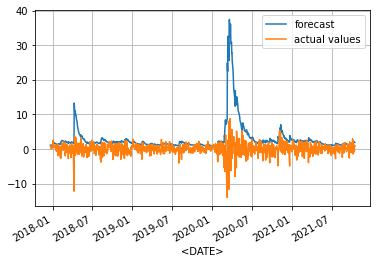

In [171]:
fvm.hist_output.plot(label='forecast')
test.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

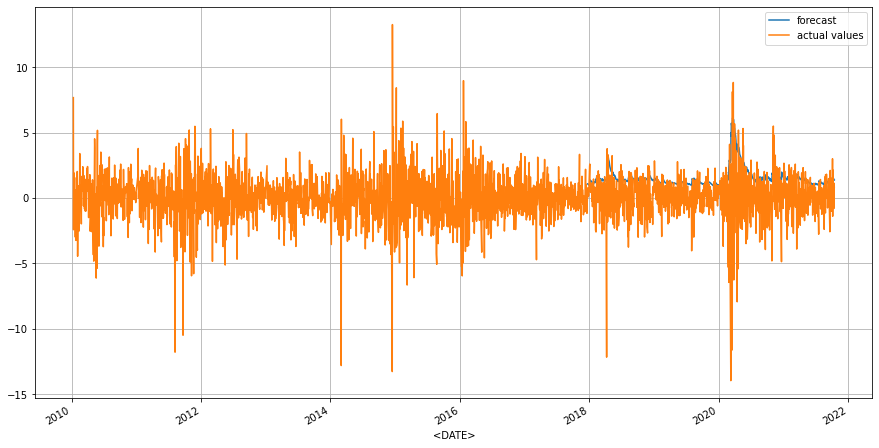

In [189]:
(fvm.hist_output ** .5).plot(label='forecast', figsize=(15, 8))
input_data.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

### Errors

In [173]:
mean_squared_error(fvm.hist_output, test, squared=True)

30.8103328489834543

In [174]:
mean_squared_error(fvm.hist_output, test, squared=False)

5.55070561721511712

In [175]:
mean_absolute_percentage_error(fvm.hist_output, test)

1.0088459340363915164